<a href="https://colab.research.google.com/github/jacopomanenti01/Graph-Neural-Networks/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implement two versions of Graph Attention Network (GAT) from scratch using only PyTorch, without relying on PyTorch Geometric (PyG) or Deep Graph Library (DGL). The two versions are:

* ✅One using adjacency matrix format.
* ✅One using edge list format

**Requirements**

1. ✅ *Dataset*: QM7b from [*torch_geometric.datasets*](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM7b.html)

2. ✅ *Task*: Graph Level Task

3. *Model Specifications*:
    - [x] ✅Incorporate dropout in the GAT model.
    - [x] ✅Utilize a deep MLP for optimization.
    - [x] ✅Implement multi-head attention.
    - [x] ✅Consider self-loops or modify the GAT formula by adding a bias term.
    - [x] ✅Apply input normalization
    - [x] ✅Apply layer normalization between each layer.
    - [x] ✅Include skip connections (jumping knowledge).
    - [x] ✅Try any new ideas that you can learn
        - ✅use edge features
        - ✅add features
    - [x] ✅Aim for an 80/10/10 train/validation/test split.

4. *Analysis*:
    * ✅Accuracy
    * ✅Comparative analysis
    * ✅Avoid oversmoothing
      * ✅ Check the diameter of the graphs
      * ✅ Determine the optimal number of layers
      * ✅ compare other # layers



# Dependencies

In [1]:
!pip install torch torchvision torchaudio torch-geometric
!pip install --upgrade scipy networkx



import pandas as pd
import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tabulate import tabulate
import numpy as np

import torch_geometric as torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import QM7b
from torch_geometric.loader import DataLoader
from torch.optim import Adam

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Dataset

In [3]:
import torch_geometric.transforms as T
# pre_transform=T.NormalizeFeatures
dataset = QM7b(root='/tmp/QM7b',pre_transform=T.NormalizeFeatures)

batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_nodes = np.array(range(len(data_loader)))
for i, batch in enumerate(data_loader):
    n_nodes[i] = batch.num_nodes


print(f"Number of batches: {len(data_loader)}")
print(f"Number of total graphs: {len(dataset)}")
print(f"Avg number of total nodes per batch: {n_nodes.sum()/len(data_loader):.0f}")
print(f"Number of total edges: {dataset.data}")
print(f"Number of edge features: {dataset.num_edge_features}")
print(f"Number of edge labels: {len(dataset.edge_attr)}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Regression targets: {dataset.y.T.shape[0]}")
print(f"Number of classes: {dataset.y.unique().T}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


Number of batches: 226
Number of total graphs: 7211
Avg number of total nodes per batch: 492
Number of total edges: Data(edge_index=[2, 1766366], edge_attr=[1766366], y=[7211, 14], num_nodes=111180)
Number of edge features: 1
Number of edge labels: 1766366
Number of classes: 14
Regression targets: 14
Number of classes: tensor([-2212.5664, -2212.4805, -2212.4158,  ...,    22.9407,    36.7681,
           39.6946])


# Dataset Analysis

A common approach is to stack a number of GNN layers equal to the network diameter.

**Explainantion**:

If you stack N
 GNN layers, each node will make use of the info coming from the N
-hop neighborhood (all nodes having shortest path from the source node equal to N
).

The diameter d
 is defined as the **maximum shortest path between a pair of nodes** in the network (it means that each node in the network has at most a d
-hop neighborhood).

If you stack d
 GNN layers then you are sure that each node is considering all nodes in a d
-hop neighborhood that, by definition of diameter, it means all nodes in the network.





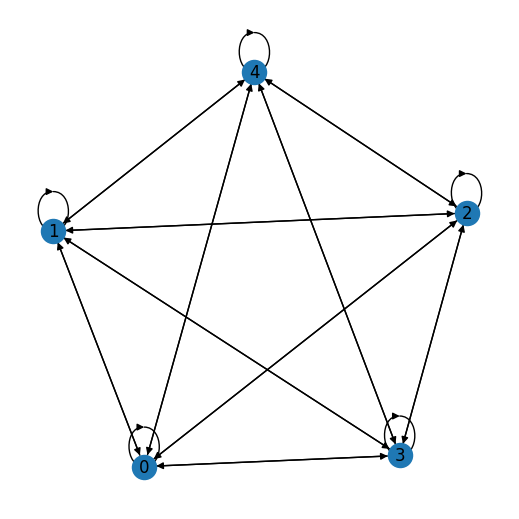

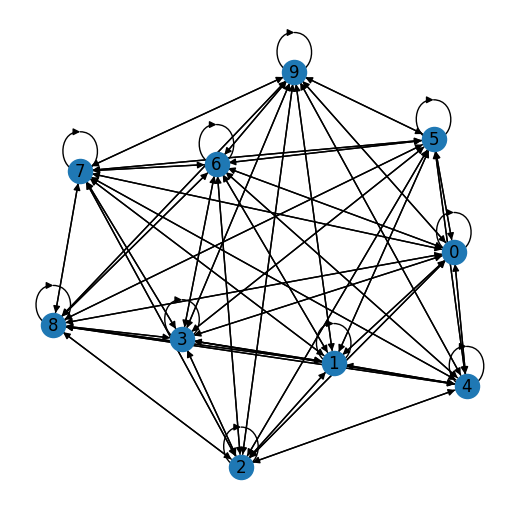

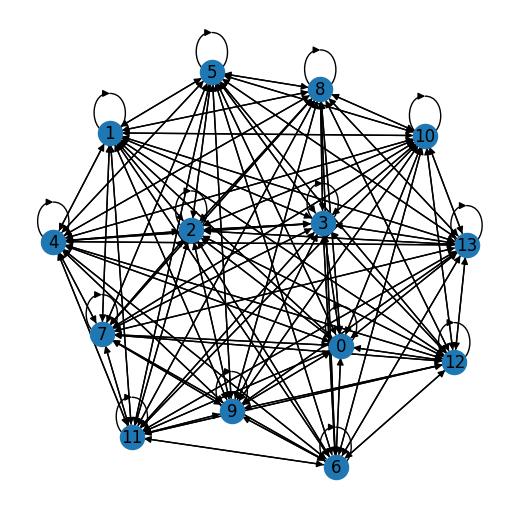

Mean diameter: 1.00
Max diameter: 1
Min diameter: 1


In [ ]:
from torch_geometric.utils.convert import to_networkx
# get the diameter
diameters = np.array(range(len(dataset)))


for i, data in enumerate(dataset):
  G = to_networkx(data)
  diameters[i] = nx.diameter(G)

  if i % 3000 == 0:
    plt.figure(figsize= (5,5))
    nx.draw(G, with_labels=True)
    plt.show()

print(f"Mean diameter: {diameters.mean():.2f}")
print(f"Max diameter: {diameters.max()}")
print(f"Min diameter: {diameters.min()}")



# Utilis Functions

In [4]:
!pip install tqdm
from tqdm import tqdm



def train(epoch,
          data,
          model,
          criterion,
          lr,
          wd,
          device):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # 5e-4

    # initialize lists
    all_pred = []

    # initialize loss
    total_loss = 0
    total_batches = 0
    loss_history = []

    for i in tqdm(range(0, epoch)):
        # set training mode
        model.train()
        # batch loss
        epoch_loss = 0

        for batch in data:
            # reset the grad at every batch
            opt.zero_grad()

            batch = batch.to(device)

            num_nodes = batch.num_nodes

            # Initialize random features for each node
            batch.x = torch.rand((num_nodes, 3))
            # Node features for the entire batch
            input = batch.x
            # Edge indices for the entire batch
            adj = torch_geometric.utils.to_dense_adj(batch.edge_index)

            x, edge, b = input, adj, batch.batch

            out = model(x, edge, b)
            # compute the loss
            loss = criterion(out, batch.y)
            # compute gradients
            loss.backward()
            # optimize
            opt.step()

            # Accumulate loss for this batch
            epoch_loss += loss.item()
            total_batches += 1

            if i == epoch-1:
              all_pred.append(out)


        total_loss += epoch_loss
        avg_epoch_loss = total_loss / total_batches
        loss_history.append(avg_epoch_loss)

        if i % 1 == 0:
            print(f"The current loss is {avg_epoch_loss:.4f}")

    # Concatenate all predictions
    pred = torch.cat(all_pred, dim=0).detach().cpu().numpy()

    return avg_epoch_loss, pred, loss_history

In [5]:
def test(loader, model, device):
  model.eval()
  total_RMSE = 0
  all_pred = []
  total_samples= 0
  all_labels = []

  with torch.no_grad():
        for data in loader:
            data = data.to(device)

            num_nodes = data.num_nodes
            # Initialize random features for each node
            data.x = torch.rand((num_nodes, 3))

            input = data.x

            adj = torch_geometric.utils.to_dense_adj(data.edge_index)
            x, edge, batch = input, adj, data.batch

            # Forward pass through the model
            out = model(x, edge, batch)

            # Predicted regression tasks
            all_pred.append(out.detach().cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

            criterion  = nn.MSELoss()
            # Accumulate correct predictions and total number of samples
            RMSE = torch.sqrt(criterion(out, data.y))
            total_RMSE += RMSE.item()
            total_samples += out.shape[0]


  # Compute overall MAE
  overall_RMSE = total_RMSE / total_samples

  # Concatenate all predictions and labels
  all_pred = np.concatenate(all_pred)
  all_labels= np.concatenate(all_labels)

  y_test = all_labels
  return overall_RMSE, all_pred, y_test


In [6]:
def splitting(dataset, val_size ,test_size):
  from sklearn.model_selection import train_test_split
  from torch.utils.data import Subset

  # Set the random seed for reproducibility
  random_seed = 42

  # Split indices for training and the remaining data
  train_idx, temp_idx = train_test_split(
      range(len(dataset)), test_size=test_size, random_state=random_seed
  )

  # Split the remaining indices for validation and testing
  val_idx, test_idx = train_test_split(
      temp_idx, test_size=val_size, random_state=random_seed
  )


  train_dataset = Subset(dataset, train_idx)
  val_dataset = Subset(dataset, val_idx)
  test_dataset = Subset(dataset, test_idx)

  # Create data loaders
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  print(f"Number of train batches: {len(train_loader)}")
  print(f"Number of validation batches: {len(val_loader)}")
  print(f"Number of test batches: {len(test_loader)}")
  print(f"Number of total batches: {len(train_loader) + len(val_loader) + len(test_loader)}, Number of batches in the original dataset: {len(data_loader)}")

  return train_loader, val_loader, test_loader




In [7]:
import matplotlib.pyplot as plt

def print_scatterplot(pred,y_test):
  fig, ax = plt.subplots(7,2, figsize=(15, 15))
  for i in range(14):
    ax[i%7,(i//7)].scatter(pred[:,i],y_test[:,i], edgecolors = "red",alpha=0.5)

    ax[i%7,(i//7)].set_ylabel("True")
    ax[i%7,(i//7)].plot([0, 1], [0, 1], transform=ax[i%7,(i//7)].transAxes)
    ax[i%7,(i//7)].set_title(f"Scatter plot Pred vs True for task {i+1}")
  fig.tight_layout()
  plt.show(block=True)
  plt.close(fig)

In [8]:
def print_error_dist(pred,y_test):

  fig, ax = plt.subplots(7,2, figsize=(15, 15))
  for i in range(14):

    ax[i%7,(i//7)].hist(pred[:,i]-y_test[:,i],bins = 50,)

    ax[i%7,(i//7)].set_ylabel("True")
    ax[i%7,(i//7)].set_title(f"Error Distribution for task {i+1}")
  fig.tight_layout()
  plt.show(block=True)
  plt.close(fig)


In [9]:
def print_margin_dist(pred,y_test):
  # Convert to PyTorch tensor
  all_pred = torch.from_numpy(pred)
  all_y = torch.from_numpy(y_test)
  # calculate MAE per task
  RMSE_per_task = torch.sqrt(torch.mean((all_pred - all_y)**2, dim=0)).numpy()  # Shape: [num_tasks]

  task_names = [f"Task {i}" for i in range(1, 15)]

  # Plotting
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.bar(task_names, RMSE_per_task, color='skyblue', edgecolor='black')
  ax.set_xlabel("Tasks", fontsize=12)
  ax.set_yscale('log')
  ax.set_ylabel("Mean Absolute Error (RMSE)", fontsize=12)
  ax.set_title("RMSE per Task", fontsize=14)
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show(block=True)
  plt.close(fig)



# Train, Validation, Test sets

In [12]:
train_loader, val_loader, test_loader = splitting(dataset, 0.2, 0.1)

Number of train batches: 203
Number of validation batches: 19
Number of test batches: 5
Number of total batches: 227, Number of batches in the original dataset: 226


# GAT layer

## GAT with ADJ matrix only

1. Linear Transformation

$\overline{h_i^{'}} = \textbf{W} ⋅ \overline{h_i}  $


$\text{with }  \textbf{W}\in R^{F^{'}x \text{ F}} \text{ and } \overline{h_i}  \in R^{\text{F}}  $

$\overline{h_i^{'}}\in R^{F^{'}} $

2. Attention Mechanism

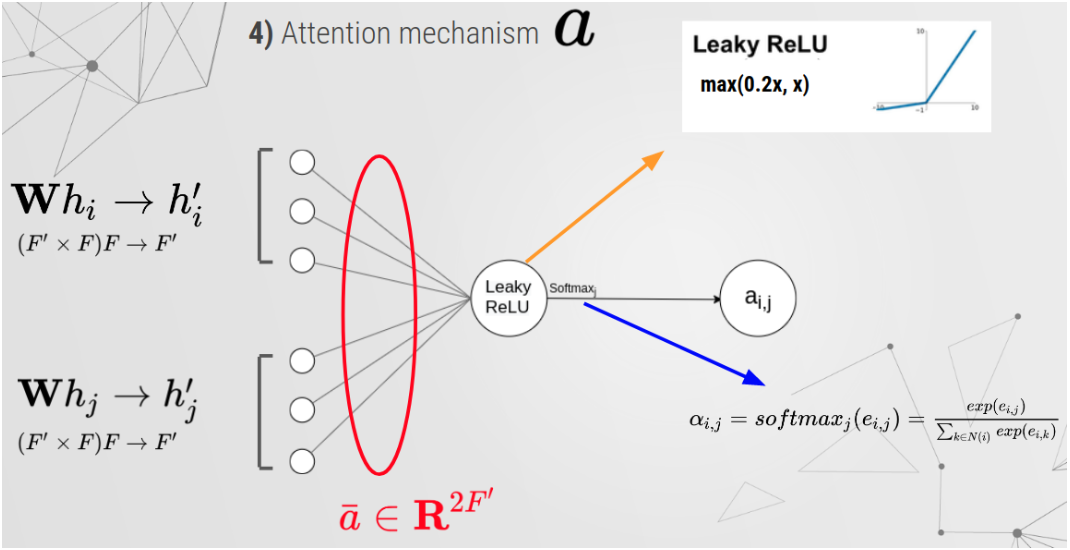

In [16]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True,residual_proj=None):
        super(GATLayer, self).__init__()

        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat
        self.is_residual = residual_proj



        # Xavier Initialization of Weights
        # linear transformation
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        # attention paramenters
        self.a = nn.Parameter(torch.zeros(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        # set leaky relu
        self.leakyrelu = nn.LeakyReLU(self.alpha)

        if residual_proj:
            self.residual_proj = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()
        else:
            self.residual_proj = None

    def forward(self, input, adj):
        input = input.to(device)
        self.W = self.W.to(device)
        self.a = self.a.to(device)
        adj = adj.to(device)

        # Linear Transformation (for all nodes in the batch)

        h = torch.mm(input, self.W)  # (n_nodes, out_features)
        N = h.size(0)  # Number of nodes in the batch

        # Attention Mechanism (for all nodes in the batch)
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features) # (n_nodes,n_nodes, 2*out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2)) # (n_nodes,n_nodes)

        # Masked Attention (applying the adjacency matrix of the batch)
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec) # (n_nodes,n_nodes)

        # Softmax and Dropout
        attention = F.softmax(attention, dim=1) # (n_nodes,n_nodes)
        attention = F.dropout(attention, self.dropout, training=self.training) # (n_nodes,n_nodes)
        h_prime = torch.matmul(attention, h) # (n_nodes,output)

         # Residual Connection and project input if necessary
        if self.residual_proj is not None:
            input = self.residual_proj(input)
            h_prime = h_prime + input  # Add residual connection

        if self.concat:
            return F.elu(h_prime).view(-1, self.out_features) # (n_nodes,out)
        else:
            return h_prime.view(-1, self.out_features) # (n_nodes,out)

In [17]:
from torch_geometric.nn import global_mean_pool, global_max_pool, LayerNorm

class MultiHeadGat(nn.Module):
    def __init__(self, num_heads, in_features, hidden_features, out_features, dropout, alpha, concat=True, pooling_type='mean', is_layerNorm = True, residual = True):
        super(MultiHeadGat, self).__init__()

        self.num_heads = num_heads
        self.concat = concat
        self.dropout = dropout
        self.pooling_type = pooling_type
        self.is_layerNorm= is_layerNorm




        # Initialize attention heads
        self.heads = nn.ModuleList([
            GATLayer(
                in_features=in_features,
                out_features=hidden_features,
                dropout=dropout,
                alpha=alpha,
                concat=concat,
                residual_proj=residual
            ) for i in range(num_heads)
        ])

        # Head transformation layer
        if concat:
            self.head_transform = nn.Linear(hidden_features * num_heads, hidden_features)

        # Layer norm
        if is_layerNorm:
          self.layer_norms = nn.ModuleList([nn.LayerNorm(head.out_features) for head in self.heads])


        # Final classification layer
        self.classifier = nn.Linear(hidden_features, out_features)

    def forward(self, x, adj, batch=None):
        head_outputs = [head(x, adj) for head in self.heads]

        if self.is_layerNorm:
          head_outputs = [self.layer_norms[i](x) for i,x in enumerate(head_outputs)]

        if self.concat:
            x = torch.cat(head_outputs, dim=-1)  # (N, num_heads * hidden_features)

            x = F.relu(self.head_transform(x))  # (N, hidden_features)
            x = F.dropout(x, p=self.dropout, training=self.training)

        else:
            x = torch.mean(torch.stack(head_outputs), dim=0)  # (N, hidden_features)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        if batch is not None:
            if self.pooling_type == 'mean':
                x = global_mean_pool(x, batch)  # (num_graphs, hidden_features)
            elif self.pooling_type == 'max':
                x = global_max_pool(x, batch)  # (num_graphs, hidden_features)


        x = self.classifier(x)  # (num_graphs, out_features)
        return x

In [26]:
criterion = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
in_features = 3
epochs = 10

model = MultiHeadGat(
    num_heads=3,
    in_features=in_features,
    hidden_features=64,
    out_features=14,
    dropout=0.6,
    alpha=0.2,
    concat=True,
    pooling_type='mean',
    is_layerNorm = False,
    residual = True
)

loss, pred,loss_history = train(epoch =epochs,
             data = train_loader,
             model = model,
             criterion = criterion,
             lr = 0.01,
             wd = 5e-4,
             device = device)





cuda:0


 10%|█         | 1/10 [00:06<00:57,  6.37s/it]

The current loss is 24148.5034


 20%|██        | 2/10 [00:10<00:40,  5.06s/it]

The current loss is 14272.4650


 30%|███       | 3/10 [00:14<00:32,  4.64s/it]

The current loss is 10977.3111


 40%|████      | 4/10 [00:19<00:27,  4.56s/it]

The current loss is 9309.4336


 50%|█████     | 5/10 [00:23<00:21,  4.40s/it]

The current loss is 8257.7991


 60%|██████    | 6/10 [00:27<00:17,  4.30s/it]

The current loss is 7577.5688


 70%|███████   | 7/10 [00:31<00:13,  4.34s/it]

The current loss is 7086.4910


 80%|████████  | 8/10 [00:35<00:08,  4.28s/it]

The current loss is 6705.8100


 90%|█████████ | 9/10 [00:40<00:04,  4.41s/it]

The current loss is 6418.2382


100%|██████████| 10/10 [00:45<00:00,  4.50s/it]

The current loss is 6187.7568


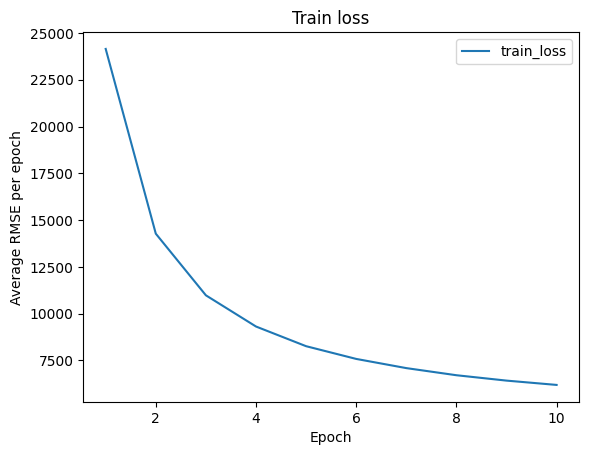

In [27]:
fig , ax = plt.subplots()
x = range(1, epochs +1)
ax.plot(x,loss_history, label='train_loss')
ax.legend()
ax.set_title("Train loss")
ax.set_ylabel("Average RMSE per epoch")
ax.set_xlabel("Epoch")
plt.show()

In [28]:
RMSE, pred, y_test = test(test_loader, model, device)


In [29]:
RMSE

1.9854597683610586

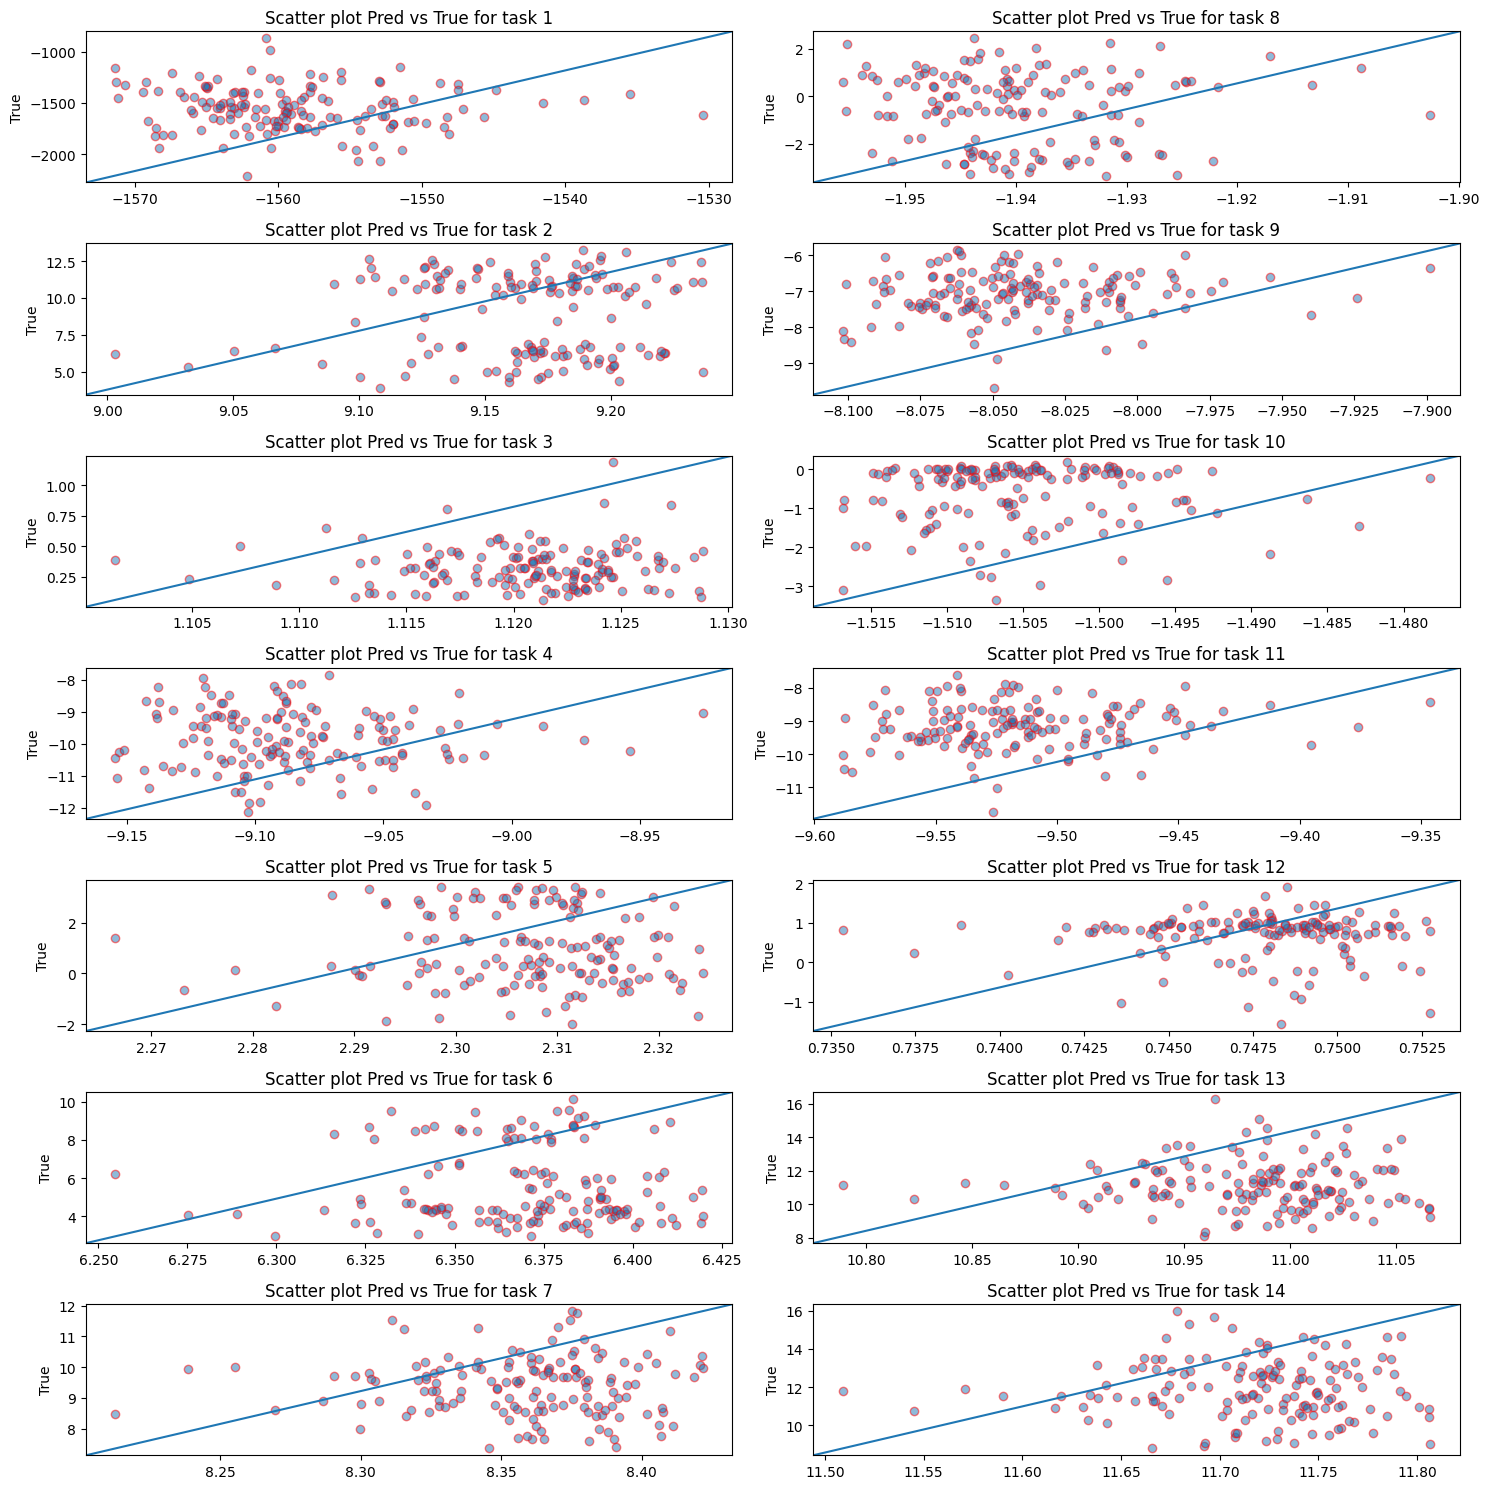

In [30]:
print_scatterplot(pred,y_test)

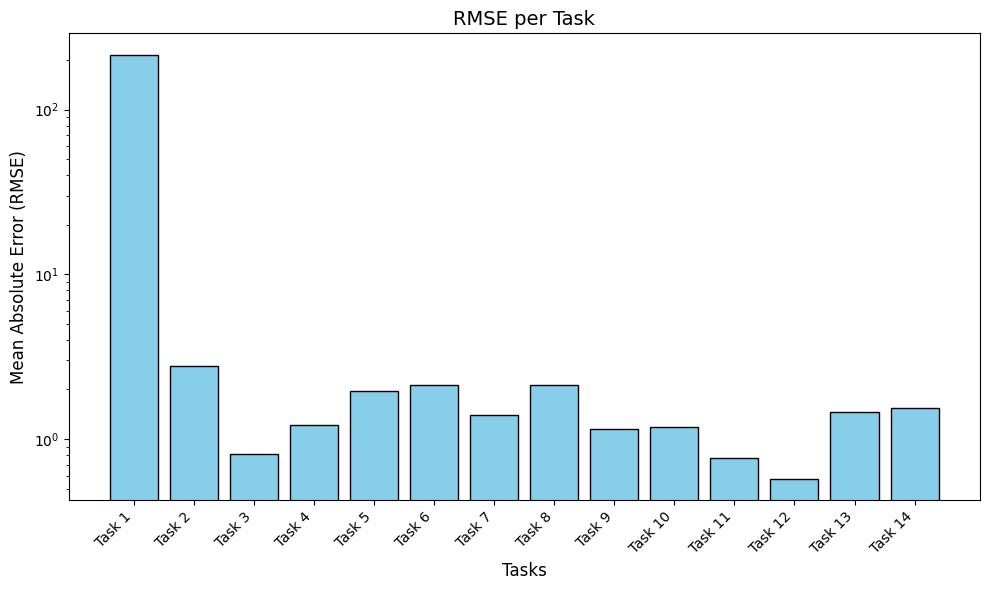

In [31]:
print_margin_dist(pred,y_test)

## GAT with edge list format

In [18]:

def train2(epoch,
          data,
          model,
          criterion,
          lr,
          wd,
          device):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # 5e-4

    # initialize lists
    all_pred = []

    # initialize loss
    total_loss = 0
    total_batches = 0
    loss_history = []

    for i in tqdm(range(0, epoch)):
        # set training mode
        model.train()

        # batch loss
        epoch_loss = 0

        for batch in data:
            # reset gradients
            opt.zero_grad()
            batch = batch.to(device)

            num_nodes = batch.num_nodes
            G = nx.Graph()
            G.add_edges_from(batch.edge_index.t().cpu().numpy())


            batch.x = torch.rand((num_nodes, 3))

            input = batch.x

            adj = nx.to_numpy_array(G)
            adj = torch.from_numpy(adj).to(device)

            x, edge, b = input, adj, batch.batch


            out = model(x, edge, b)
            # compute the loss
            loss = criterion(out, batch.y)
            # compute gradients
            loss.backward()
            # optimize
            opt.step()

            # Accumulate loss for this batch
            epoch_loss += loss.item()
            total_batches += 1

            if i == epoch-1:
              all_pred.append(out)


        total_loss += epoch_loss
        avg_epoch_loss = total_loss / total_batches
        loss_history.append(avg_epoch_loss)

        if i % 1 == 0:
            print(f"The current loss is {avg_epoch_loss:.4f}")

    # Concatenate all predictions
    pred = torch.cat(all_pred, dim=0).detach().cpu().numpy()

    return avg_epoch_loss, pred, loss_history

In [21]:
criterion = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
in_features = 3
epochs = 10

model = MultiHeadGat(
    num_heads=3,
    in_features=in_features,
    hidden_features=64,
    out_features=14,
    dropout=0.6,
    alpha=0.2,
    concat=True,
    pooling_type='mean',
    is_layerNorm = False,
    residual = True
)

loss, pred,loss_history = train2(epoch =epochs,
             data = train_loader,
             model = model,
             criterion = criterion,
             lr = 0.01,
             wd = 5e-4,
             device = device)


 10%|█         | 1/10 [00:14<02:07, 14.14s/it]

The current loss is 26794.6469


 20%|██        | 2/10 [00:29<01:59, 14.98s/it]

The current loss is 15628.3111


 30%|███       | 3/10 [00:37<01:23, 11.86s/it]

The current loss is 11884.3284


 40%|████      | 4/10 [00:47<01:05, 10.96s/it]

The current loss is 10004.1158


 50%|█████     | 5/10 [00:56<00:51, 10.33s/it]

The current loss is 8852.1391


 60%|██████    | 6/10 [01:05<00:39,  9.79s/it]

The current loss is 8061.0407


 70%|███████   | 7/10 [01:14<00:28,  9.57s/it]

The current loss is 7476.6671


 80%|████████  | 8/10 [01:24<00:19,  9.59s/it]

The current loss is 7017.1088


 90%|█████████ | 9/10 [01:33<00:09,  9.49s/it]

The current loss is 6645.4105


100%|██████████| 10/10 [01:42<00:00, 10.21s/it]

The current loss is 6325.5160


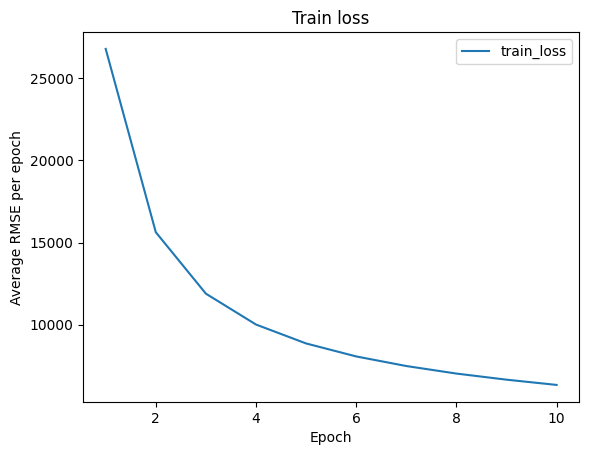

In [22]:
fig , ax = plt.subplots()
x = range(1, epochs +1)
ax.plot(x,loss_history, label='train_loss')
ax.legend()
ax.set_title("Train loss")
ax.set_ylabel("Average RMSE per epoch")
ax.set_xlabel("Epoch")
plt.show()

In [23]:
RMSE, pred, y_test = test(test_loader, model, device)


In [24]:
RMSE

7.8406199488146555

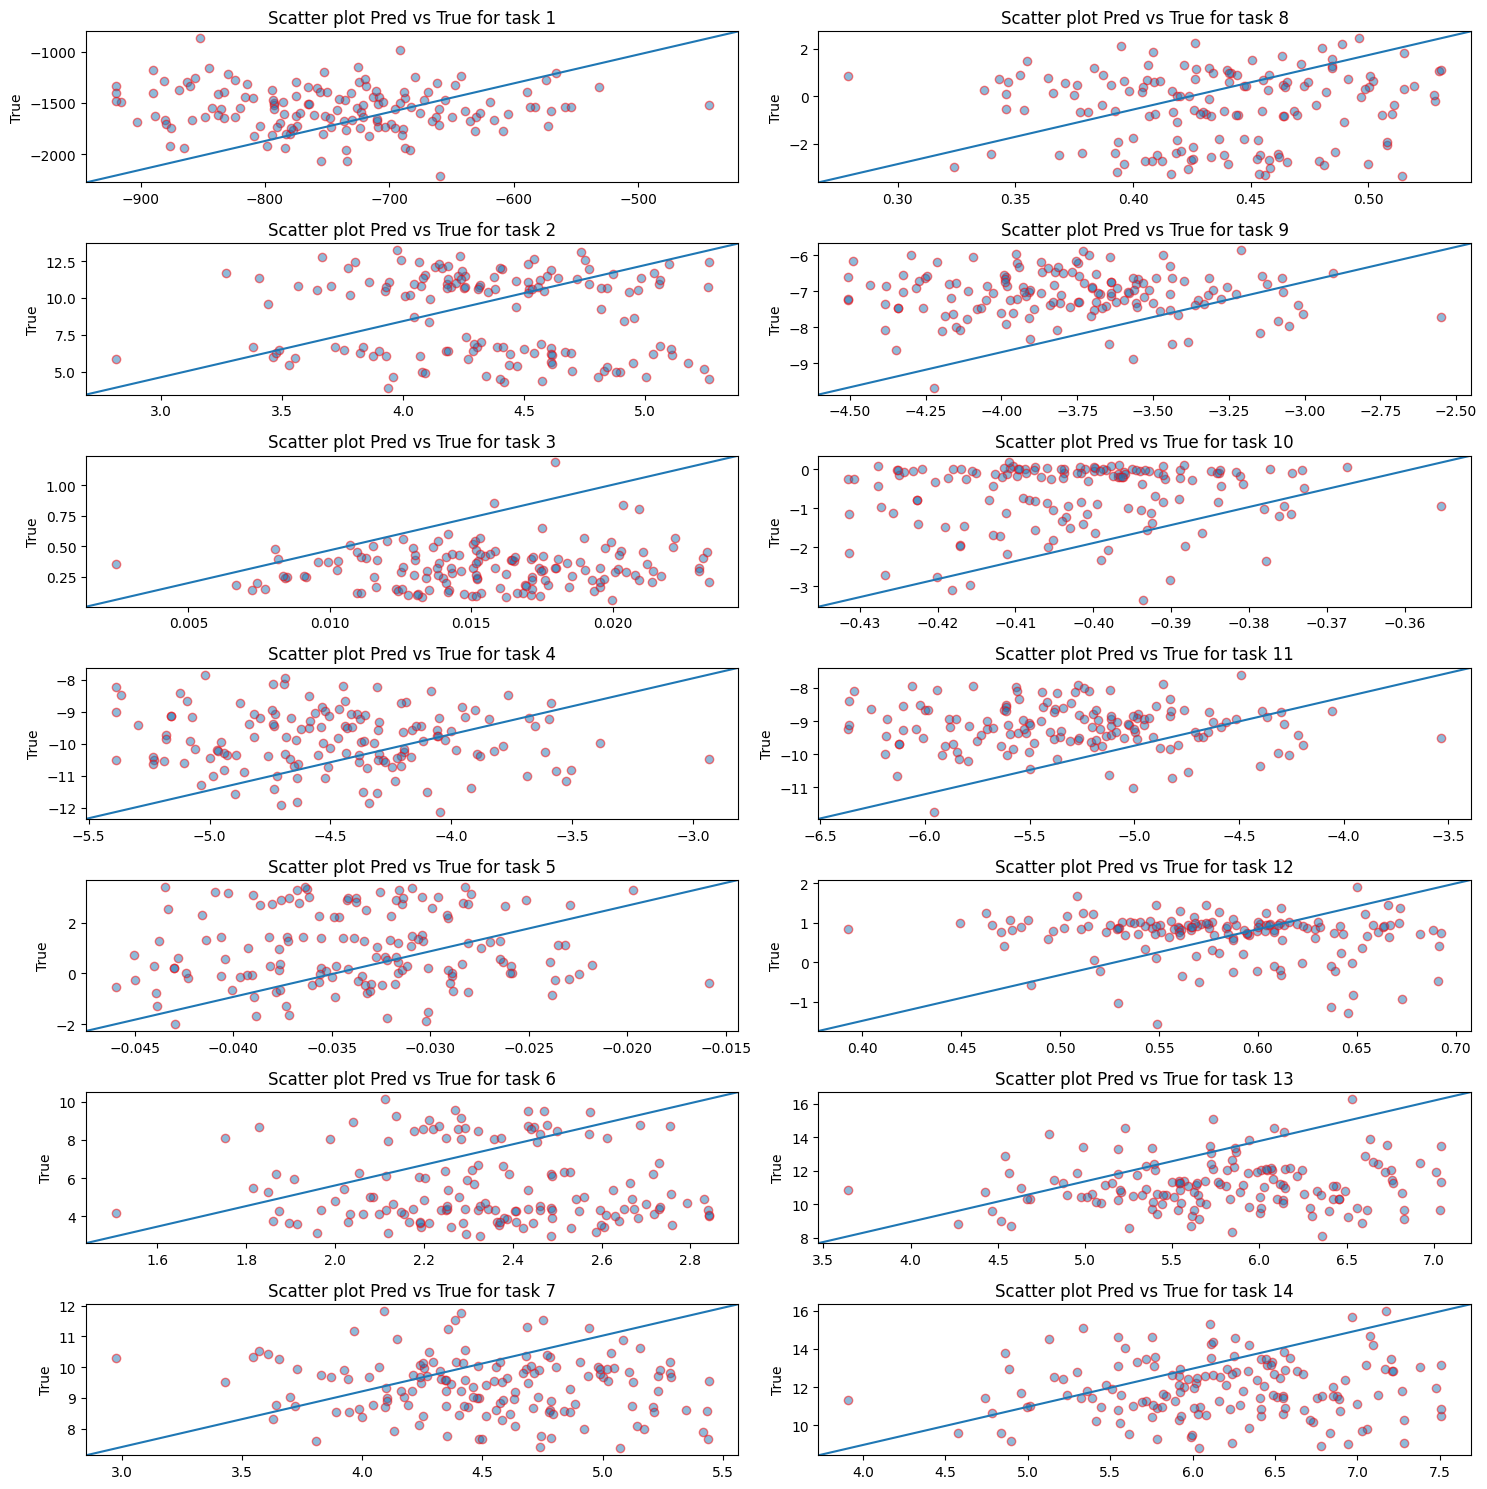

In [25]:
print_scatterplot(pred,y_test)

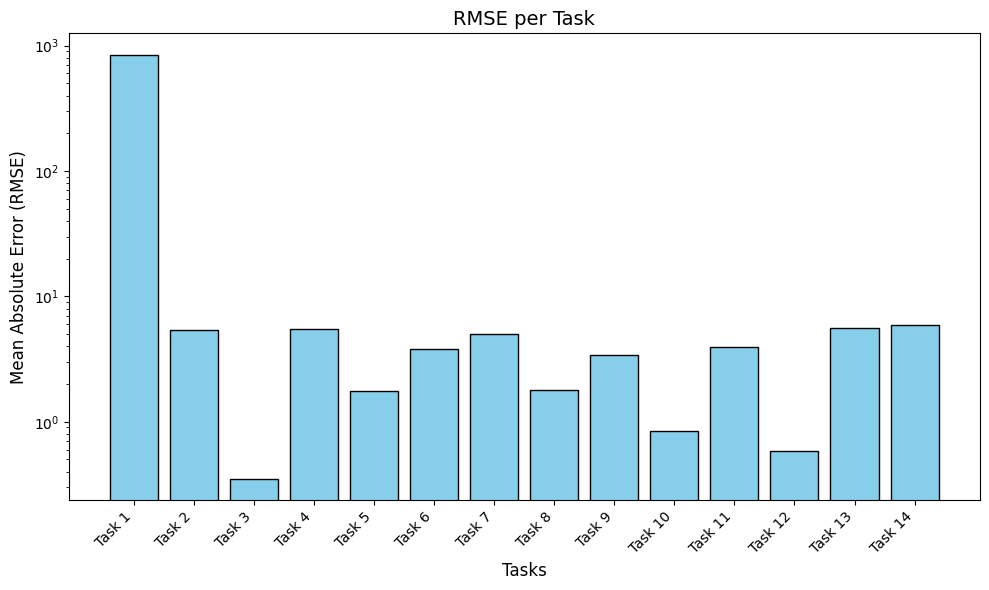

In [26]:
print_margin_dist(pred,y_test)

# Handcrafting Node Features

Predicting Electronic Properties: The tasks involve properties like atomization energy, HOMO/LUMO eigenvalues, dipole moment, and other molecular electronic properties.


The stable conformational coordinates for each molecule are already computed, which is highly beneficial for creating spatial features.



For a dataset like QM7B, feature engineering should capture both local atomic environment (node and edge features) and global molecular properties (graph-level features).




Furthermore, in the QM7b dataset, the edge attributes (edge_attr) represent important chemical/molecular information about the bonds between atoms in the molecule.

## Use the edge_att in the Model

In [29]:
class GATLayer2(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True,residual_proj=None):
        super(GATLayer2, self).__init__()

        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat
        self.is_residual = residual_proj



        # Xavier Initialization of Weights
        # linear transformation
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features))).to('cuda')
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        # attention paramenters
        self.a = nn.Parameter(torch.zeros(size=(2 * out_features+1, 1))).to('cuda')
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        # set leaky relu
        self.leakyrelu = nn.LeakyReLU(self.alpha)

        if residual_proj:
            self.residual_proj = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()
        else:
            self.residual_proj = None

    def forward(self, input, adj, edge_feature):
        input = input.to(device)
        adj = adj.to(device)
        edge_attr = edge_feature.to(device)



        # Linear Transformation (for all nodes in the batch)


        h = torch.mm(input, self.W)  # (n_nodes, out_features)
        N = h.size(0)  # Number of nodes in the batch

        h_i = h.repeat(1, N).view(N * N, -1)
        h_j = h.repeat(N, 1)


        edge_features = torch.zeros(N * N, 1).to(device)
        edge_indices = torch.nonzero(adj, as_tuple=False)  # This returns indices (i, j) where adj[i, j] == 1

        edge_features[edge_indices[:, 0] * N + edge_indices[:, 1]] = edge_attr
        edge_features = edge_features.view(N*N,1)


        # Attention Mechanism (for all nodes in the batch)
        a_input = torch.cat([h_i,h_j, edge_features], dim=1).view(N, -1, 2 * self.out_features+1) # (n_nodes,n_nodes, 2*out_features+1)


        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2)) # (n_nodes,n_nodes)

        # Masked Attention (applying the adjacency matrix of the batch)
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec) # (n_nodes,n_nodes)

        # Softmax and Dropout
        attention = F.softmax(attention, dim=1) # (n_nodes,n_nodes)
        attention = F.dropout(attention, self.dropout, training=self.training) # (n_nodes,n_nodes)
        h_prime = torch.matmul(attention, h) # (n_nodes,output)

         # Residual Connection and project input if necessary
        if self.residual_proj is not None:
            input = self.residual_proj(input)
            h_prime = h_prime + input  # Add residual connection

        if self.concat:
            return F.elu(h_prime).view(-1, self.out_features) # (n_nodes,out)
        else:
            return h_prime.view(-1, self.out_features) # (n_nodes,out)

In [32]:
from torch_geometric.nn import global_mean_pool, global_max_pool, LayerNorm

class MultiHeadGat2(nn.Module):
    def __init__(self, num_heads, in_features, hidden_features, out_features, dropout, alpha, concat=True, pooling_type='mean', is_layerNorm = True, residual = True):
        super(MultiHeadGat2, self).__init__()

        self.num_heads = num_heads
        self.concat = concat
        self.dropout = dropout
        self.pooling_type = pooling_type
        self.is_layerNorm= is_layerNorm




        # Initialize attention heads
        self.heads = nn.ModuleList([
            GATLayer2(
                in_features=in_features,
                out_features=hidden_features,
                dropout=dropout,
                alpha=alpha,
                concat=concat,
                residual_proj=residual
            ) for i in range(num_heads)
        ])

        # Head transformation layer
        if concat:
            self.head_transform = nn.Linear(hidden_features * num_heads, hidden_features)

        # Layer norm
        if is_layerNorm:
          self.layer_norms = nn.ModuleList([nn.LayerNorm(head.out_features) for head in self.heads])


        # Final classification layer
        self.classifier = nn.Linear(hidden_features, out_features)

    def forward(self, x, adj, edge_attr,  batch=None):
        head_outputs = [head(x, adj,edge_attr) for head in self.heads]
        if self.is_layerNorm:
          head_outputs = [self.layer_norms[i](x) for i,x in enumerate(head_outputs)]

        if self.concat:
            x = torch.cat(head_outputs, dim=-1)  # (N, num_heads * hidden_features)

            x = F.relu(self.head_transform(x))  # (N, hidden_features)
            x = F.dropout(x, p=self.dropout, training=self.training)

        else:
            x = torch.mean(torch.stack(head_outputs), dim=0)  # (N, hidden_features)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        if batch is not None:
            if self.pooling_type == 'mean':
                x = global_mean_pool(x, batch)  # (num_graphs, hidden_features)
            elif self.pooling_type == 'max':
                x = global_max_pool(x, batch)  # (num_graphs, hidden_features)


        x = self.classifier(x)  # (num_graphs, out_features)
        return x

In [33]:
!pip install tqdm
from tqdm import tqdm
def train2(epoch,
          data,
          model,
          criterion,
          lr,
          wd,
          device):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # 5e-4

    # initialize lists
    all_pred = []

    # initialize loss
    total_loss = 0
    total_batches = 0
    loss_history = []

    for i in tqdm(range(0, epoch)):
        # set training mode
        model.train()

        # batch loss
        epoch_loss = 0

        for batch in data:
          # reset gradients
            opt.zero_grad()
            batch = batch.to(device)

            num_nodes = batch.num_nodes
            n_edges = batch.edge_index.shape[1]

            batch.x = torch.rand((num_nodes, 3))

            input = batch.x
            edge_features = batch.edge_attr.view(n_edges,-1)

            adj = torch_geometric.utils.to_dense_adj(batch.edge_index)

            x, edge, b = input, adj, batch.batch

            # get probabilities
            out = model(x, edge,edge_features,b)
            # compute the loss
            loss = criterion(out, batch.y)
            # compute gradients
            loss.backward()
            # optimize
            opt.step()

            # Accumulate loss for this batch
            epoch_loss += loss.item()
            total_batches += 1

            if i == epoch-1:
              all_pred.append(out)


        total_loss += epoch_loss
        avg_epoch_loss = total_loss / total_batches
        loss_history.append(avg_epoch_loss)

        if i % 1 == 0:
            print(f"The current loss is {avg_epoch_loss:.4f}")

    # Concatenate all predictions
    pred = torch.cat(all_pred, dim=0).detach().cpu().numpy()

    return avg_epoch_loss, pred, loss_history

In [34]:
criterion = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
in_features = 3
epochs = 10

model = MultiHeadGat2(
    num_heads=3,
    in_features=in_features,
    hidden_features=64,
    out_features=14,
    dropout=0.6,
    alpha=0.2,
    concat=True,
    pooling_type='mean',
    is_layerNorm = False,
    residual = True
)

loss, pred,loss_history = train2(epoch =epochs,
             data = train_loader,
             model = model,
             criterion = criterion,
             lr = 0.01,
             wd = 5e-4,
             device = device)





cuda:0


 10%|█         | 1/10 [00:05<00:50,  5.58s/it]

The current loss is 26953.9231


 20%|██        | 2/10 [00:11<00:44,  5.52s/it]

The current loss is 15691.5110


 30%|███       | 3/10 [00:16<00:38,  5.45s/it]

The current loss is 11932.8478


 40%|████      | 4/10 [00:22<00:33,  5.54s/it]

The current loss is 10041.5388


 50%|█████     | 5/10 [00:27<00:27,  5.55s/it]

The current loss is 8910.6968


 60%|██████    | 6/10 [00:36<00:26,  6.63s/it]

The current loss is 8146.5150


 70%|███████   | 7/10 [00:47<00:24,  8.04s/it]

The current loss is 7602.5532


 80%|████████  | 8/10 [00:56<00:16,  8.31s/it]

The current loss is 7189.1792


 90%|█████████ | 9/10 [01:01<00:07,  7.49s/it]

The current loss is 6865.0922


100%|██████████| 10/10 [01:07<00:00,  6.73s/it]

The current loss is 6608.2060


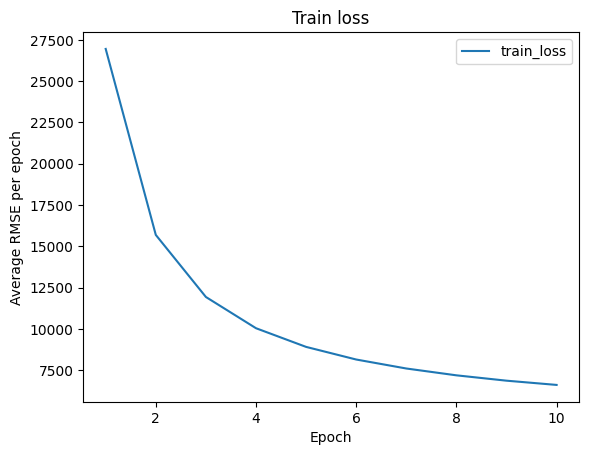

In [35]:
fig , ax = plt.subplots()
x = range(1, epochs +1)
ax.plot(x,loss_history, label='train_loss')
ax.legend()
ax.set_title("Train loss")
ax.set_ylabel("Average RMSE per epoch")
ax.set_xlabel("Epoch")
plt.show()

In [37]:
def test2(loader, model, device):
  model.eval()
  total_RMSE = 0    #
  all_pred = []
  total_samples= 0
  all_labels = []

  with torch.no_grad():
        for data in loader:
            data = data.to(device)

            num_nodes = data.num_nodes
            n_edges = data.edge_index.shape[1]

            data.x = torch.rand((num_nodes, 3))

            input = data.x

            adj = torch_geometric.utils.to_dense_adj(data.edge_index)
            x, edge, batch = input, adj, data.batch

            edges = data.edge_attr.view(n_edges,-1)

            # Forward pass through the model
            out = model(x, edge, edges, batch)

            all_pred.append(out.detach().cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

            criterion  = nn.MSELoss()
            # Accumulate correct predictions and total number of samples
            RMSE = torch.sqrt(criterion(out, data.y))
            total_RMSE += RMSE.item()
            total_samples += out.shape[0]


  # Compute overall MAE
  overall_RMSE = total_RMSE / total_samples

  # Concatenate all predictions and labels
  all_pred = np.concatenate(all_pred)
  all_labels= np.concatenate(all_labels)

  # Return MAE and the predictions for test set
  y_test = all_labels
  return overall_RMSE, all_pred, y_test


In [38]:
RMSE, pred, y_test = test2(test_loader, model, device)


In [39]:
RMSE

1.9692672992574758

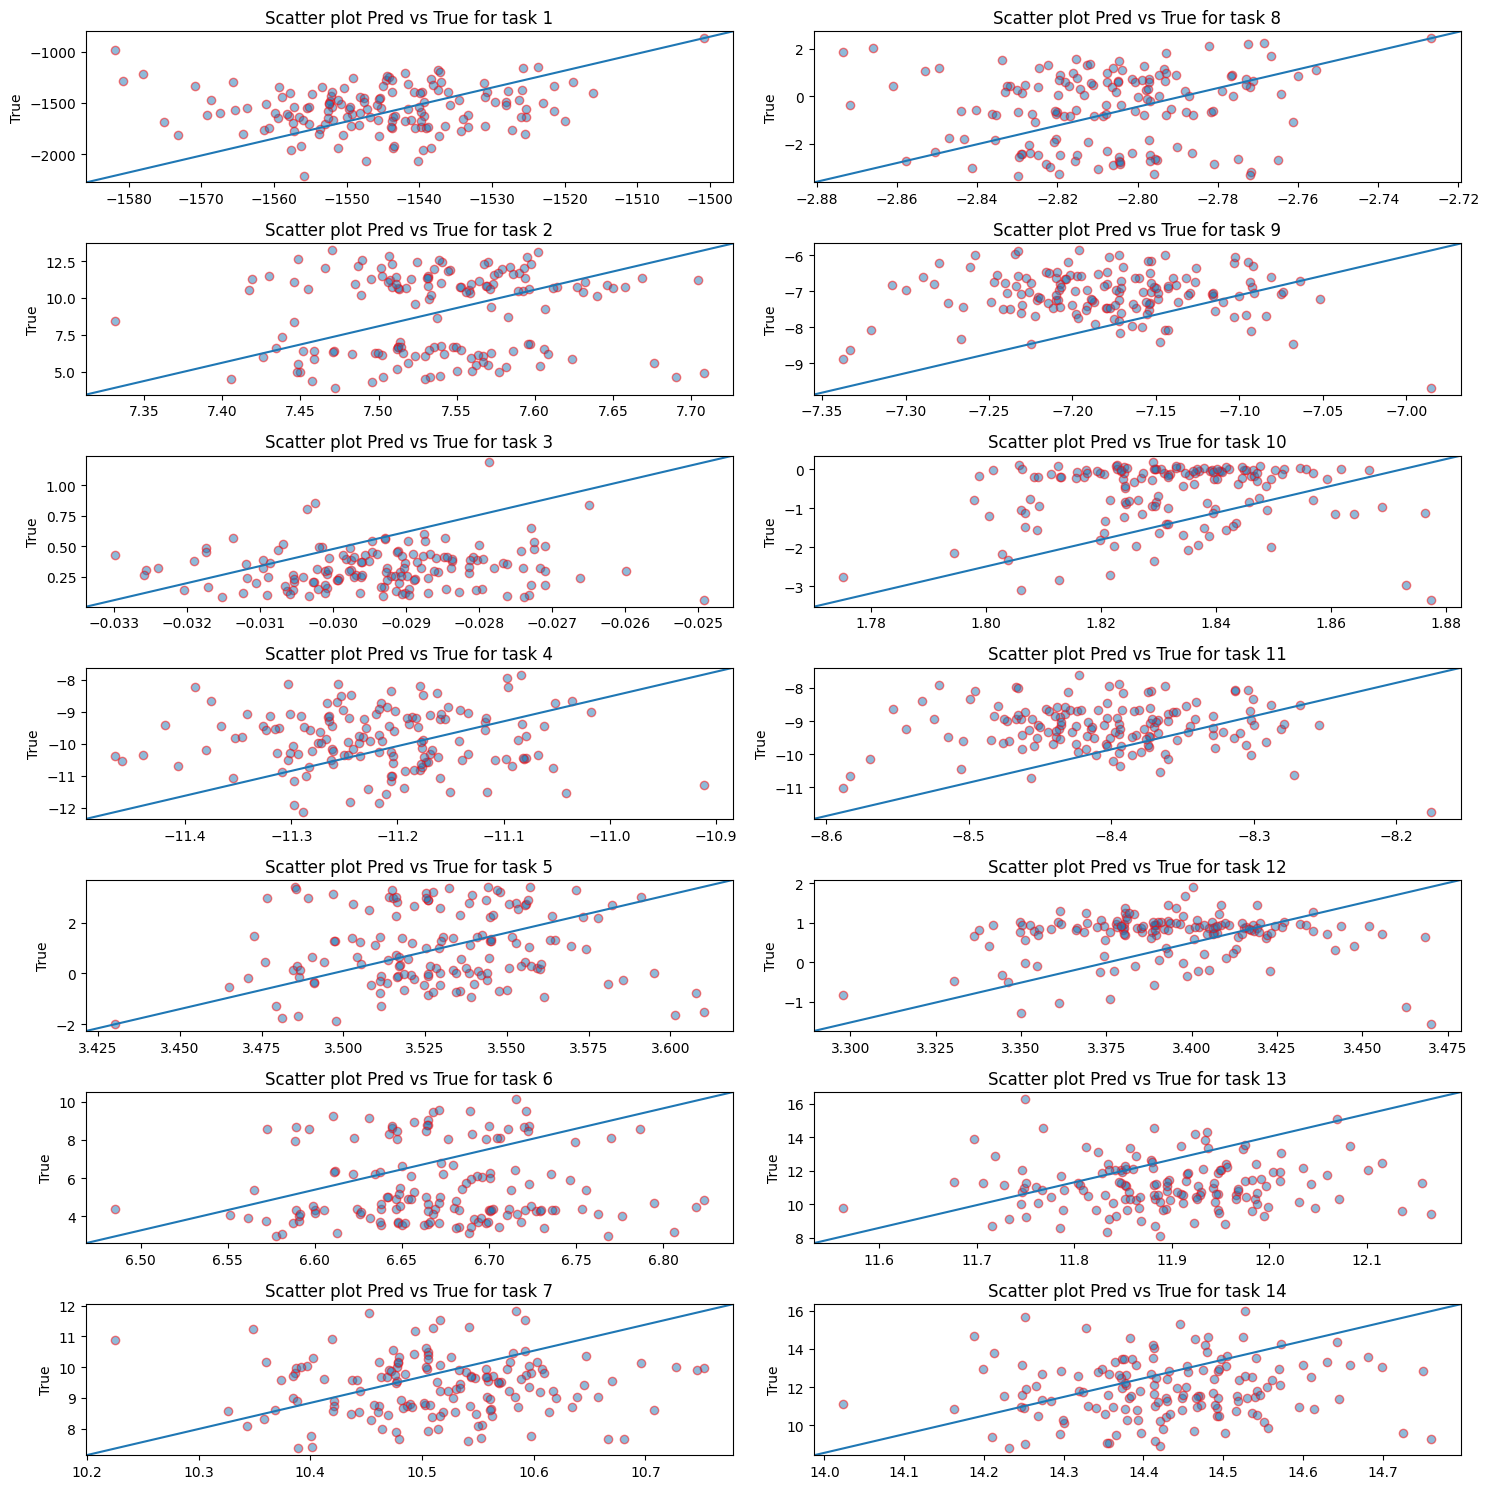

In [40]:
print_scatterplot(pred,y_test)

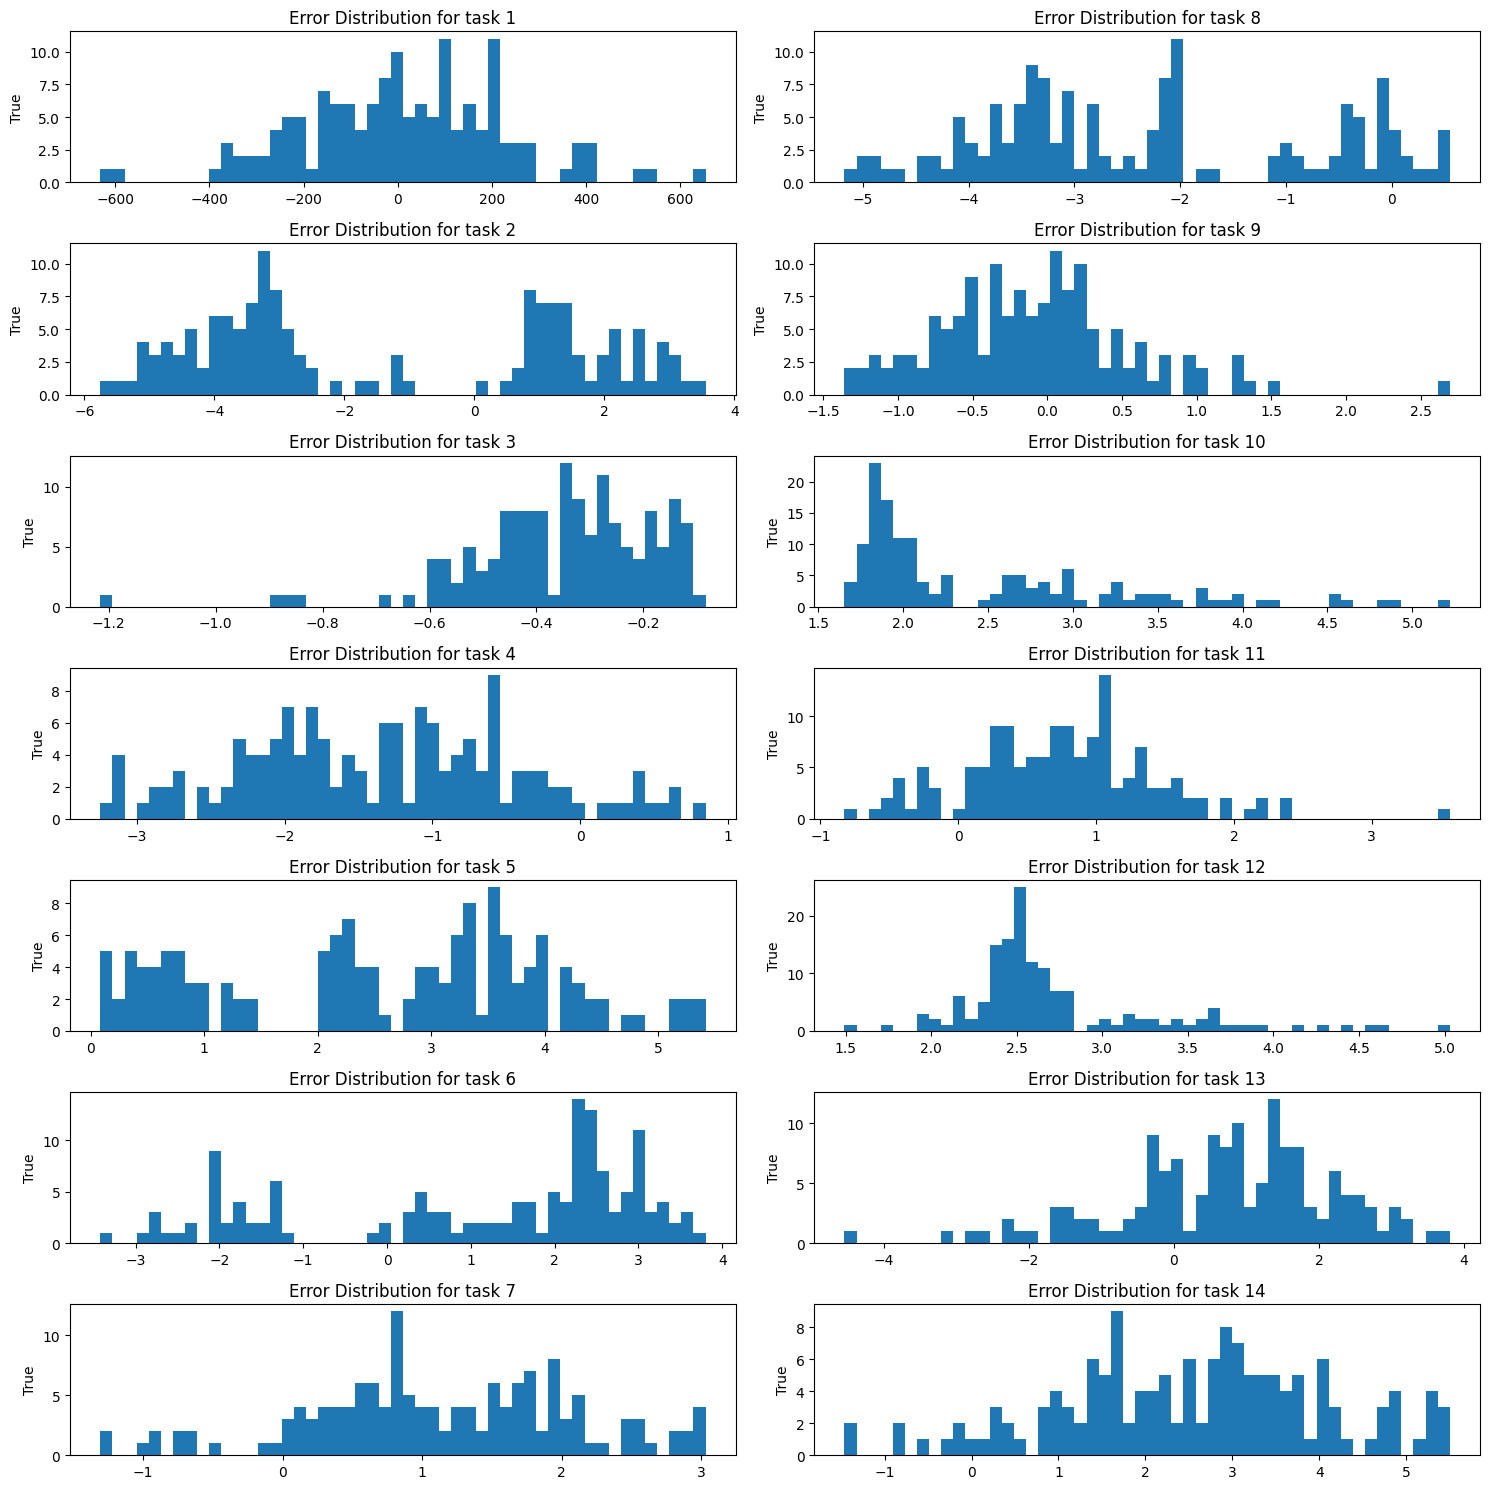

In [41]:
print_error_dist(pred,y_test)


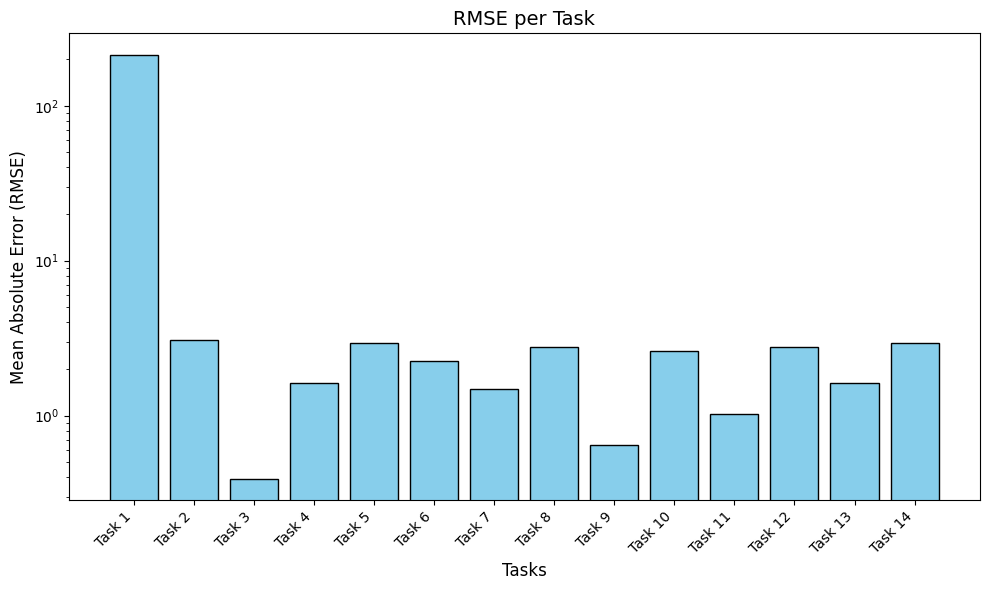

In [42]:
print_margin_dist(pred,y_test)



## Handcraft featurs for each atom

* Degree
* Local clustering coefficient
* Degree centrality
* Eccentricity


In [54]:
import networkx as nx
import torch
from torch_geometric.data import Data

def add_graph_features(graph_batch):

    # Lists to store features for all nodes
    all_degrees = []
    all_clustering_coeffs = []
    all_degree_centralities = []
    all_eccentricities = []

    num_graphs = graph_batch.batch.max().item() + 1

    # Process each graph individually
    for graph_idx in range(num_graphs):
        # Get mask for current graph's nodes
        graph_mask = graph_batch.batch == graph_idx

        # Get edge indices for current graph
        edge_mask = torch.isin(graph_batch.edge_index[0], torch.where(graph_mask)[0]) # bool
        edge_index_graph = graph_batch.edge_index[:, edge_mask]  #[2,n_egdes]

        # Remap node indices to start from 0
        node_mapping = torch.zeros(len(graph_batch.batch), dtype=torch.long)

        node_mapping[graph_mask] = torch.arange(graph_mask.sum())
        edge_index_graph = node_mapping[edge_index_graph]

        # Create PyG Data object for this single graph
        num_nodes = graph_mask.sum().item()
        single_graph = Data(
            x=torch.zeros(num_nodes, 1),  # Dummy feature
            edge_index=edge_index_graph
        )

        # Convert to NetworkX
        G = torch_geometric.utils.convert.to_networkx(single_graph, to_undirected=True)

        # Compute features
        # 1. Degree
        degrees = [d[1] for d in G.degree()]

        # 2. Local clustering coefficient
        clustering = list(nx.clustering(G).values())

        # 3. Degree centrality
        deg_centrality = list(nx.degree_centrality(G).values())

        # 4. Eccentricity (handle disconnected graphs)
        try:
            ecc = list(nx.eccentricity(G).values())
        except:
            ecc = [0] * len(G.nodes())  # Default value for disconnected graphs




        # Append features for this graph
        all_degrees.extend(degrees)
        all_clustering_coeffs.extend(clustering)
        all_degree_centralities.extend(deg_centrality)
        all_eccentricities.extend(ecc)


    # Convert lists to tensors
    new_features = torch.stack([
        torch.tensor(all_degrees, dtype=torch.float),
        torch.tensor(all_clustering_coeffs, dtype=torch.float),
        torch.tensor(all_degree_centralities, dtype=torch.float),
        torch.tensor(all_eccentricities, dtype=torch.float)
    ], dim=1)

    # Concatenate new features with existing node features
    graph_batch.x = new_features

    return graph_batch

In [47]:
from tqdm import tqdm
def train3(epoch,
          data,
          model,
          criterion,
          lr,
          wd,
          device):


    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # 5e-4

    # initialize lists
    all_pred = []

    # initialize loss
    total_loss = 0
    total_batches = 0
    loss_history = []

    for i in tqdm(range(0, epoch)):
        # set training mode
        model.train()

        # batch loss
        epoch_loss = 0

        for batch in data:
          # reset gradients
            opt.zero_grad()

            _ = add_graph_features(batch)
            batch = batch.to(device)

            n_edges = batch.edge_index.shape[1]

            input = batch.x  # Node features for the entire batch
            edge_features = batch.edge_attr.view(n_edges,-1)
            adj = torch_geometric.utils.to_dense_adj(batch.edge_index)

            x, edge, b = input, adj, batch.batch

            out = model(x, edge,edge_features,b)
            # compute the loss
            loss = criterion(out, batch.y)
            # compute gradients
            loss.backward()
            # optimize
            opt.step()

            # Accumulate loss for this batch
            epoch_loss += loss.item()
            total_batches += 1

            if i == epoch-1:
              all_pred.append(out)


        total_loss += epoch_loss
        avg_epoch_loss = total_loss / total_batches
        loss_history.append(avg_epoch_loss)

        if i % 1 == 0:
            print(f"The current loss is {avg_epoch_loss:.4f}")

    # Concatenate all predictions
    pred = torch.cat(all_pred, dim=0).detach().cpu().numpy()

    return avg_epoch_loss, pred, loss_history

In [50]:
def test3(loader, model, device):
  model.eval()

  total_RMSE = 0    # To accumulate total samples for accuracy calculation
  all_pred = []  # To collect all predictions
  total_samples= 0
  all_labels = []

  with torch.no_grad():
        for data in loader:
            # add features
            _ = add_graph_features(data)

            data = data.to(device)
            n_edges = data.edge_index.shape[1]

            input = data.x  # Node features for the entire batch

            adj = torch_geometric.utils.to_dense_adj(data.edge_index)  #
            x, edge, batch = input, adj, data.batch

            edges = data.edge_attr.view(n_edges,-1)

            # Forward pass through the model
            out = model(x, edge, edges, batch)

            # Predicted class labels
            all_pred.append(out.detach().cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

            criterion  = nn.MSELoss()
            # Accumulate correct predictions and total number of samples
            RMSE = torch.sqrt(criterion(out, data.y))
            total_RMSE += RMSE.item()
            total_samples += out.shape[0]


  # Compute overall MAE
  overall_RMSE = total_RMSE / total_samples

  # Concatenate all predictions and labels
  all_pred = np.concatenate(all_pred)
  all_labels= np.concatenate(all_labels)

  # Return MAE and the predictions for test set
  y_test = all_labels
  return overall_RMSE, all_pred, y_test


In [55]:
criterion = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
in_features = 4
epochs = 10

model = MultiHeadGat2(
    num_heads=3,
    in_features=in_features,
    hidden_features=64,
    out_features=14,
    dropout=0.6,
    alpha=0.2,
    concat=True,
    pooling_type='mean',
    is_layerNorm = False,
    residual = True
)

loss, pred,loss_history = train3(epoch =epochs,
             data = train_loader,
             model = model,
             criterion = criterion,
             lr = 0.01,
             wd = 5e-4,
             device = device)





cuda:0


 10%|█         | 1/10 [00:18<02:46, 18.49s/it]

The current loss is 13789.8432


 20%|██        | 2/10 [00:40<02:45, 20.74s/it]

The current loss is 7320.9855


 30%|███       | 3/10 [00:59<02:20, 20.02s/it]

The current loss is 5143.4319


 40%|████      | 4/10 [01:21<02:02, 20.45s/it]

The current loss is 4058.1034


 50%|█████     | 5/10 [01:41<01:42, 20.52s/it]

The current loss is 3408.9320


 60%|██████    | 6/10 [02:00<01:19, 19.93s/it]

The current loss is 2974.0302


 70%|███████   | 7/10 [02:20<00:59, 19.82s/it]

The current loss is 2664.2613


 80%|████████  | 8/10 [02:38<00:38, 19.48s/it]

The current loss is 2433.6051


 90%|█████████ | 9/10 [02:58<00:19, 19.49s/it]

The current loss is 2251.3903


100%|██████████| 10/10 [03:16<00:00, 19.69s/it]

The current loss is 2105.1484


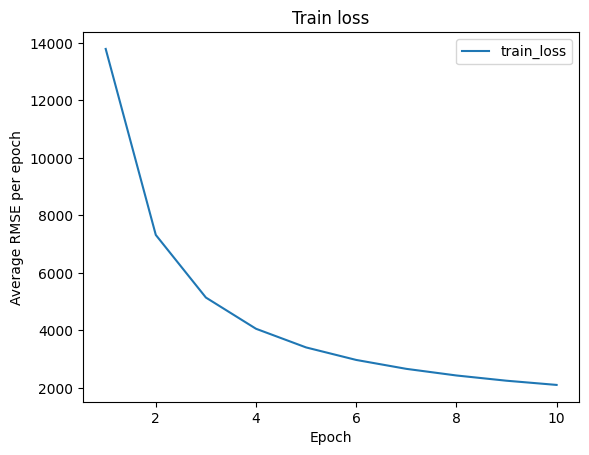

In [56]:
fig , ax = plt.subplots()
x = range(1, epochs +1)
ax.plot(x,loss_history, label='train_loss')
ax.legend()
ax.set_title("Train loss")
ax.set_ylabel("Average RMSE per epoch")
ax.set_xlabel("Epoch")
plt.show()

In [57]:
RMSE, pred, y_test = test3(test_loader, model, device)


In [58]:
RMSE

0.45924970692601697

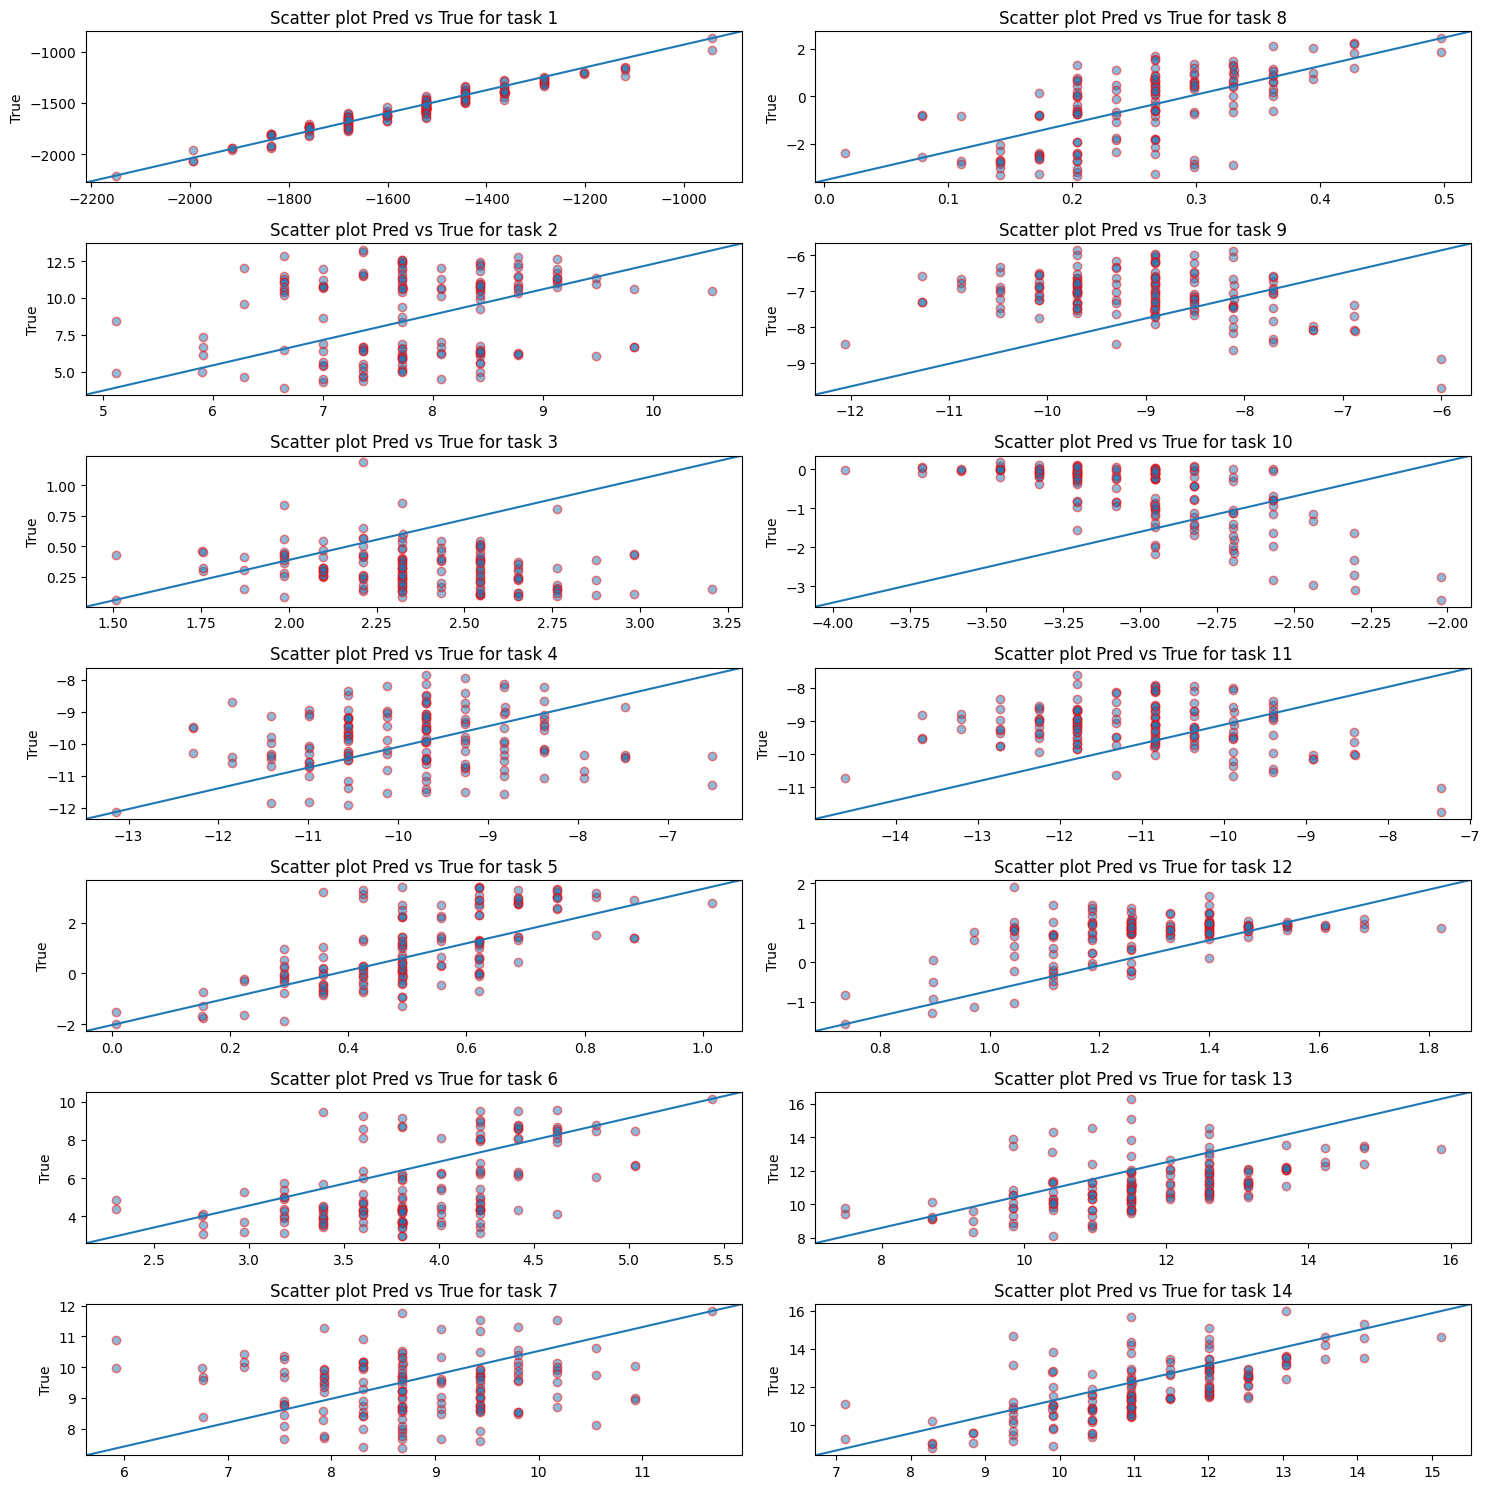

In [59]:
print_scatterplot(pred,y_test)

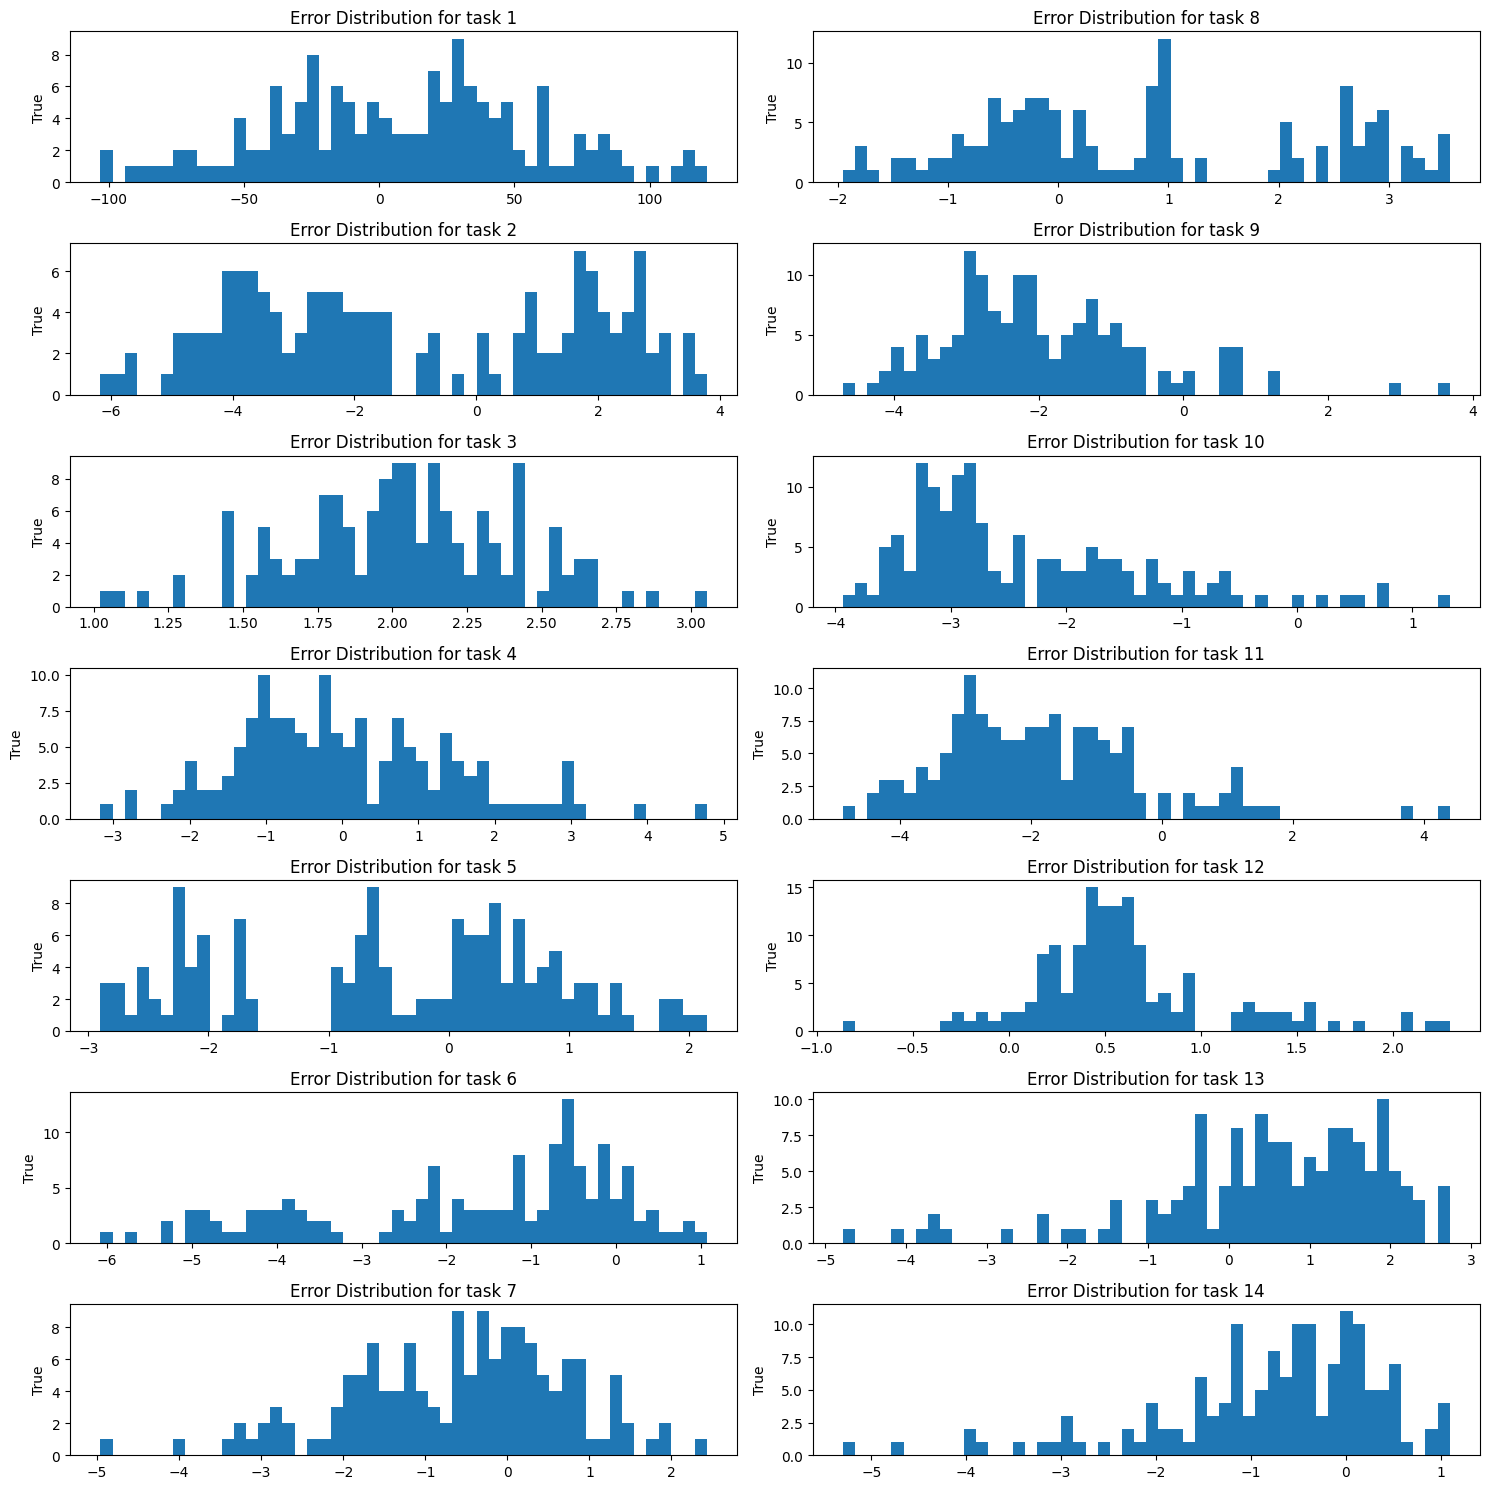

In [60]:
# error distribution
print_error_dist(pred,y_test)


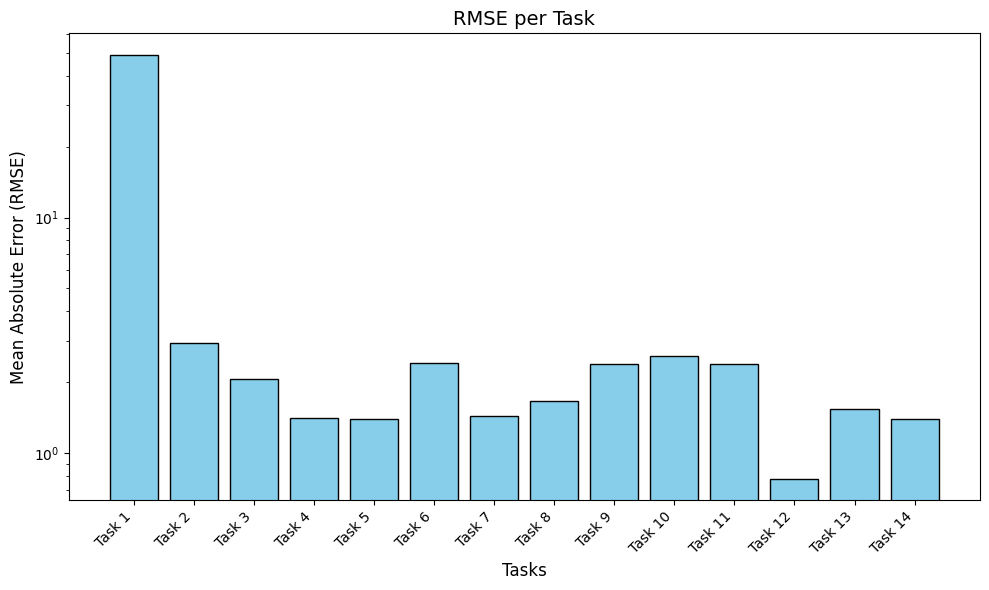

In [61]:
print_margin_dist(pred,y_test)



# Use validation set as early stopping to avoid overfitting

In [62]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [64]:
def train_one_epoch(
          data,
          model,
          criterion,
          optimizer,
          device):
    # set training mode
    model.train()
    # batch loss
    epoch_loss = 0
    n_batches=0

    for batch in data:
        optimizer.zero_grad()

        _ = add_graph_features(batch)
        batch = batch.to(device)
        n_edges = batch.edge_index.shape[1]

        input = batch.x  # Node features for the entire batch
        edge_features = batch.edge_attr.view(n_edges,-1)
        adj = torch_geometric.utils.to_dense_adj(batch.edge_index)

        x, edge, b = input, adj, batch.batch


        out = model(x, edge,edge_features,b)
        # compute the loss
        loss = criterion(out, batch.y)
        # compute gradients
        loss.backward()
        # optimize
        optimizer.step()

        # Accumulate loss for this batch
        epoch_loss += loss.item()
        n_batches +=1

    return epoch_loss/n_batches








In [65]:
def val_one_epoch(
          data,
          model,
          criterion,
          device):
    # set training mode
    model.eval()
    epoch_loss = 0
    n_batches = 0
    with torch.no_grad():  # Disable gradient computation

      for batch in data:

          _ = add_graph_features(batch)
          batch = batch.to(device)
          n_edges = batch.edge_index.shape[1]

          input = batch.x
          edge_features = batch.edge_attr.view(n_edges,-1)
          adj = torch_geometric.utils.to_dense_adj(batch.edge_index)

          x, edge, b = input, adj, batch.batch


          out = model(x, edge,edge_features,b)
          # compute the loss
          loss = criterion(out, batch.y)
          # compute gradients

          # Accumulate loss for this batch
          epoch_loss += loss.item()
          n_batches += 1


    return epoch_loss/n_batches


In [66]:


def train_and_val(epochs, device, criterion, model, train_loader, val_loader, early_stopping):

  # initialize loss
  total_loss = 0
  loss_history = []
  validation_loss = []

  lr = 0.01
  wd = 5e-4
  opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # 5e-4
  model = model.to(device)



  for i in tqdm(range(epochs)):

    print(f"Epoch {i+1}/{epochs}")

    epoch_loss= train_one_epoch(
              data = train_loader,
              model = model,
              criterion = criterion,
              optimizer = opt,
              device = device)

    loss_history.append(epoch_loss)
    total_loss += epoch_loss

    print(f"The current epoch loss is {epoch_loss:.4f}")
    print(f"The current loss is {total_loss:.4f}")


    # validation
    epoch_validate_loss = val_one_epoch(model = model,
                                            data = val_loader,
                                            criterion = criterion,
                                            device = device)
    validation_loss.append(epoch_validate_loss)

    print(f"The current validation epoch loss is {epoch_validate_loss:.4f}")

    # early stopping
    early_stopping(epoch_loss, epoch_validate_loss)
    print(f"current delta {epoch_validate_loss-epoch_loss}")
    print(f" delta target {early_stopping.min_delta}")
    print(f"current counter {early_stopping.counter}/{early_stopping.tolerance}")

    if early_stopping.early_stop:
        print("We are at epoch:", i)
        break
  return total_loss, loss_history, validation_loss



In [67]:
criterion = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
in_features = 4
early_stopping = EarlyStopping(tolerance=5, min_delta=1000)

model = MultiHeadGat2(
    num_heads=3,
    in_features=in_features,
    hidden_features=64,
    out_features=14,  # number of classes
    dropout=0.6,
    alpha=0.2,
    concat=True,
    pooling_type='mean',
    is_layerNorm = False,
    residual = True
)

total_loss, loss_history, validation_loss = train_and_val(epochs = 10,
                                                          device = device,
                                                          criterion=criterion,
                                                          model=model,
                                                          train_loader=train_loader,
                                                          val_loader=val_loader,
                                                          early_stopping = early_stopping)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
The current epoch loss is 12315.0648
The current loss is 12315.0648


 10%|█         | 1/10 [00:23<03:30, 23.37s/it]

The current validation epoch loss is 198.7309
current delta -12116.333878215248
 delta target 1000
current counter 0/5
Epoch 2/10
The current epoch loss is 763.1940
The current loss is 13078.2588


 20%|██        | 2/10 [00:43<02:51, 21.44s/it]

The current validation epoch loss is 196.1998
current delta -566.9941569228911
 delta target 1000
current counter 0/5
Epoch 3/10
The current epoch loss is 706.3182
The current loss is 13784.5770


 30%|███       | 3/10 [01:04<02:28, 21.19s/it]

The current validation epoch loss is 196.0420
current delta -510.27617183286725
 delta target 1000
current counter 0/5
Epoch 4/10
The current epoch loss is 684.8759
The current loss is 14469.4529


 40%|████      | 4/10 [01:26<02:08, 21.48s/it]

The current validation epoch loss is 206.8947
current delta -477.98122994344044
 delta target 1000
current counter 0/5
Epoch 5/10
The current epoch loss is 675.3073
The current loss is 15144.7601


 50%|█████     | 5/10 [01:46<01:45, 21.11s/it]

The current validation epoch loss is 199.6373
current delta -475.6699922303013
 delta target 1000
current counter 0/5
Epoch 6/10
The current epoch loss is 730.0804
The current loss is 15874.8406


 60%|██████    | 6/10 [02:07<01:24, 21.10s/it]

The current validation epoch loss is 293.8629
current delta -436.2174941565603
 delta target 1000
current counter 0/5
Epoch 7/10
The current epoch loss is 703.1754
The current loss is 16578.0160


 70%|███████   | 7/10 [02:27<01:02, 20.72s/it]

The current validation epoch loss is 300.2327
current delta -402.9427558487489
 delta target 1000
current counter 0/5
Epoch 8/10
The current epoch loss is 703.3874
The current loss is 17281.4034


 80%|████████  | 8/10 [02:51<00:43, 21.85s/it]

The current validation epoch loss is 226.3342
current delta -477.05323337439216
 delta target 1000
current counter 0/5
Epoch 9/10
The current epoch loss is 684.3570
The current loss is 17965.7604


 90%|█████████ | 9/10 [03:13<00:21, 21.63s/it]

The current validation epoch loss is 197.9018
current delta -486.45524155787615
 delta target 1000
current counter 0/5
Epoch 10/10
The current epoch loss is 697.4534
The current loss is 18663.2137


100%|██████████| 10/10 [03:34<00:00, 21.41s/it]

The current validation epoch loss is 205.0202
current delta -492.433125069885
 delta target 1000
current counter 0/5


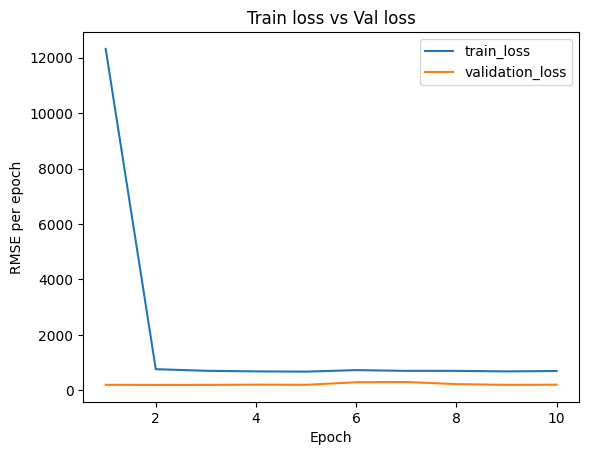

In [70]:
fig , ax = plt.subplots()
x = range(1, 10 +1)
ax.plot(x,loss_history, label='train_loss')
ax.plot(x,validation_loss, label='validation_loss')

ax.legend()
ax.set_title("Train loss vs Val loss")
ax.set_ylabel("RMSE per epoch")
ax.set_xlabel("Epoch")
plt.show()

In [71]:
RMSE, pred, y_test = test3(test_loader, model, device)


In [72]:
RMSE

0.4668552661764211

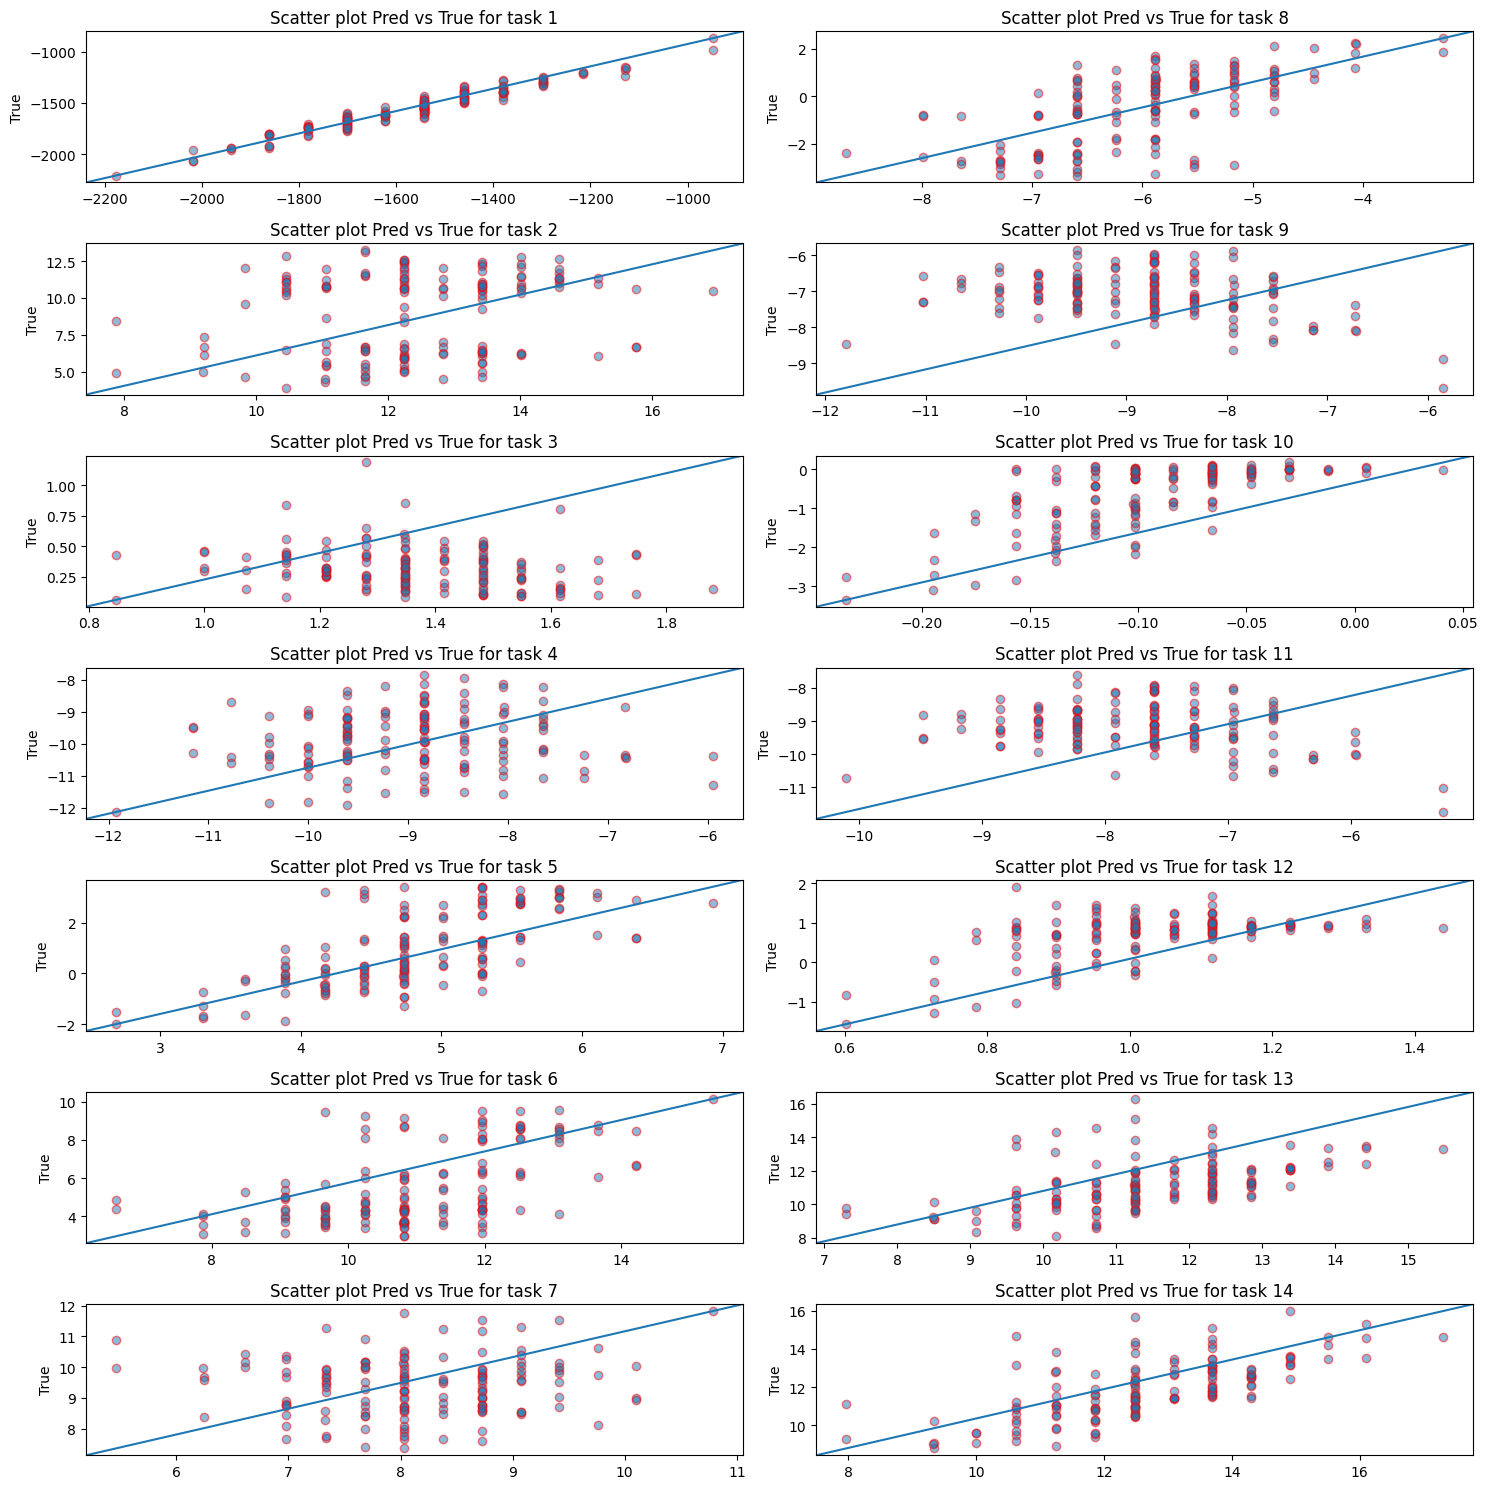

In [73]:
print_scatterplot(pred,y_test)

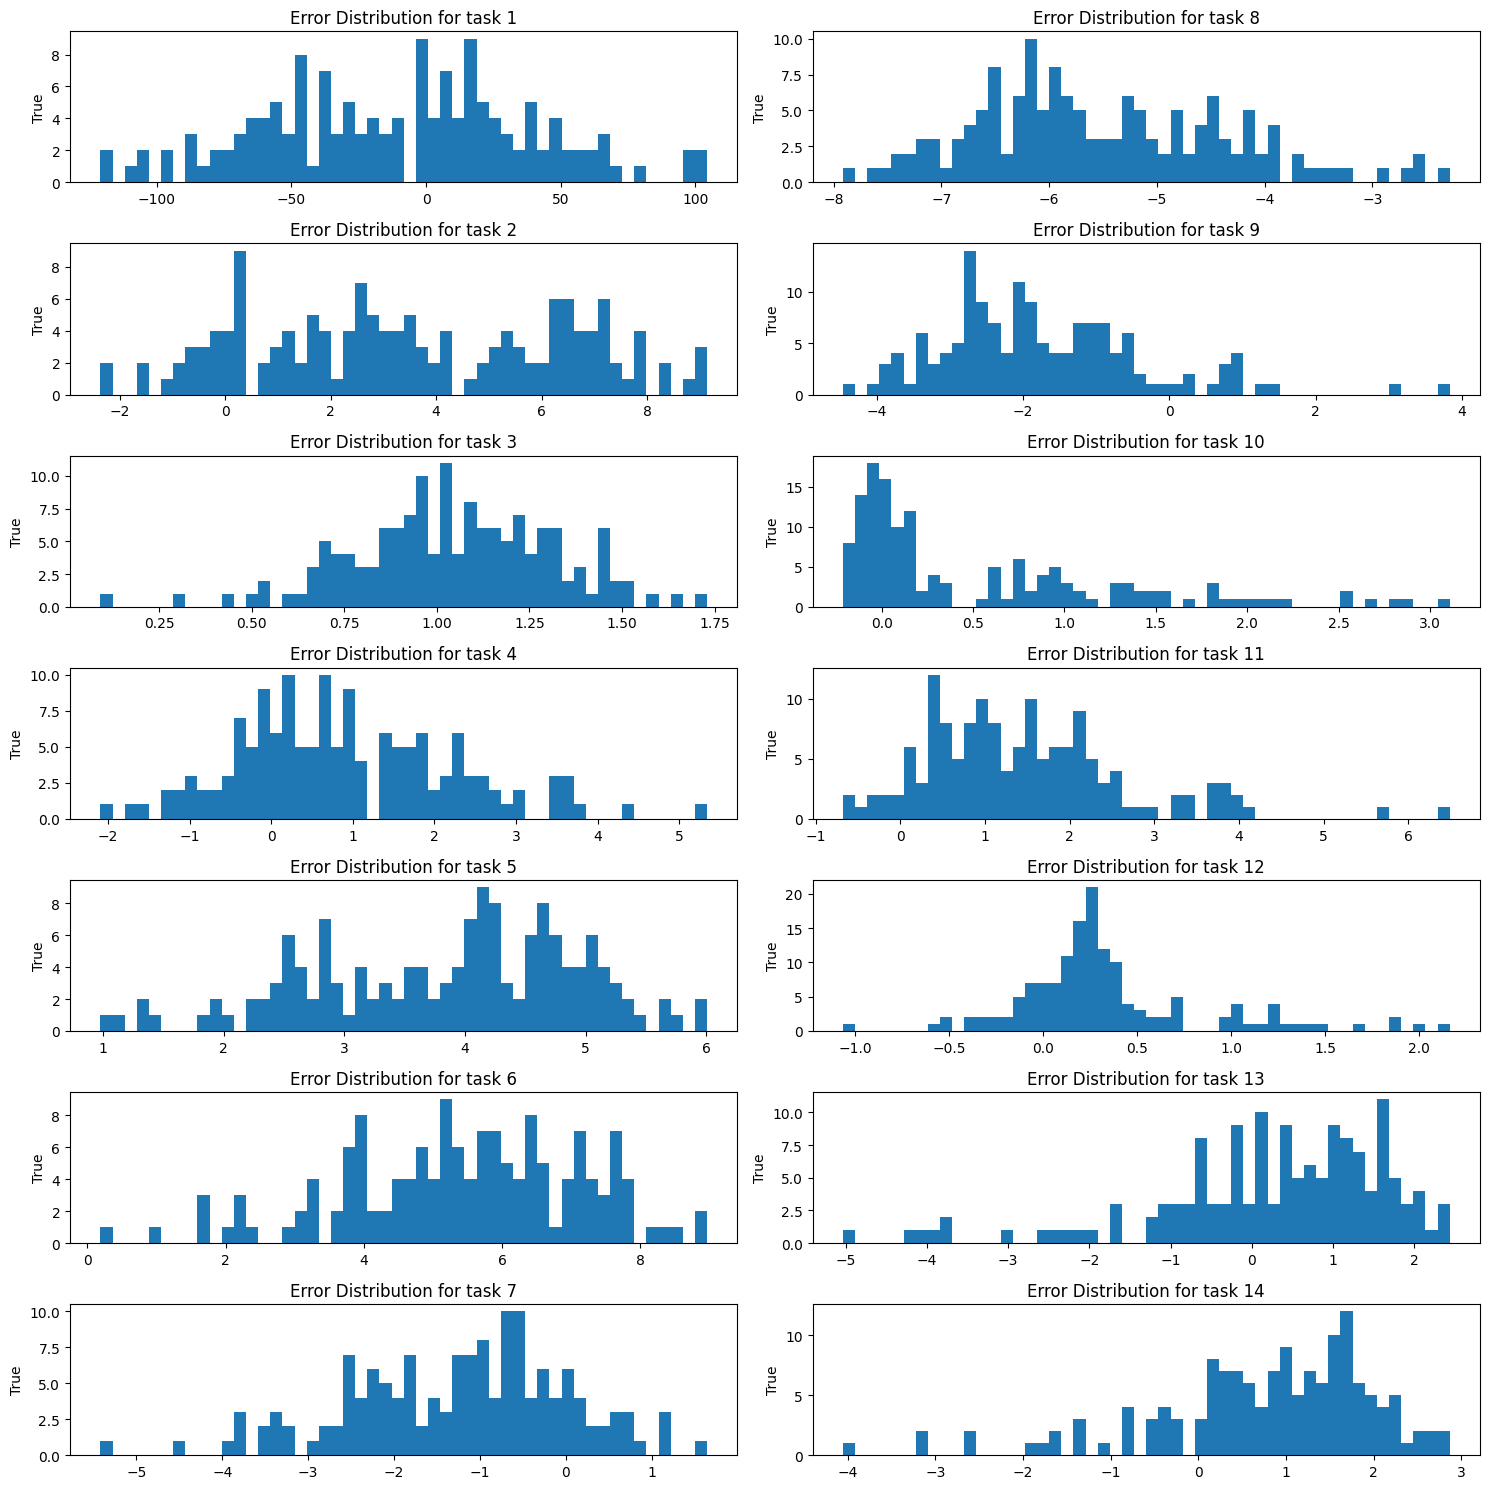

In [74]:
# error distribution
print_error_dist(pred,y_test)


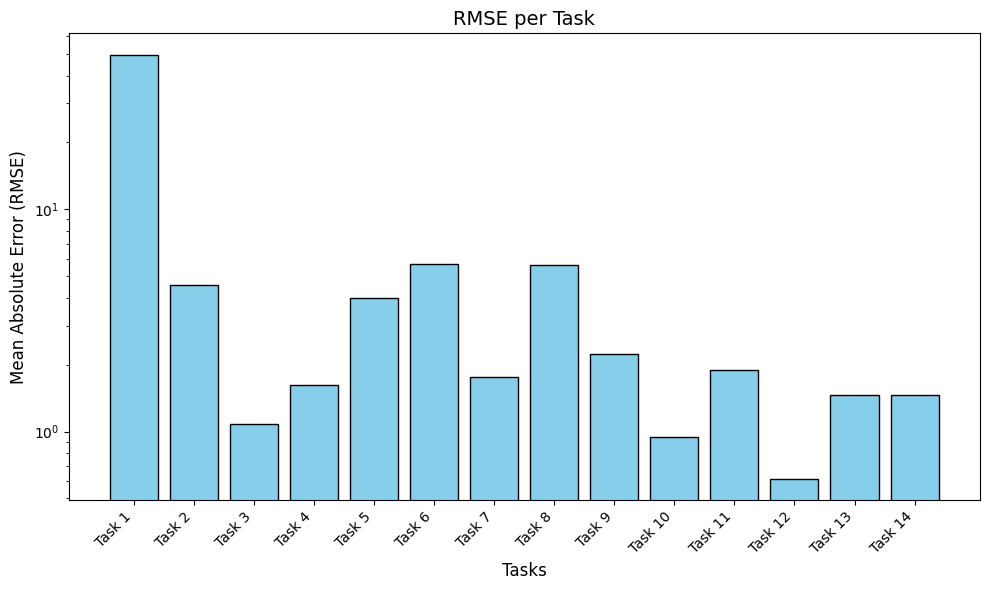

In [75]:
print_margin_dist(pred,y_test)



# Comparative analysis

In [ ]:

in_features = 3
epochs = 10

# MultiHeadGat with random node features, concat, mean pooling
model1 = MultiHeadGat(num_heads=3,in_features=in_features,hidden_features=64,out_features=14,dropout=0.6,alpha=0.2,
                      concat=True,pooling_type='mean',is_layerNorm = False,residual = False)


# MultiHeadGat with random node features, concat, mean pooling, non layer norm, residual connections
model2 = MultiHeadGat(num_heads=3,in_features=in_features,hidden_features=64,out_features=14,dropout=0.6,alpha=0.2,
                      concat=True,pooling_type='mean',is_layerNorm = False,residual = True)

# MultiHeadGat with random node features, concat, mean pooling, layer norm, residual connections
model3 = MultiHeadGat(num_heads=3,in_features=in_features,hidden_features=64,out_features=14,dropout=0.6,alpha=0.2,
                      concat=True,pooling_type='mean',is_layerNorm = True ,residual = True)

# MultiHeadGat with random node features and edge features, concat, mean pooling, layer norm, residual connections

model4 = MultiHeadGat2(num_heads=3,in_features=in_features,hidden_features=64,out_features=14,dropout=0.6,alpha=0.2,
                       concat=True, pooling_type='mean', is_layerNorm = True, residual = True)

# MultiHeadGat with handcrafted node features and edge features, concat, mean pooling, layer norm, residual connections

model5 = MultiHeadGat2(num_heads=3,in_features=4,hidden_features=64,out_features=14,dropout=0.6,alpha=0.2,
                       concat=True, pooling_type='mean', is_layerNorm = True, residual = True)



In [ ]:
epoches = 10
criterion = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


loss_model1, pred_model1,loss_history_model1 = train(epoch =epochs,data = train_loader,
                                                     model = model1,criterion = criterion,
                                                     lr = 0.01,wd = 5e-4,device = device)

loss_model2, pred_model2,loss_history_model2 = train(epoch =epochs,data = train_loader,
                                                     model = model2,criterion = criterion,
                                                     lr = 0.01,wd = 5e-4,device = device)
loss_model3, pred_model3,loss_history_model3 = train(epoch =epochs,data = train_loader,
                                                     model = model3,criterion = criterion,
                                                     lr = 0.01,wd = 5e-4,device = device)

loss_model4, pred_model4,loss_history_model4 = train2(epoch =epochs,data = train_loader,
                                                     model = model4,criterion = criterion,
                                                     lr = 0.01,wd = 5e-4,device = device)
loss_model5, pred_model5,loss_history_model5 = train3(epoch =epochs,data = train_loader,
                                                     model = model5,criterion = criterion,
                                                     lr = 0.01,wd = 5e-4,device = device)


 10%|█         | 1/10 [00:09<01:25,  9.50s/it]

The current loss is 32264.0387


 20%|██        | 2/10 [00:13<00:51,  6.46s/it]

The current loss is 18642.1624


 30%|███       | 3/10 [00:17<00:37,  5.38s/it]

The current loss is 14085.2433


 40%|████      | 4/10 [00:22<00:29,  5.00s/it]

The current loss is 11708.5722


 50%|█████     | 5/10 [00:26<00:23,  4.68s/it]

The current loss is 10237.2123


 60%|██████    | 6/10 [00:30<00:17,  4.49s/it]

The current loss is 9236.3334


 70%|███████   | 7/10 [00:34<00:13,  4.44s/it]

The current loss is 8504.0113


 80%|████████  | 8/10 [00:39<00:08,  4.34s/it]

The current loss is 7944.0532


 90%|█████████ | 9/10 [00:43<00:04,  4.25s/it]

The current loss is 7504.7593


100%|██████████| 10/10 [00:47<00:00,  4.74s/it]


The current loss is 7142.9470


 10%|█         | 1/10 [00:04<00:38,  4.33s/it]

The current loss is 25047.3815


 20%|██        | 2/10 [00:08<00:35,  4.48s/it]

The current loss is 14775.1068


 30%|███       | 3/10 [00:13<00:31,  4.47s/it]

The current loss is 11313.8188


 40%|████      | 4/10 [00:17<00:26,  4.35s/it]

The current loss is 9552.3400


 50%|█████     | 5/10 [00:21<00:21,  4.28s/it]

The current loss is 8506.9918


 60%|██████    | 6/10 [00:26<00:17,  4.31s/it]

The current loss is 7808.6958


 70%|███████   | 7/10 [00:30<00:12,  4.24s/it]

The current loss is 7288.3626


 80%|████████  | 8/10 [00:34<00:08,  4.21s/it]

The current loss is 6906.9607


 90%|█████████ | 9/10 [00:38<00:04,  4.27s/it]

The current loss is 6605.5619


100%|██████████| 10/10 [00:42<00:00,  4.29s/it]


The current loss is 6362.4949


 10%|█         | 1/10 [00:04<00:38,  4.24s/it]

The current loss is 22845.8440


 20%|██        | 2/10 [00:09<00:36,  4.59s/it]

The current loss is 13510.5585


 30%|███       | 3/10 [00:13<00:30,  4.42s/it]

The current loss is 10285.3810


 40%|████      | 4/10 [00:17<00:25,  4.33s/it]

The current loss is 8576.0945


 50%|█████     | 5/10 [00:21<00:21,  4.36s/it]

The current loss is 7531.1959


 60%|██████    | 6/10 [00:26<00:17,  4.29s/it]

The current loss is 6815.8979


 70%|███████   | 7/10 [00:30<00:12,  4.25s/it]

The current loss is 6290.7589


 80%|████████  | 8/10 [00:35<00:08,  4.42s/it]

The current loss is 5893.8657


 90%|█████████ | 9/10 [00:39<00:04,  4.46s/it]

The current loss is 5568.2788


100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


The current loss is 5314.4229


 10%|█         | 1/10 [00:05<00:51,  5.76s/it]

The current loss is 21633.9765


 20%|██        | 2/10 [00:11<00:44,  5.60s/it]

The current loss is 12861.5504


 30%|███       | 3/10 [00:16<00:39,  5.65s/it]

The current loss is 9903.0081


 40%|████      | 4/10 [00:22<00:33,  5.58s/it]

The current loss is 8364.1315


 50%|█████     | 5/10 [00:28<00:28,  5.67s/it]

The current loss is 7395.4784


 60%|██████    | 6/10 [00:33<00:22,  5.62s/it]

The current loss is 6727.3603


 70%|███████   | 7/10 [00:39<00:16,  5.66s/it]

The current loss is 6241.3884


 80%|████████  | 8/10 [00:45<00:11,  5.63s/it]

The current loss is 5881.4602


 90%|█████████ | 9/10 [00:50<00:05,  5.58s/it]

The current loss is 5579.6287


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


The current loss is 5349.7603


 10%|█         | 1/10 [00:18<02:47, 18.61s/it]

The current loss is 21516.3462


 20%|██        | 2/10 [00:38<02:33, 19.14s/it]

The current loss is 11211.7307


 30%|███       | 3/10 [01:05<02:40, 22.91s/it]

The current loss is 7743.5326


 40%|████      | 4/10 [01:31<02:24, 24.05s/it]

The current loss is 5999.5848


 50%|█████     | 5/10 [01:58<02:05, 25.09s/it]

The current loss is 4944.8891


 60%|██████    | 6/10 [02:16<01:31, 22.85s/it]

The current loss is 4237.3288


 70%|███████   | 7/10 [02:40<01:09, 23.27s/it]

The current loss is 3731.9638


 80%|████████  | 8/10 [03:08<00:49, 24.67s/it]

The current loss is 3351.1377


 90%|█████████ | 9/10 [03:30<00:23, 23.80s/it]

The current loss is 3056.9573


100%|██████████| 10/10 [03:49<00:00, 22.99s/it]

The current loss is 2826.7529


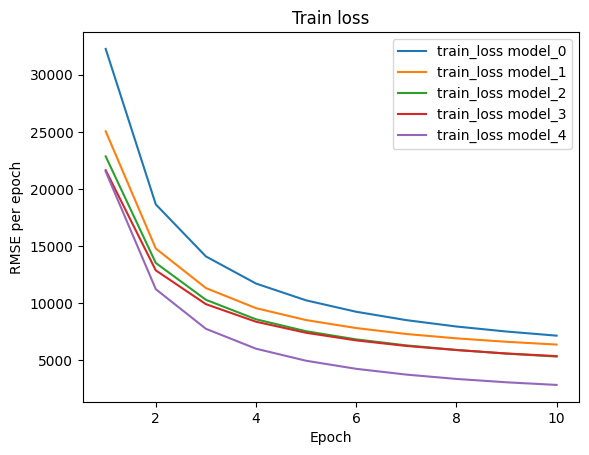

In [ ]:
lss = [loss_history_model1,loss_history_model2,loss_history_model3,loss_history_model4,loss_history_model5]

x = range(1, epochs +1)

fig,ax = plt.subplots()
plots = [ax.plot(x,lss[i], label='train_loss model_{}'.format(i)) for i in range(len(lss))]
for i in range(len(lss)):
  i
ax.legend()
ax.set_title("Train loss")
ax.set_ylabel("RMSE per epoch")
ax.set_xlabel("Epoch")
plt.show()


In [ ]:
RMSE1, pred1, y_test1 = test(test_loader, model1, device)
RMSE2, pred2, y_test2 = test(test_loader, model2, device)
RMSE3, pred3, y_test3 = test(test_loader, model3, device)
RMSE4, pred4, y_test4 = test2(test_loader, model4, device)
RMSE5, pred5, y_test5 = test3(test_loader, model5, device)

rmse = [RMSE1,RMSE2,RMSE3,RMSE4,RMSE5]
res = [(globals()[f"pred{i}"],globals()[f"y_test{i}"]) for i in range(1, 6)]

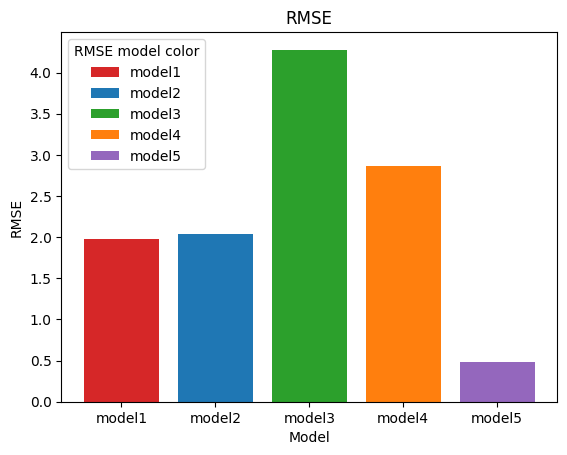

In [ ]:
fig, ax = plt.subplots()
x = range(1,6)
bar_labels = ['model1', 'model2', 'model3', 'model4', 'model5']
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple']

ax.bar(x, rmse, label = bar_labels, color=bar_colors)
ax.legend(title='RMSE model color')

ax.set_xticks(x)
ax.set_xticklabels(['model1', 'model2', 'model3', 'model4', 'model5'])
ax.set_title("RMSE")
ax.set_ylabel("RMSE")
ax.set_xlabel("Model")
plt.show()

Scatterplot of model 0


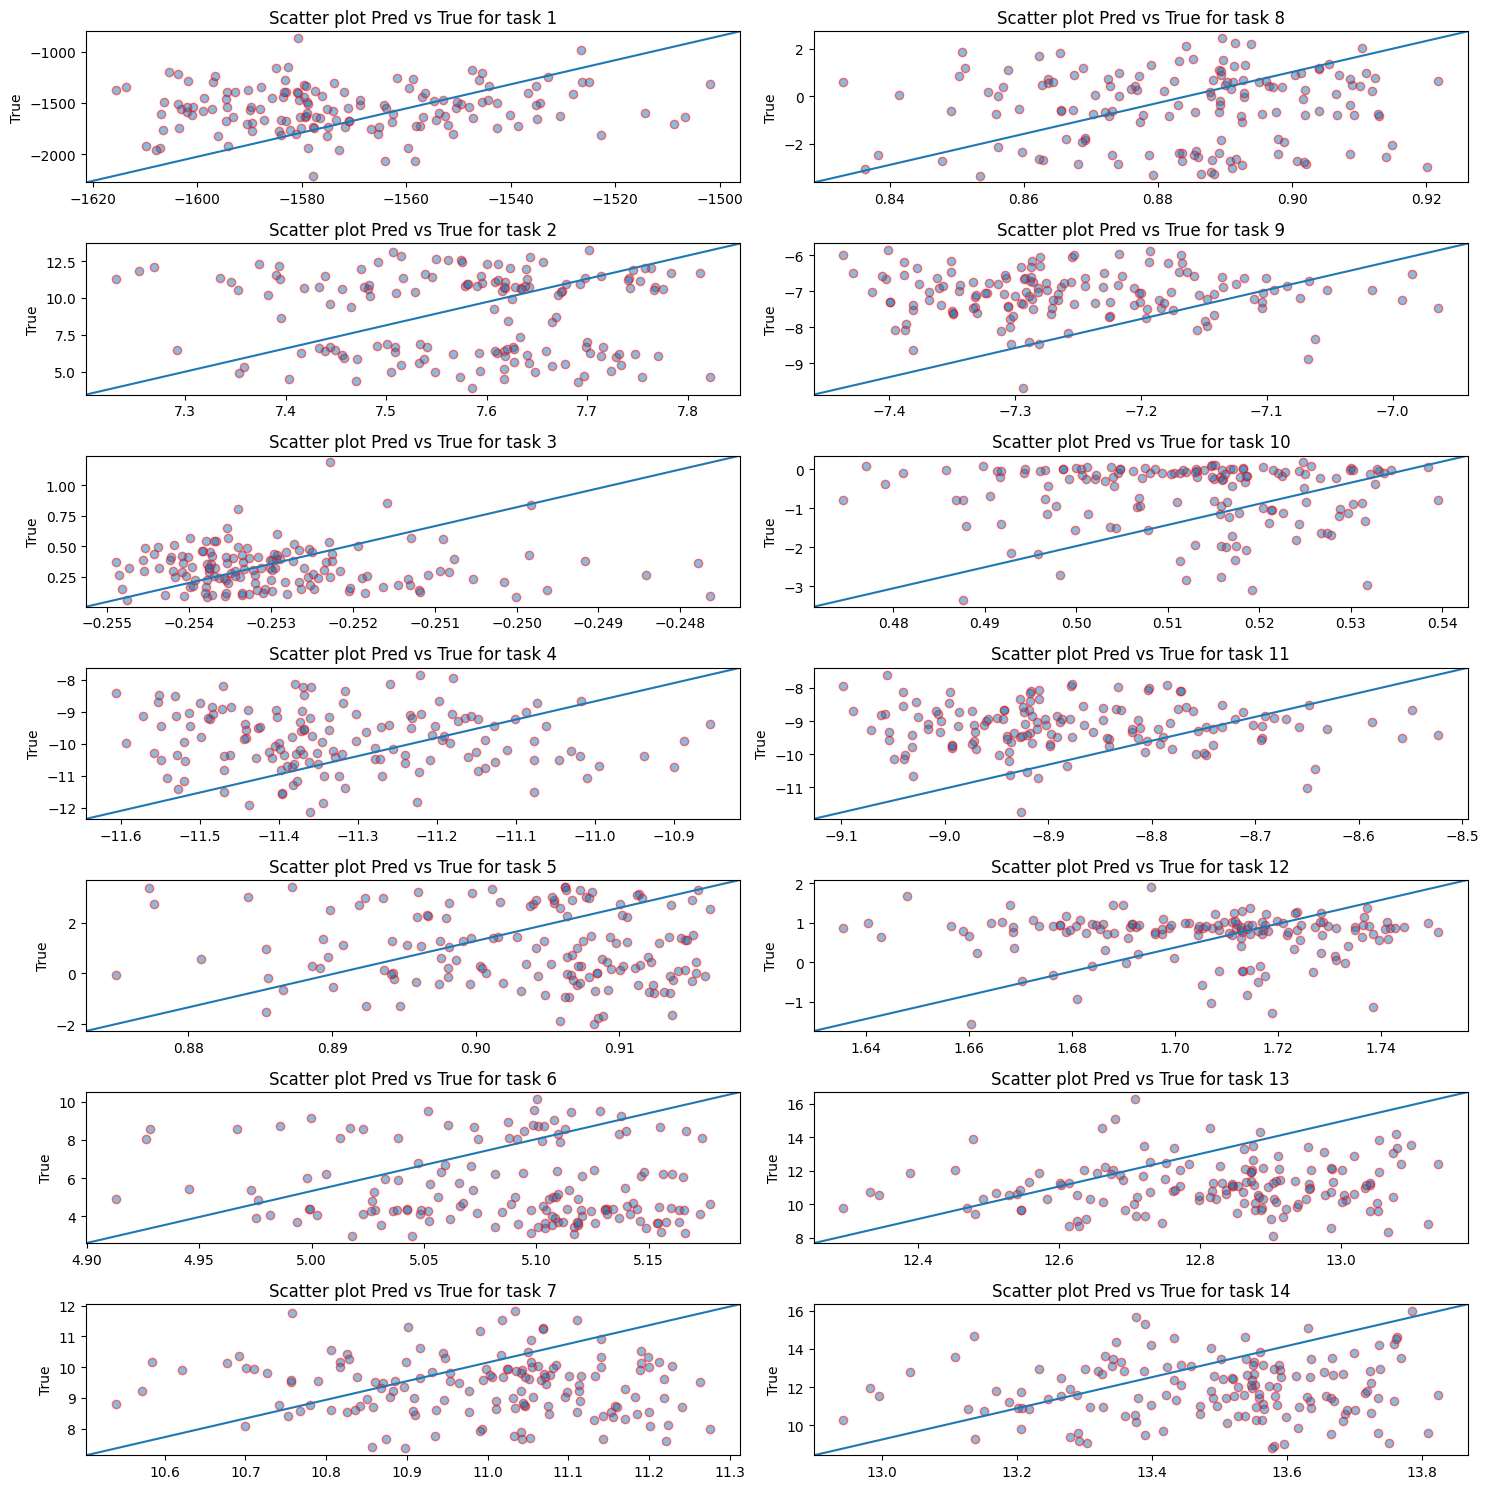

Scatterplot of model 1


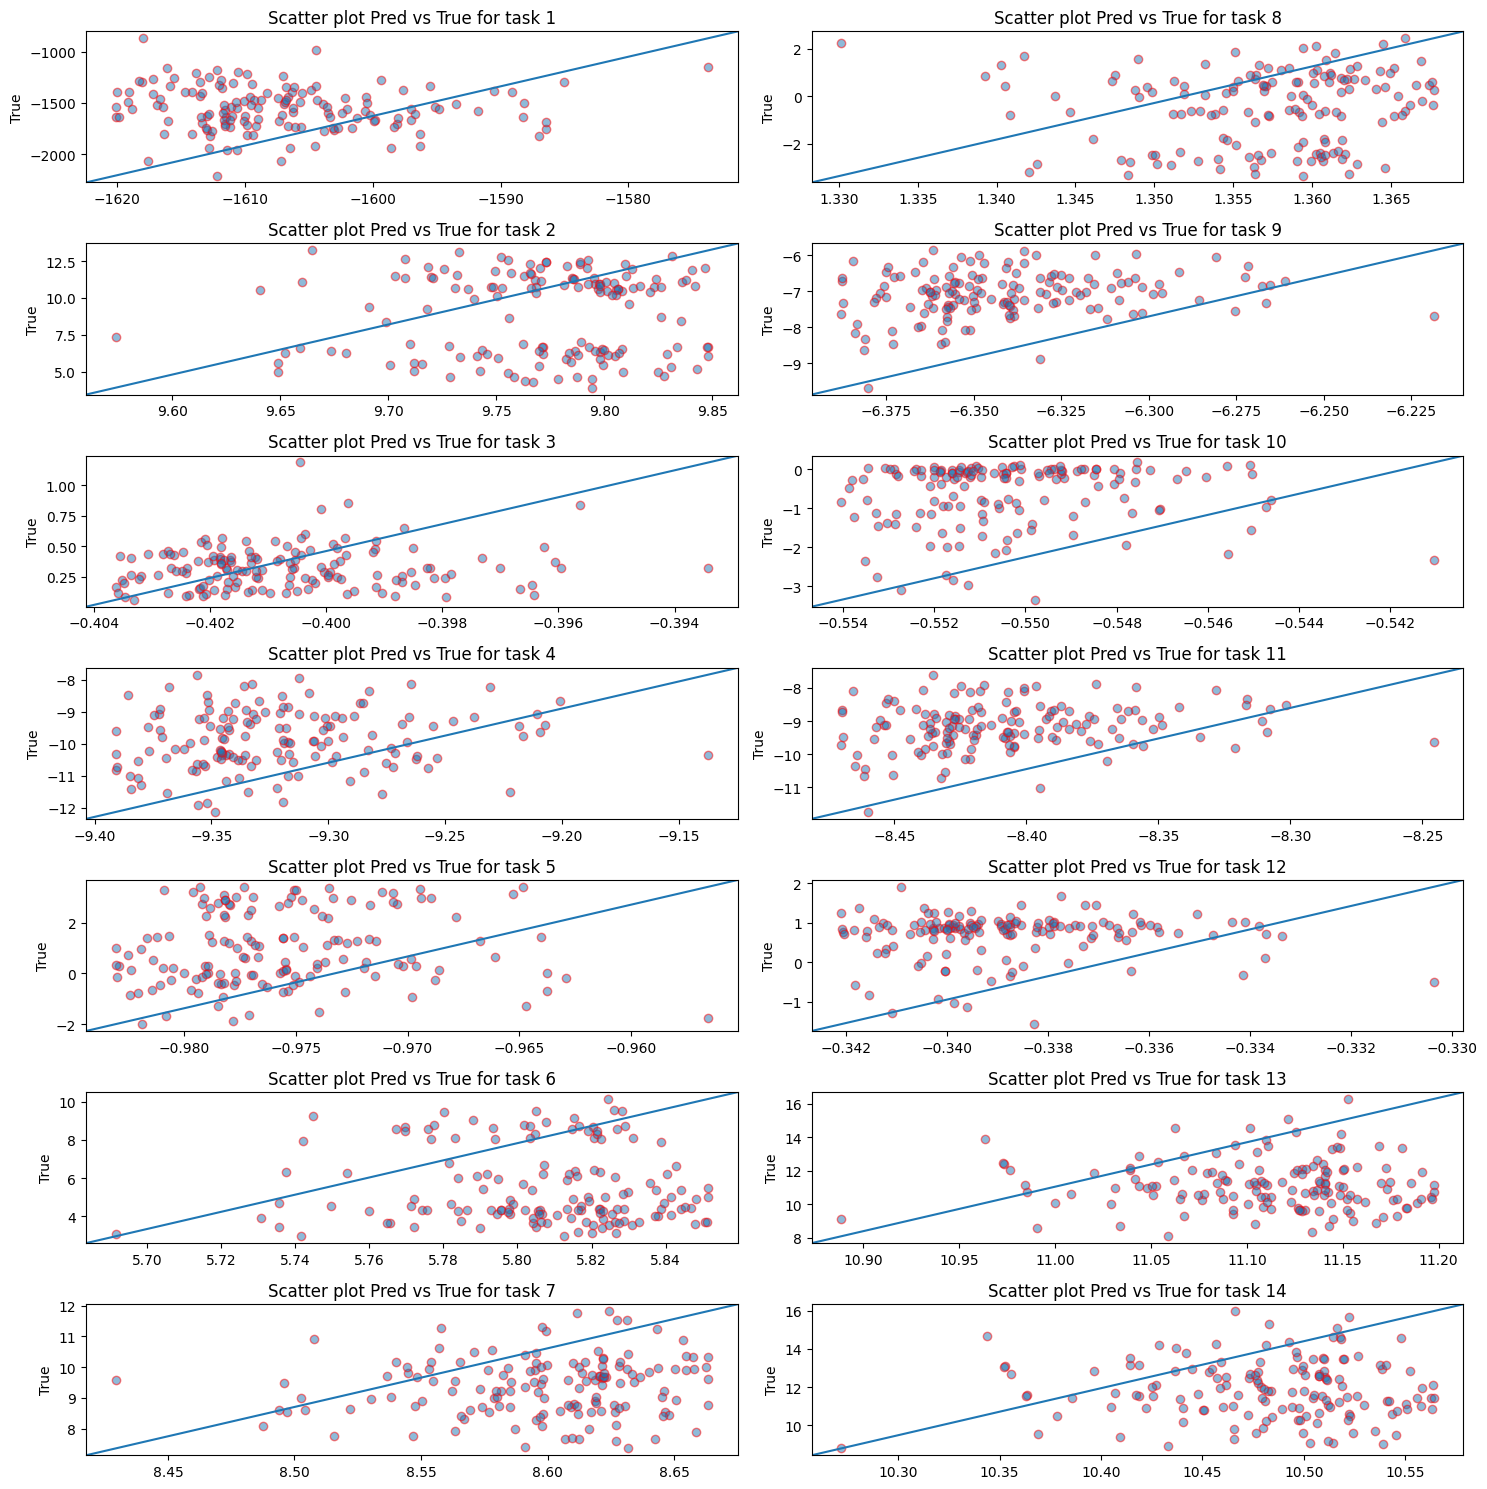

Scatterplot of model 2


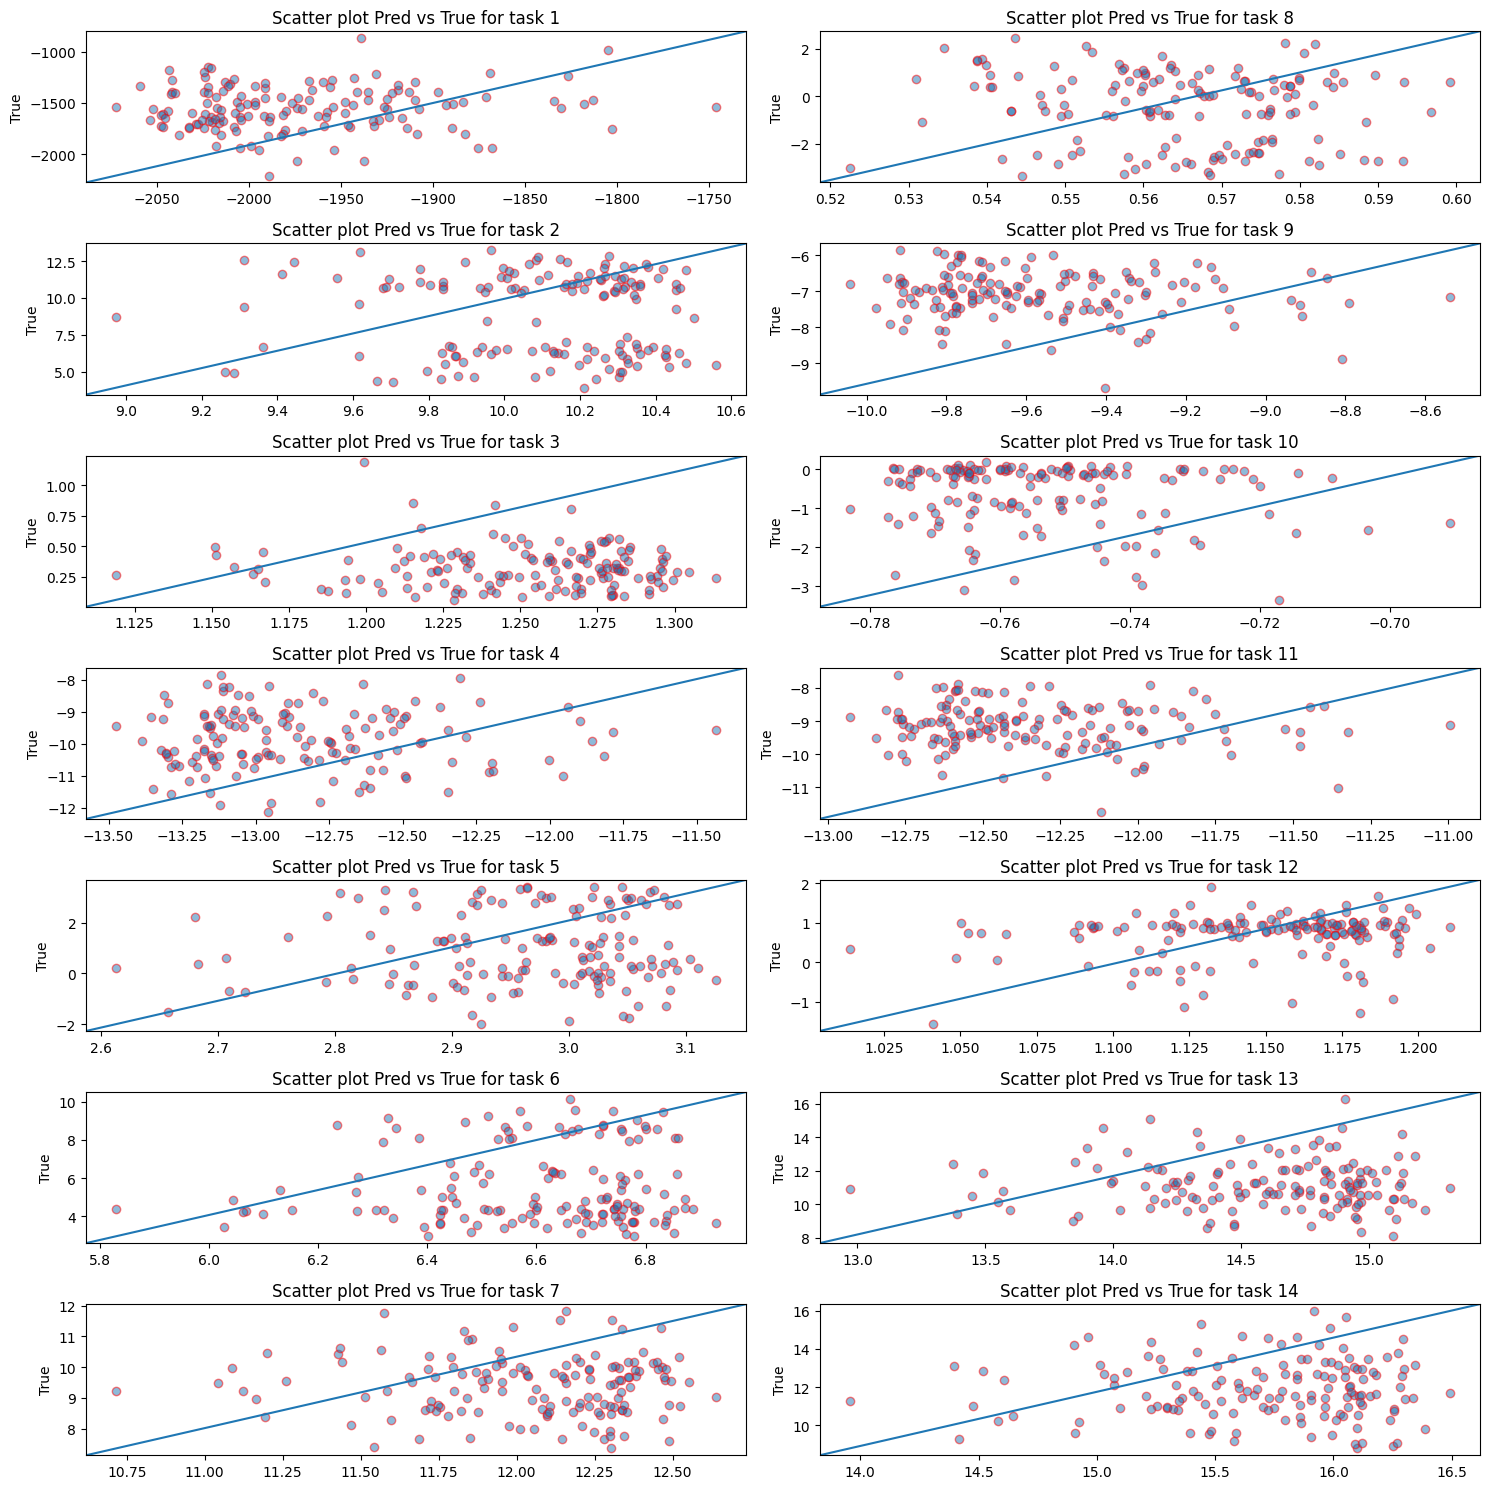

Scatterplot of model 3


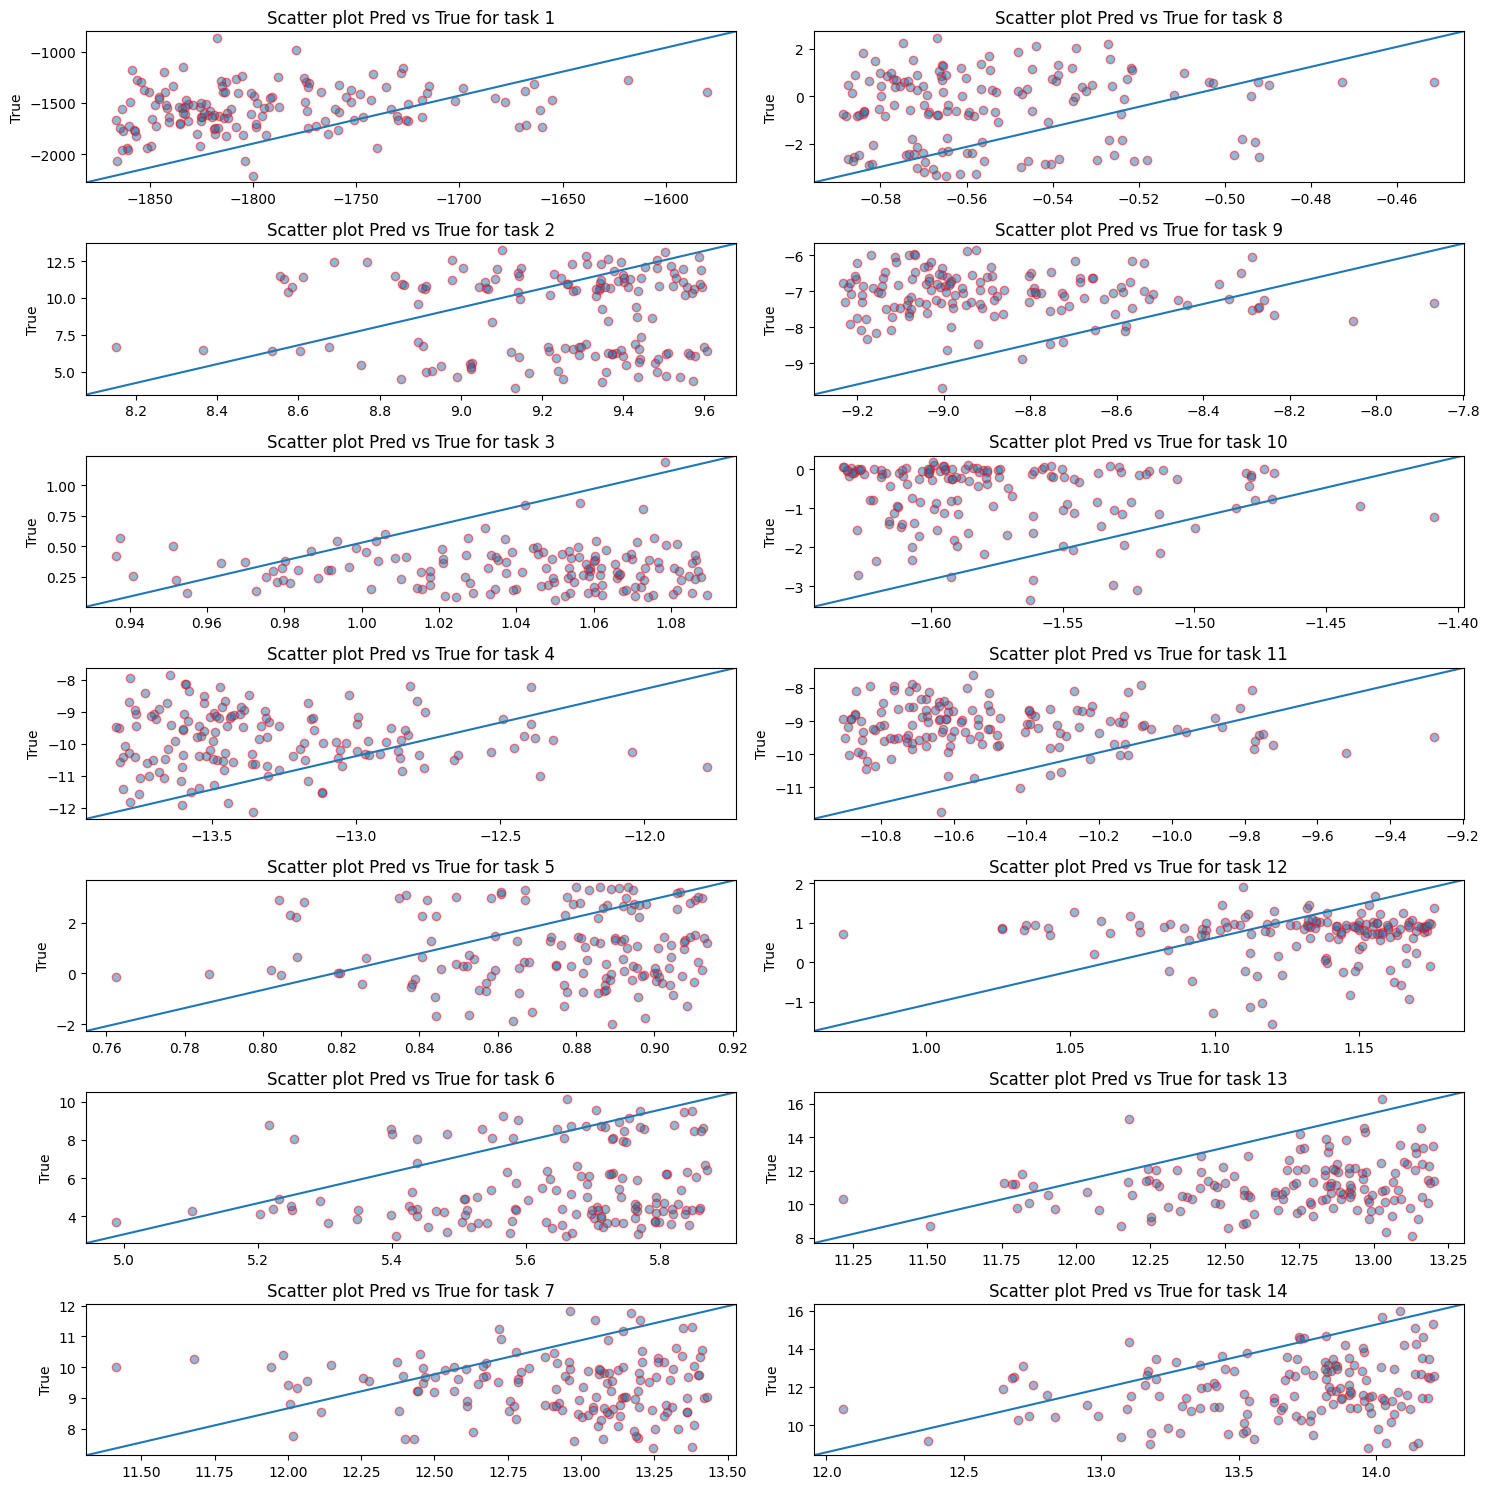

Scatterplot of model 4


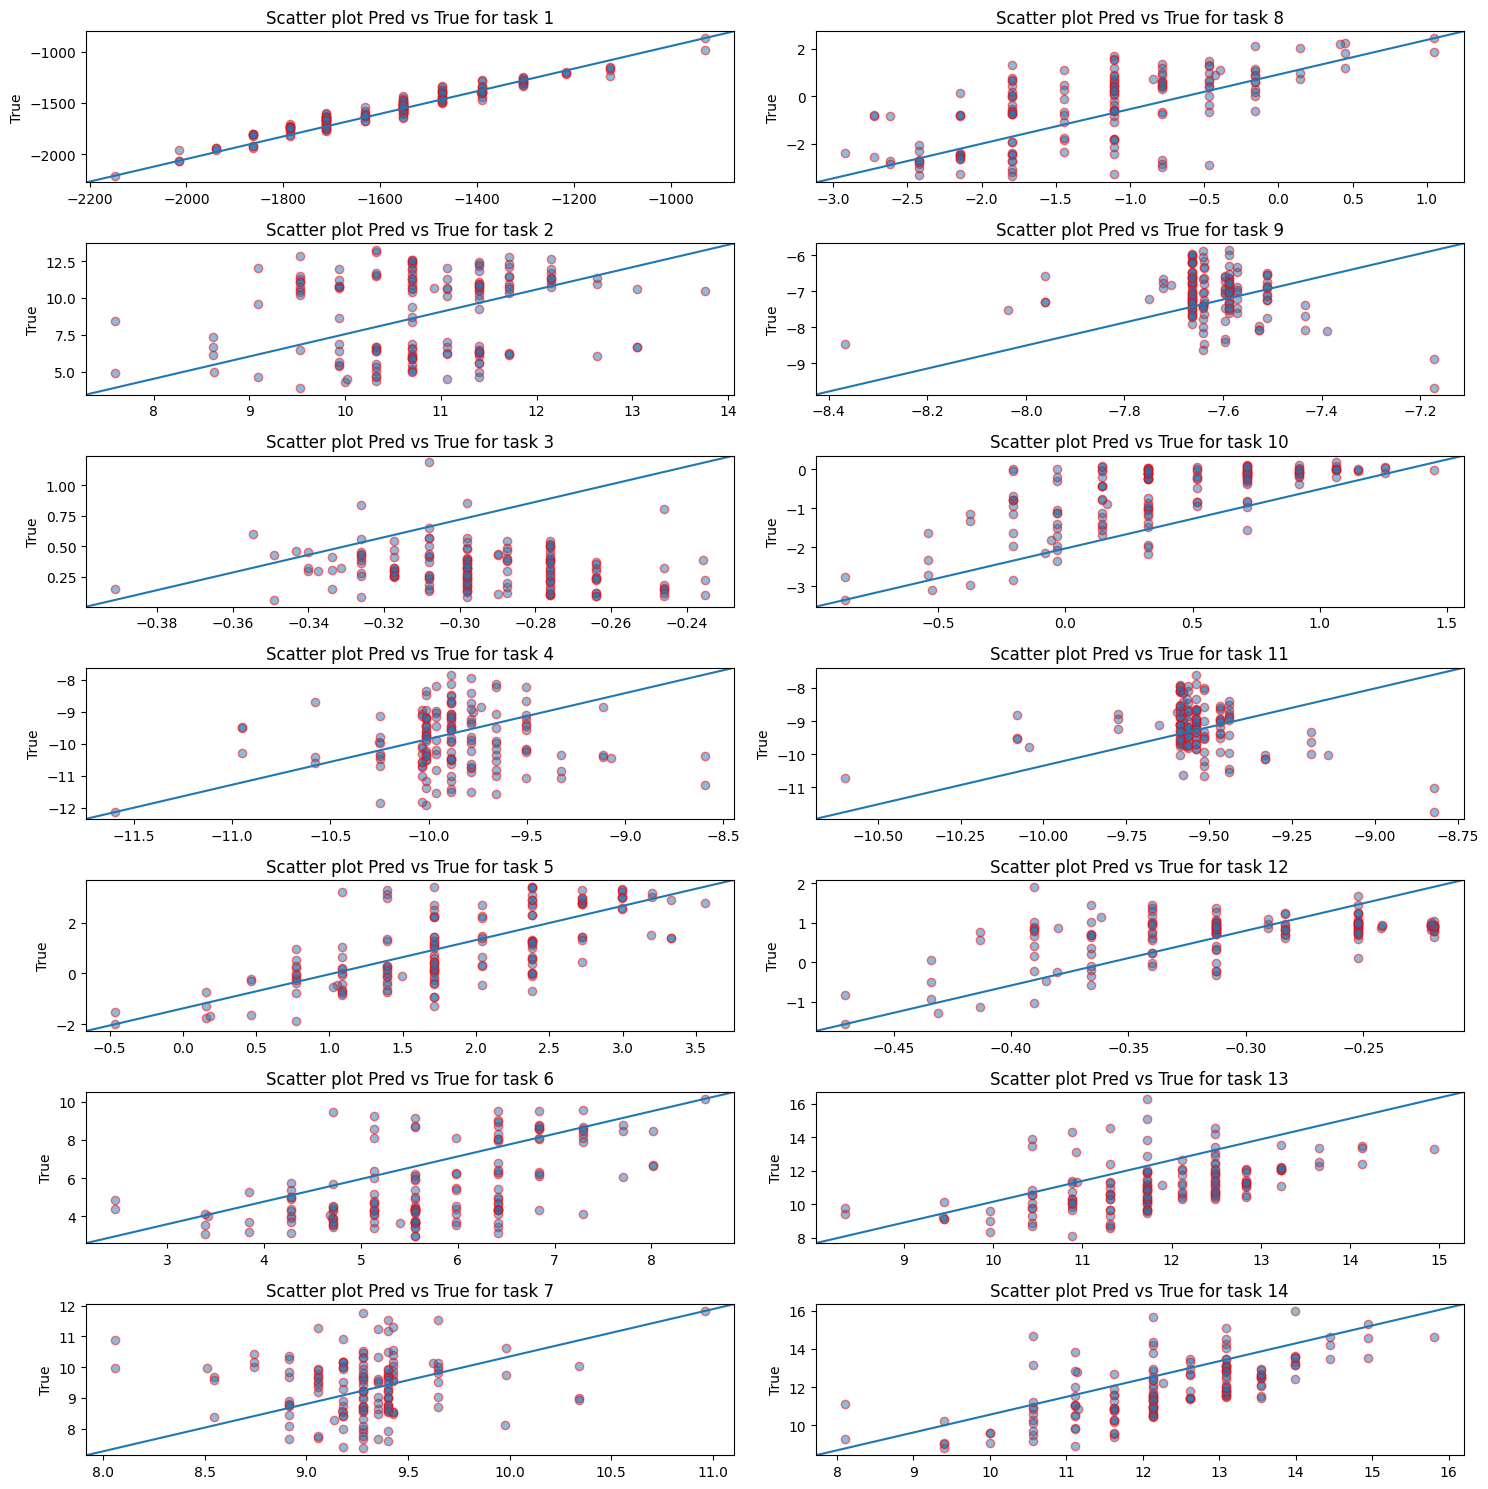

In [ ]:
for i, (p, y) in enumerate(res):
    print(f"Scatterplot of model {i+1}")
    print_scatterplot(p, y)


Error distribution of model 1


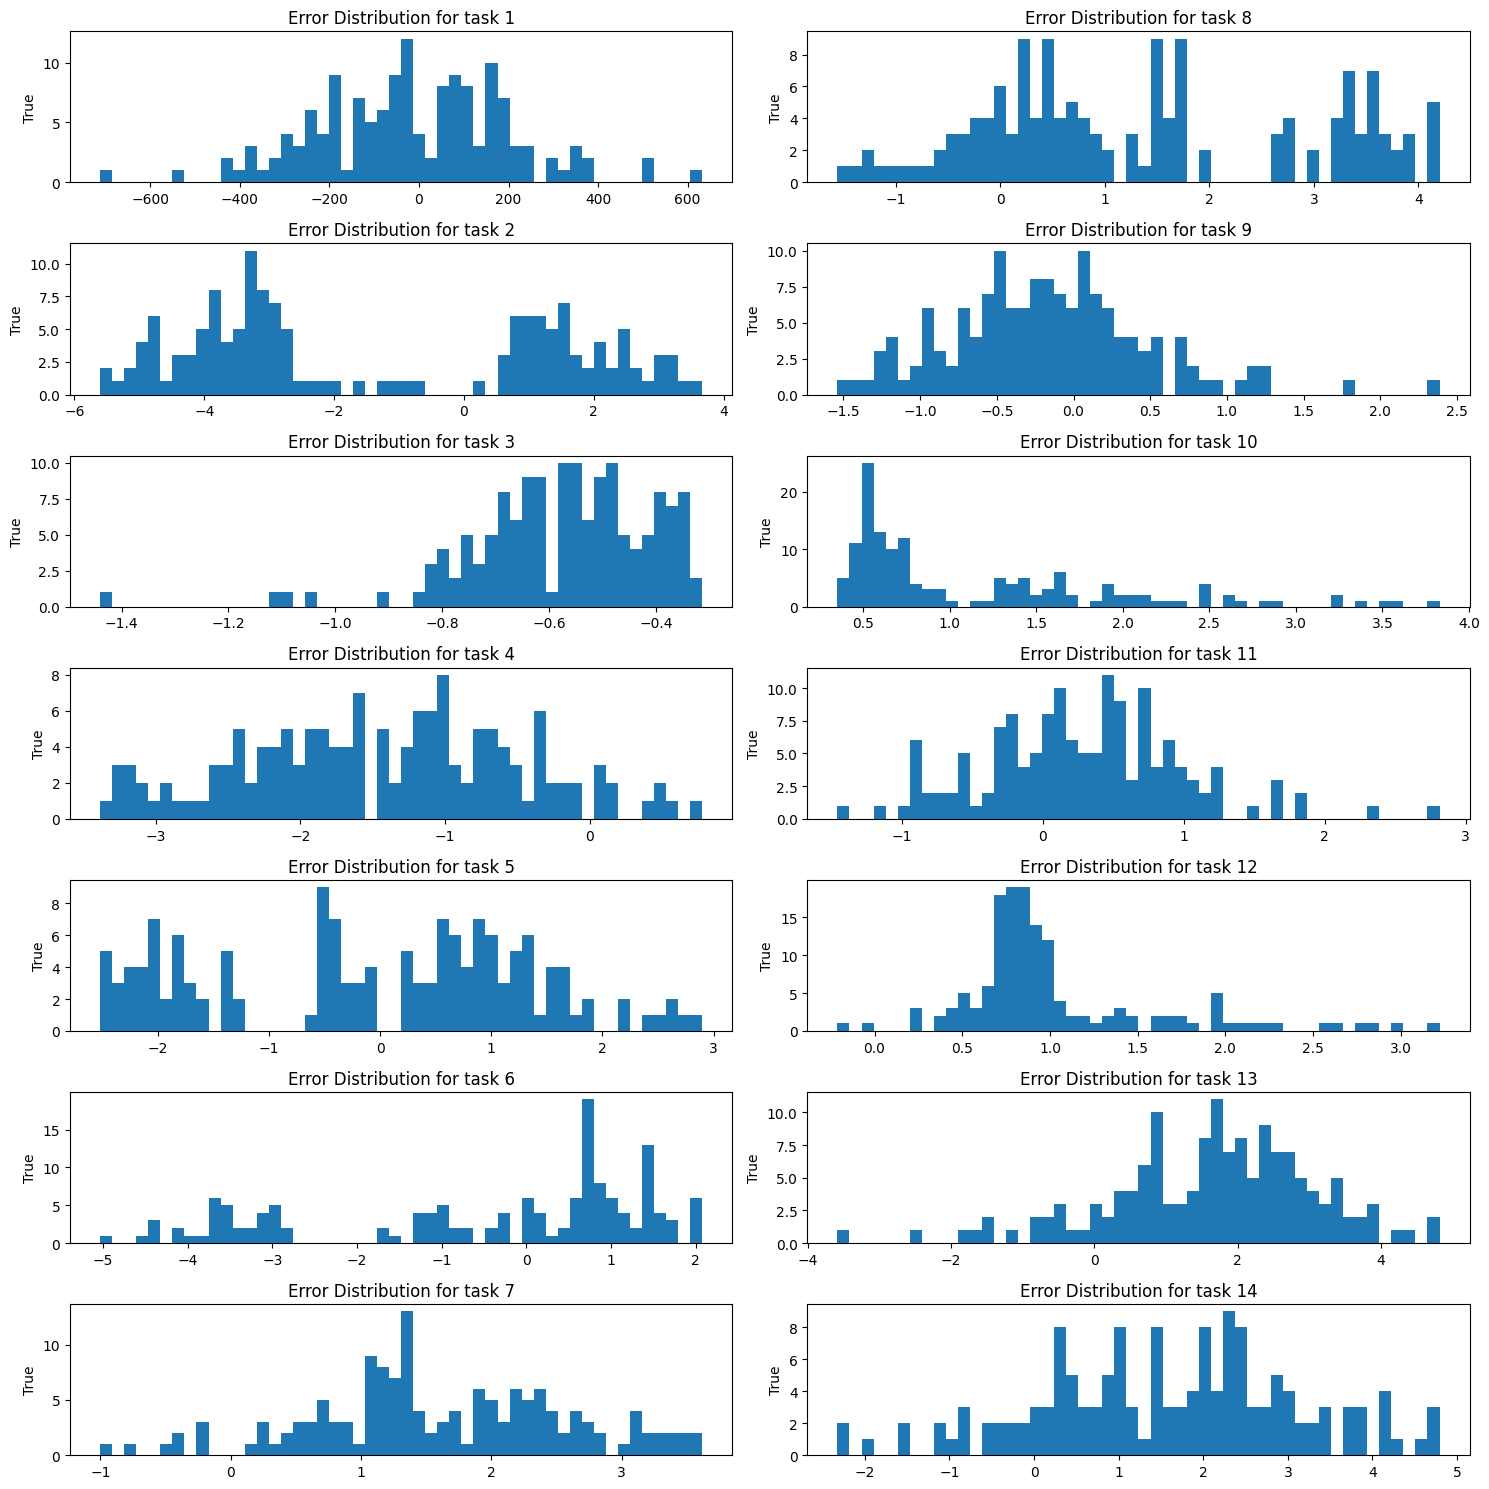

Error distribution of model 2


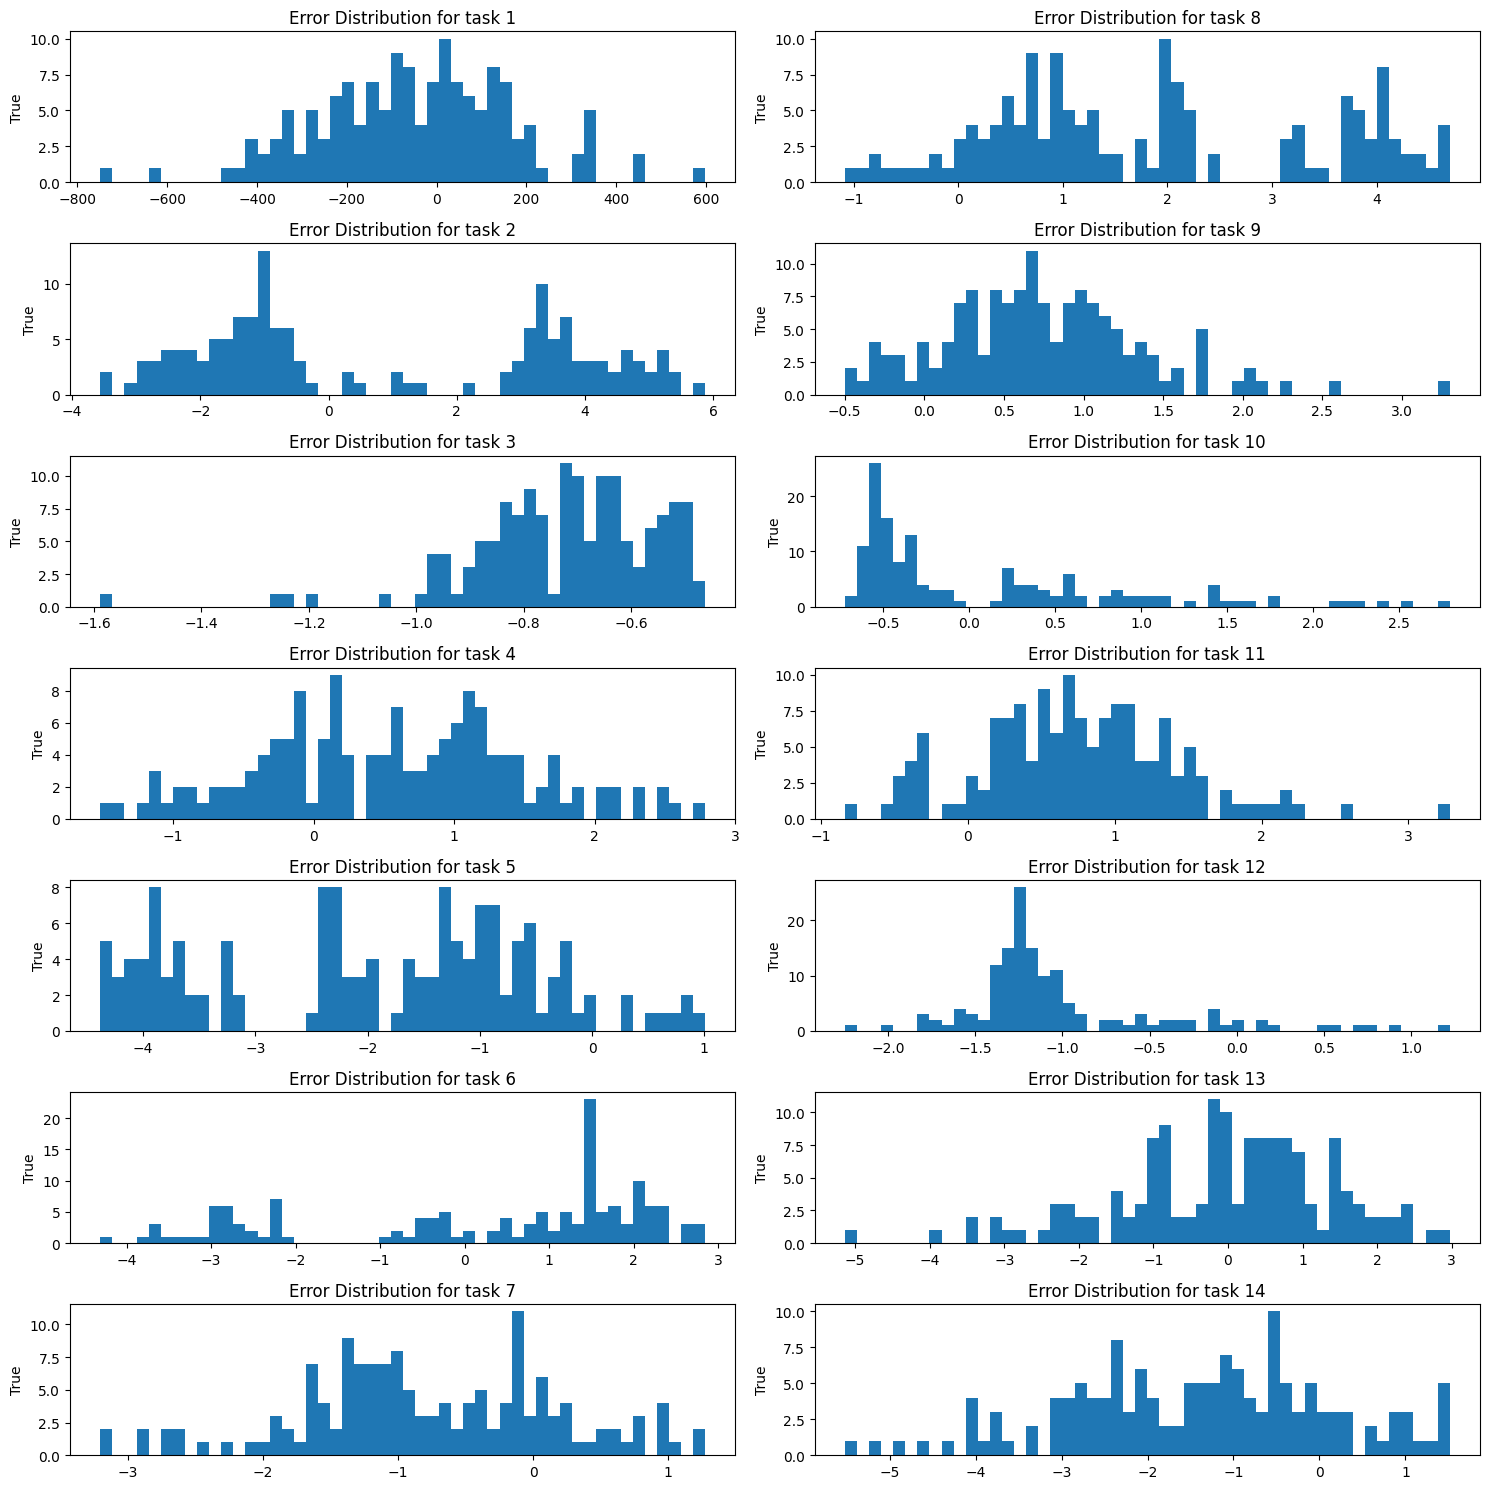

Error distribution of model 3


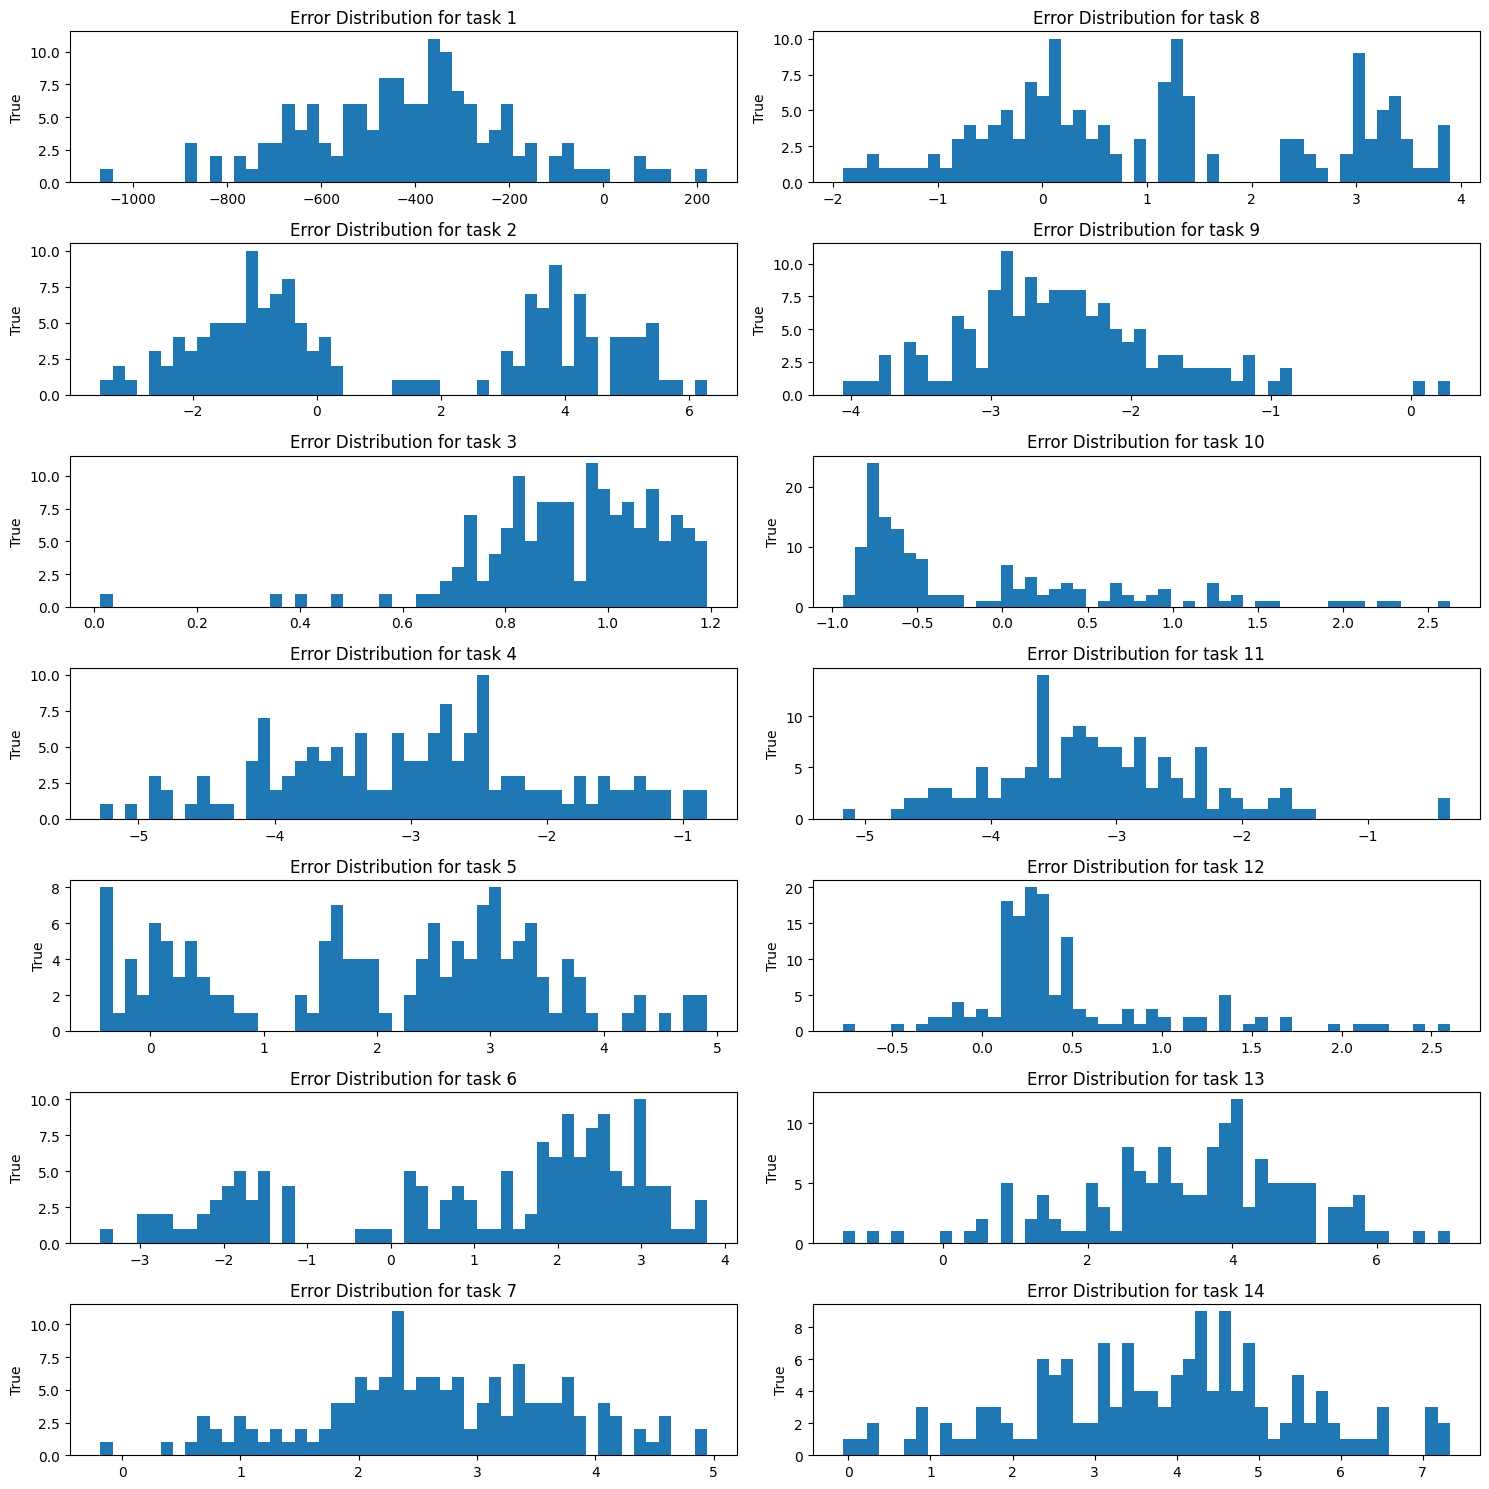

Error distribution of model 4


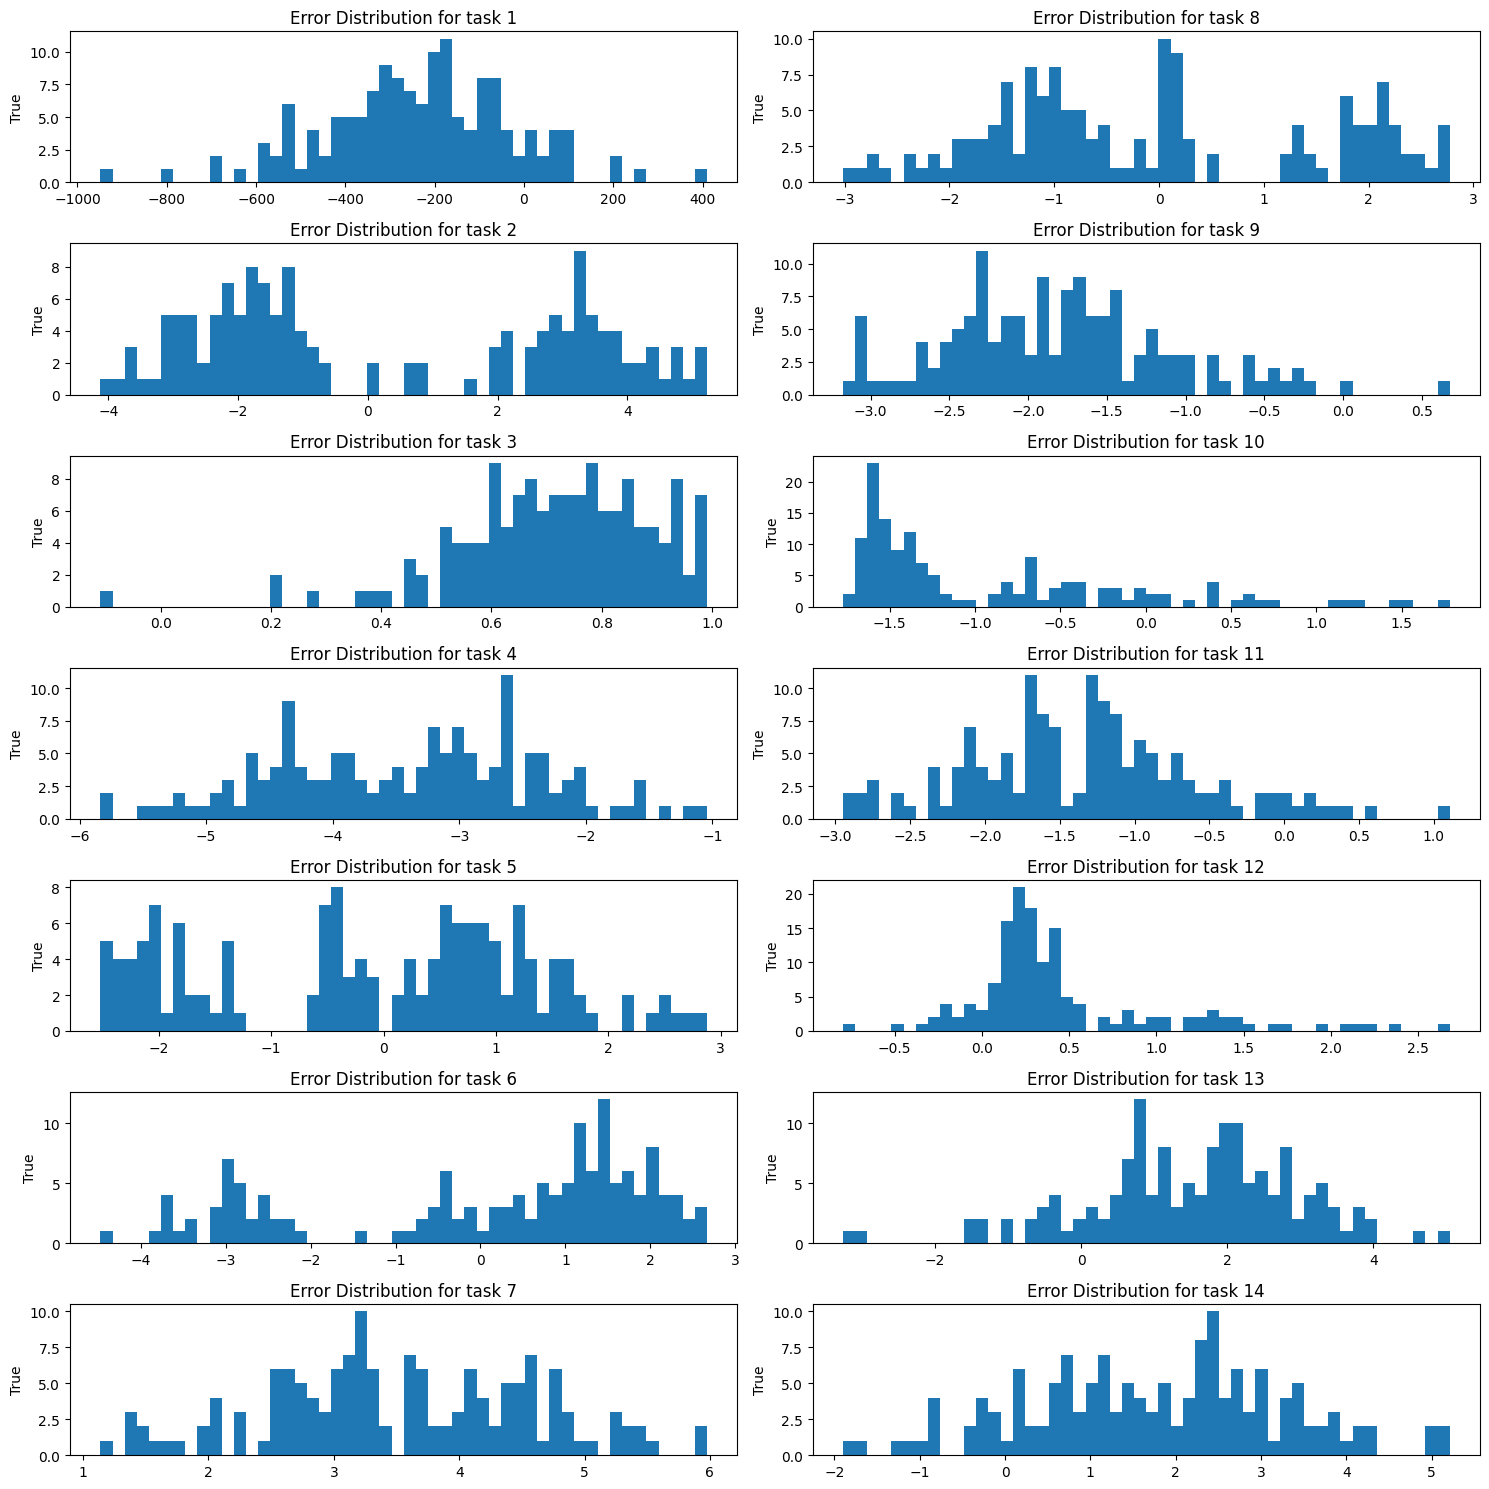

Error distribution of model 5


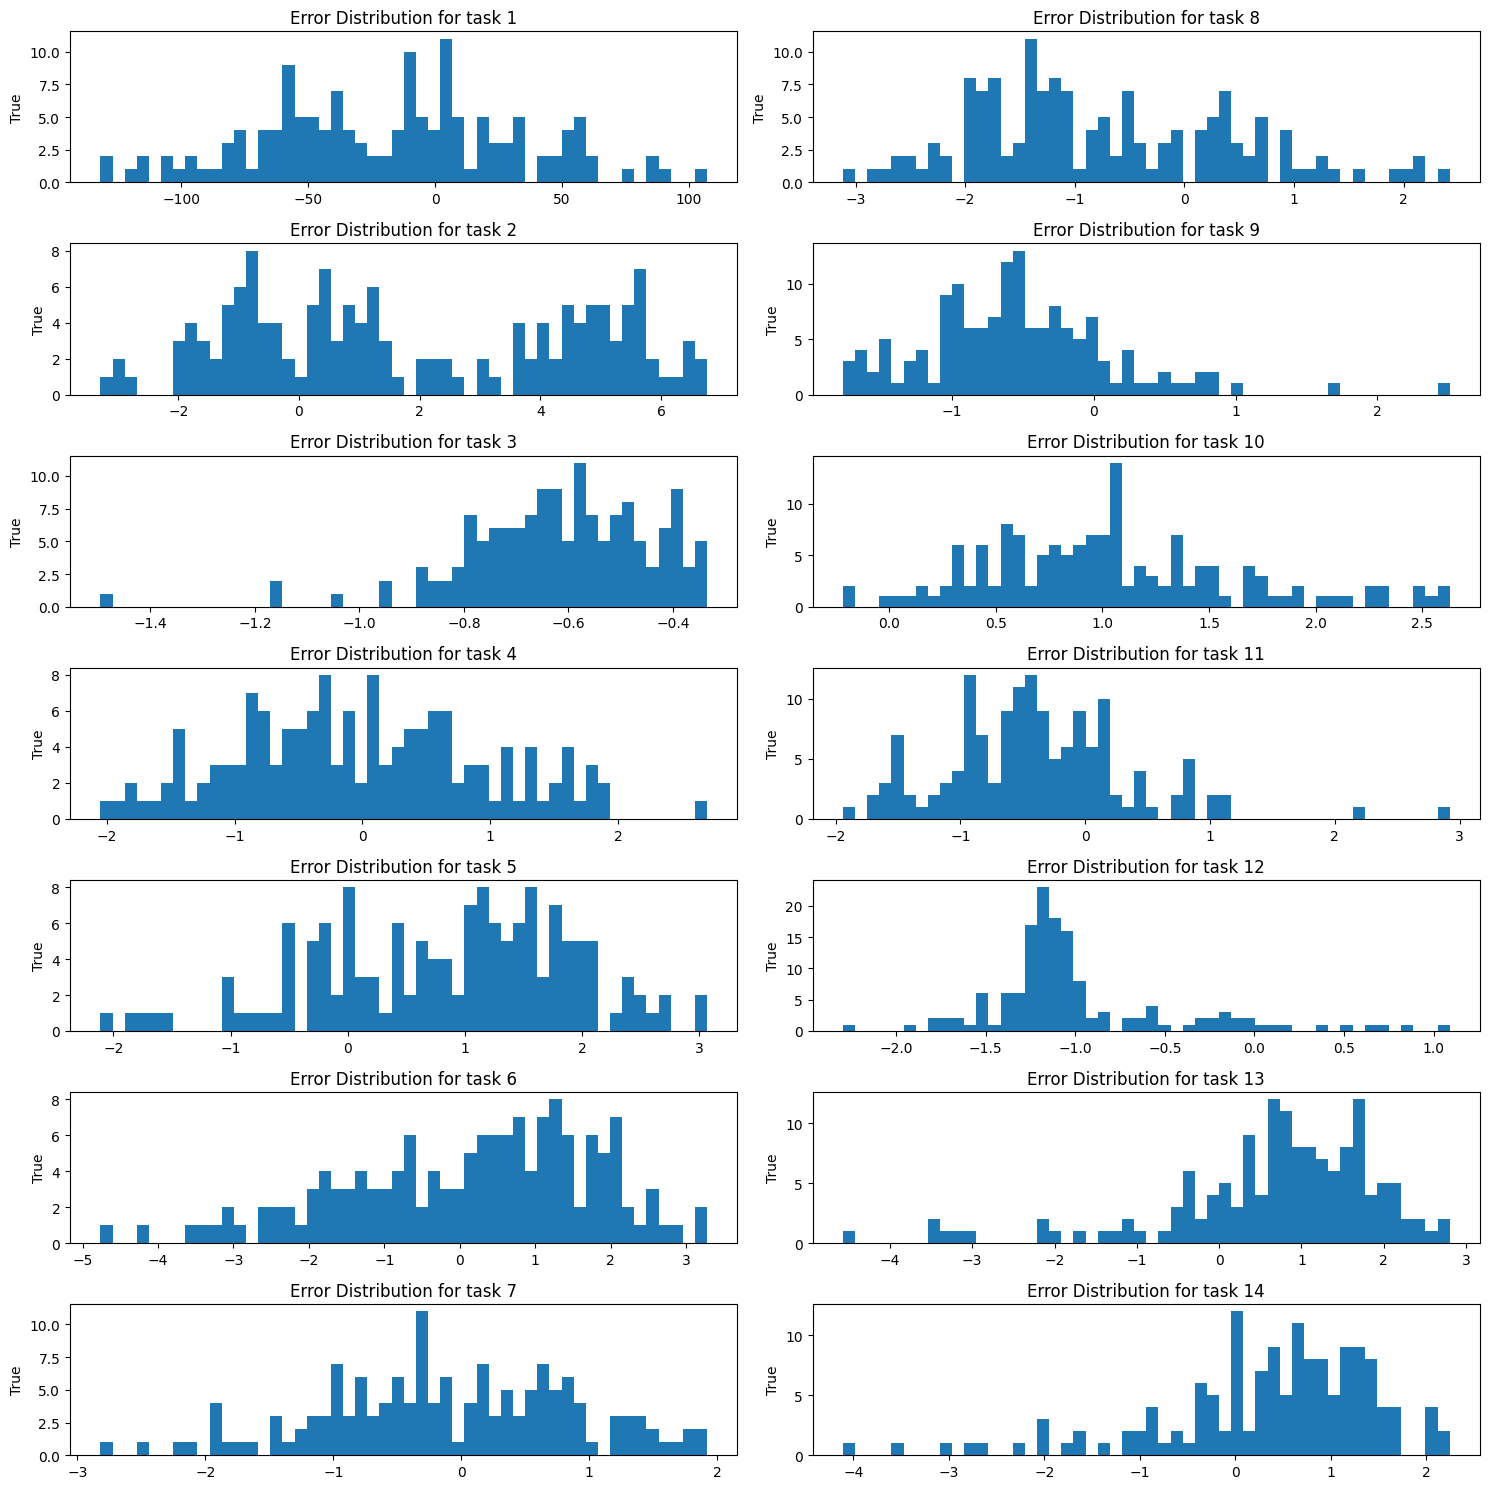

In [ ]:
for i, (p, y) in enumerate(res):
    print(f"Error distribution of model {i+1}")
    print_error_dist(p, y)


Margin distribution of model 1


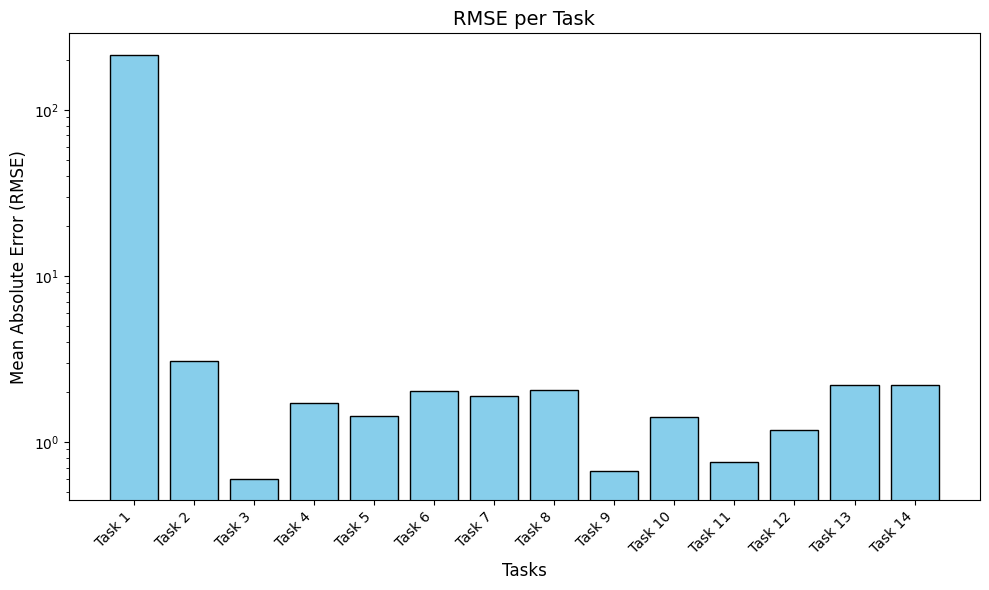

Margin distribution of model 2


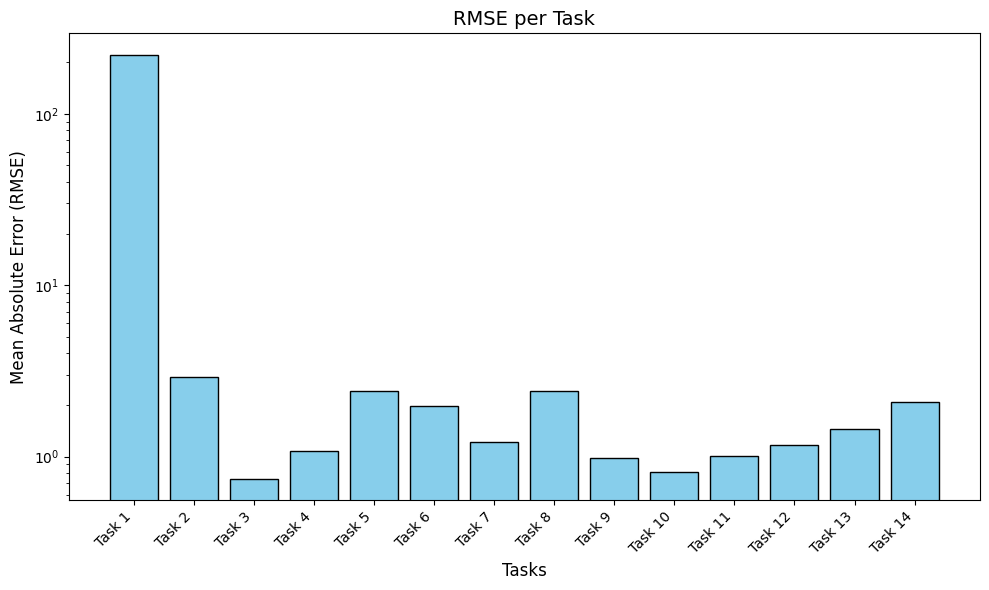

Margin distribution of model 3


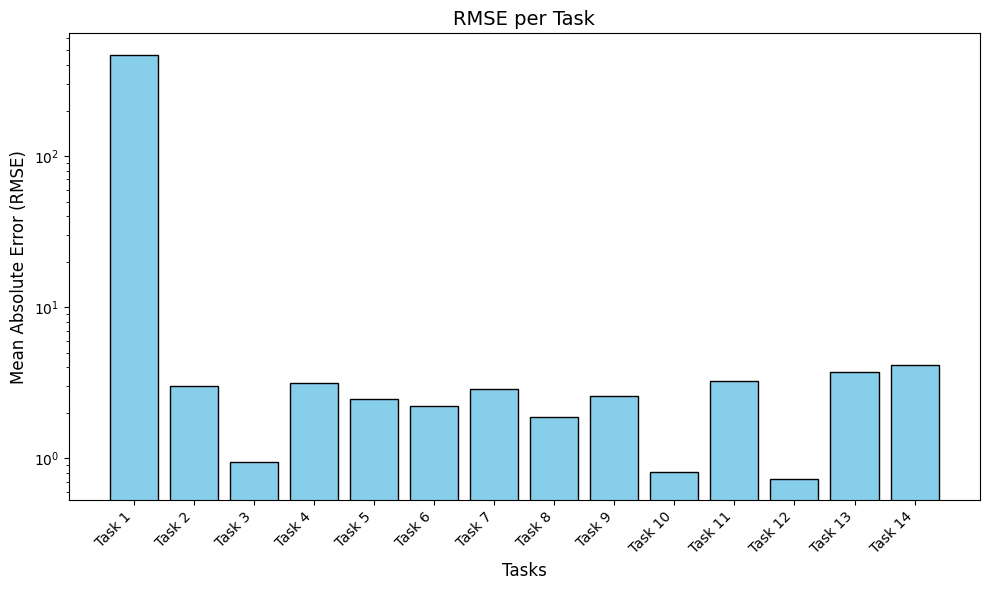

Margin distribution of model 4


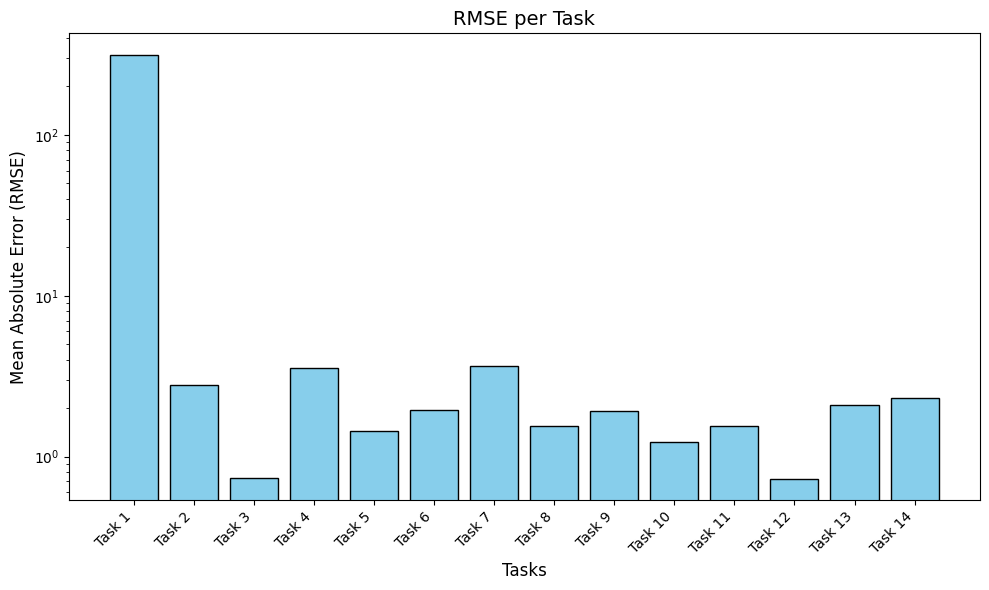

Margin distribution of model 5


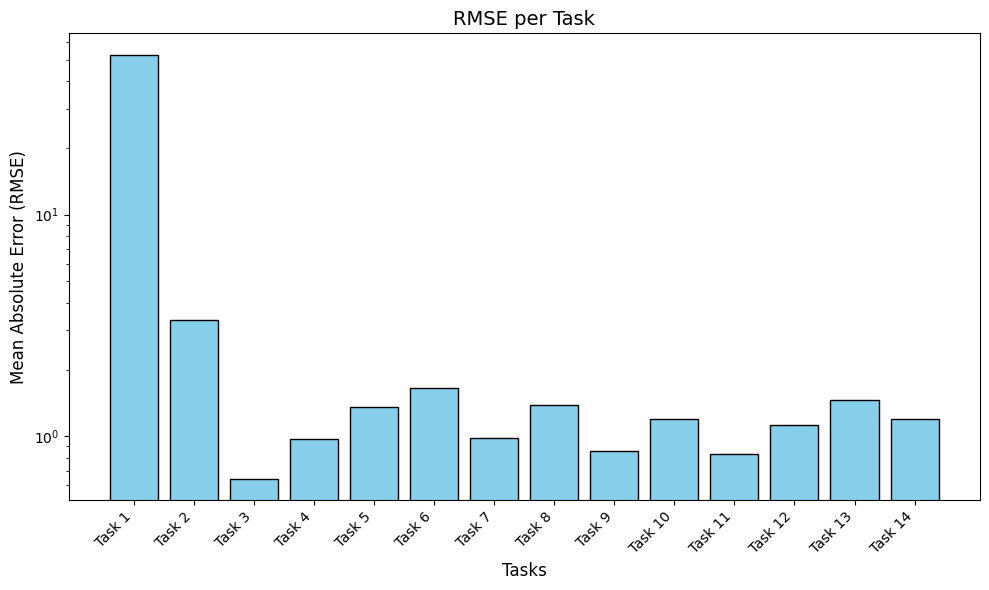

In [ ]:
for i, (p, y) in enumerate(res):
    print(f"Margin distribution of model {i+1}")
    print_margin_dist(p, y)


# Best model with different layers

In [ ]:
class GATLayer2(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True,residual_proj=None):
        super(GATLayer2, self).__init__()

        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat
        self.is_residual = residual_proj



        # Xavier Initialization of Weights
        # linear transformation
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features))).to('cuda')
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        # attention paramenters
        self.a = nn.Parameter(torch.zeros(size=(2 * out_features+1, 1))).to('cuda')
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        # set leaky relu
        self.leakyrelu = nn.LeakyReLU(self.alpha)

        if residual_proj:
            self.residual_proj = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()
        else:
            self.residual_proj = None

    def forward(self, input, adj, edge_feature):
        input = input.to(device)
        adj = adj.to(device)
        edge_attr = edge_feature.to(device)



        # Linear Transformation (for all nodes in the batch)

        h = torch.mm(input, self.W)  # (n_nodes, out_features)
        N = h.size(0)  # Number of nodes in the batch

        h_i = h.repeat(1, N).view(N * N, -1)
        h_j = h.repeat(N, 1)


        edge_features = torch.zeros(N * N, 1).to(device)
        edge_indices = torch.nonzero(adj, as_tuple=False)  # This returns indices (i, j) where adj[i, j] == 1

        edge_features[edge_indices[:, 0] * N + edge_indices[:, 1]] = edge_attr
        edge_features = edge_features.view(N*N,1)


        # Attention Mechanism (for all nodes in the batch)
        a_input = torch.cat([h_i,h_j, edge_features], dim=1).view(N, -1, 2 * self.out_features+1) # (n_nodes,n_nodes, 2*out_features+1)


        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2)) # (n_nodes,n_nodes)

        # Masked Attention (applying the adjacency matrix of the batch)
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec) # (n_nodes,n_nodes)

        # Softmax and Dropout
        attention = F.softmax(attention, dim=1) # (n_nodes,n_nodes)
        attention = F.dropout(attention, self.dropout, training=self.training) # (n_nodes,n_nodes)
        h_prime = torch.matmul(attention, h) # (n_nodes,output)

         # Residual Connection: project input if necessary
        if self.residual_proj is not None:
            input = self.residual_proj(input)
            h_prime = h_prime + input  # Add residual connection

        if self.concat:
            return F.elu(h_prime).view(-1, self.out_features) # (n_nodes,2)
        else:
            return h_prime.view(-1, self.out_features) # (n_nodes,2)

In [ ]:
from torch_geometric.nn import global_mean_pool, global_max_pool, LayerNorm

class MultiHeadGat3(nn.Module):
    def __init__(self, num_heads, in_features, hidden_features, dropout, alpha, concat=True, is_layerNorm = True, residual = True):
        super(MultiHeadGat3, self).__init__()

        self.num_heads = num_heads
        self.concat = concat
        self.dropout = dropout
        self.is_layerNorm= is_layerNorm




        # Initialize attention heads
        self.heads = nn.ModuleList([
            GATLayer2(
                in_features=in_features,
                out_features=hidden_features,
                dropout=dropout,
                alpha=alpha,
                concat=concat,
                residual_proj=residual
            ) for i in range(num_heads)
        ])

        # Head transformation layer
        if concat:
            self.head_transform = nn.Linear(hidden_features * num_heads, hidden_features)

        # Layer norm
        if is_layerNorm:
          self.layer_norms = nn.ModuleList([nn.LayerNorm(head.out_features) for head in self.heads])


        # Final classification layer

    def forward(self, x, adj, edge_attr,  batch=None):
        head_outputs = [head(x, adj,edge_attr) for head in self.heads]
        if self.is_layerNorm:
          head_outputs = [self.layer_norms[i](x) for i,x in enumerate(head_outputs)]

        if self.concat:
            x = torch.cat(head_outputs, dim=-1)  # (N, num_heads * hidden_features)
            x = F.relu(self.head_transform(x))  # (N, hidden_features)
            x = F.dropout(x, p=self.dropout, training=self.training)

        else:
            x = torch.mean(torch.stack(head_outputs), dim=0)  # (N, hidden_features)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)


        return x

In [ ]:
class MultiLayerGat(nn.Module):
    def __init__(self, num_layers, num_heads, in_features, hidden_features, out_features, dropout, alpha, concat=True, pooling_type='mean', is_layerNorm = True, residual = True, concat_res = True):
        super(MultiLayerGat, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout
        self.pooling_type = pooling_type
        self.is_layerNorm= is_layerNorm
        self.in_feature_layer2 = hidden_features
        self.concat_result = concat_res


        self.heads = nn.ModuleList([
            MultiHeadGat3(num_heads=num_heads,
                          in_features= in_features if i == 0 else hidden_features,
                          hidden_features=hidden_features,
                          dropout = dropout,
                          alpha = alpha,
                          concat = concat[i],
                          is_layerNorm = True,
                          residual = True)


            for i in range(num_layers)
        ])


        self.classifier_input = hidden_features * num_heads if concat_res else hidden_features

        self.classifier = torch.nn.Linear(self.classifier_input, out_features)


    def forward(self, x, adj, edge_attr, batch):
        graph_representations = []

        for idx, head in enumerate(self.heads):
            node_features = head(x, adj, edge_attr, batch)

            if self.pooling_type == 'mean':
                graph_features = global_mean_pool(node_features, batch)
            elif self.pooling_type == 'max':
                graph_features = global_max_pool(node_features, batch)



            graph_representations.append(graph_features)

            if idx < self.num_layers - 1:
                x = F.elu(node_features)
                x = F.dropout(x, p=self.dropout, training=self.training)

        # Concatenate or average the graph-level representations from each layer
        if self.concat_result:
            x = torch.cat(graph_representations, dim=-1)
        else:
            x = torch.mean(torch.stack(graph_representations), dim=0)

        x = self.classifier(x)
        return x



In [ ]:
model6 = MultiLayerGat(num_layers = 2, num_heads=3,in_features=4,hidden_features=64,out_features=14,dropout=0.6,alpha=0.2,
                       concat=[True, False], pooling_type='mean', is_layerNorm = True, residual = True, concat_res = False)


In [ ]:
epoches = 10
criterion = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



loss_model6, pred_model6,loss_history_model6 = train3(epoch =epochs,data = train_loader,
                                                     model = model6,criterion = criterion,
                                                     lr = 0.01,wd = 5e-4,device = device)


 10%|█         | 1/10 [00:22<03:19, 22.16s/it]

The current loss is 26333.2716


 20%|██        | 2/10 [00:44<03:00, 22.51s/it]

The current loss is 13625.3990


 30%|███       | 3/10 [01:10<02:47, 23.93s/it]

The current loss is 9351.8357


 40%|████      | 4/10 [01:35<02:24, 24.14s/it]

The current loss is 7201.3335


 50%|█████     | 5/10 [01:57<01:58, 23.65s/it]

The current loss is 5910.1559


 60%|██████    | 6/10 [02:20<01:33, 23.36s/it]

The current loss is 5052.0398


 70%|███████   | 7/10 [02:42<01:08, 22.93s/it]

The current loss is 4435.1751


 80%|████████  | 8/10 [03:05<00:45, 22.86s/it]

The current loss is 3968.8993


 90%|█████████ | 9/10 [03:28<00:22, 22.90s/it]

The current loss is 3605.5518


100%|██████████| 10/10 [03:50<00:00, 23.09s/it]

The current loss is 3312.1869


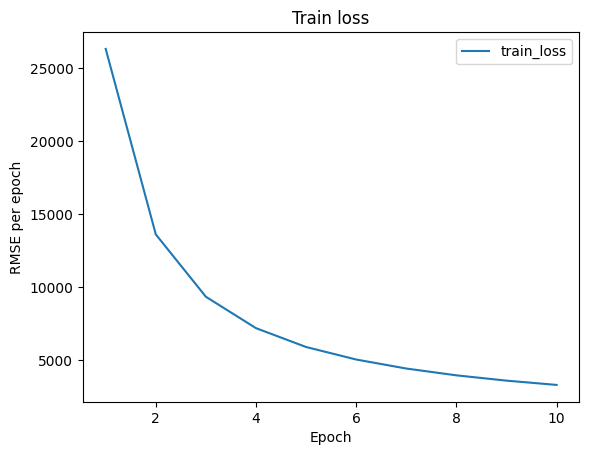

In [ ]:
fig,ax = plt.subplots()
x = range(1, epochs +1)
ax.plot(x,loss_history_model6, label= "train_loss")

ax.legend()
ax.set_title("Train loss")
ax.set_ylabel("RMSE per epoch")
ax.set_xlabel("Epoch")
plt.show()


In [ ]:
test_loss6, pred6, y_test6 = test3(test_loader, model6, device)

In [ ]:
res_2 = res = [(globals()[f"pred{i}"],globals()[f"y_test{i}"]) for i in range(5, 7)]

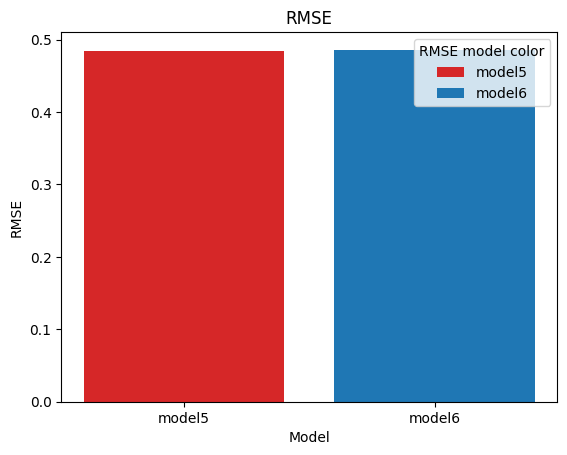

In [ ]:
fig, ax = plt.subplots()
x = range(1,3)
bar_labels = ['model5', 'model6']
bar_colors = ['tab:red', 'tab:blue']

ax.bar(x, [RMSE5,test_loss6], label = bar_labels, color=bar_colors)
ax.legend(title='RMSE model color')

ax.set_xticks(x)
ax.set_xticklabels(['model5', 'model6'])
ax.set_title("RMSE")
ax.set_ylabel("RMSE")
ax.set_xlabel("Model")
plt.show()

Scatterplot of model 5


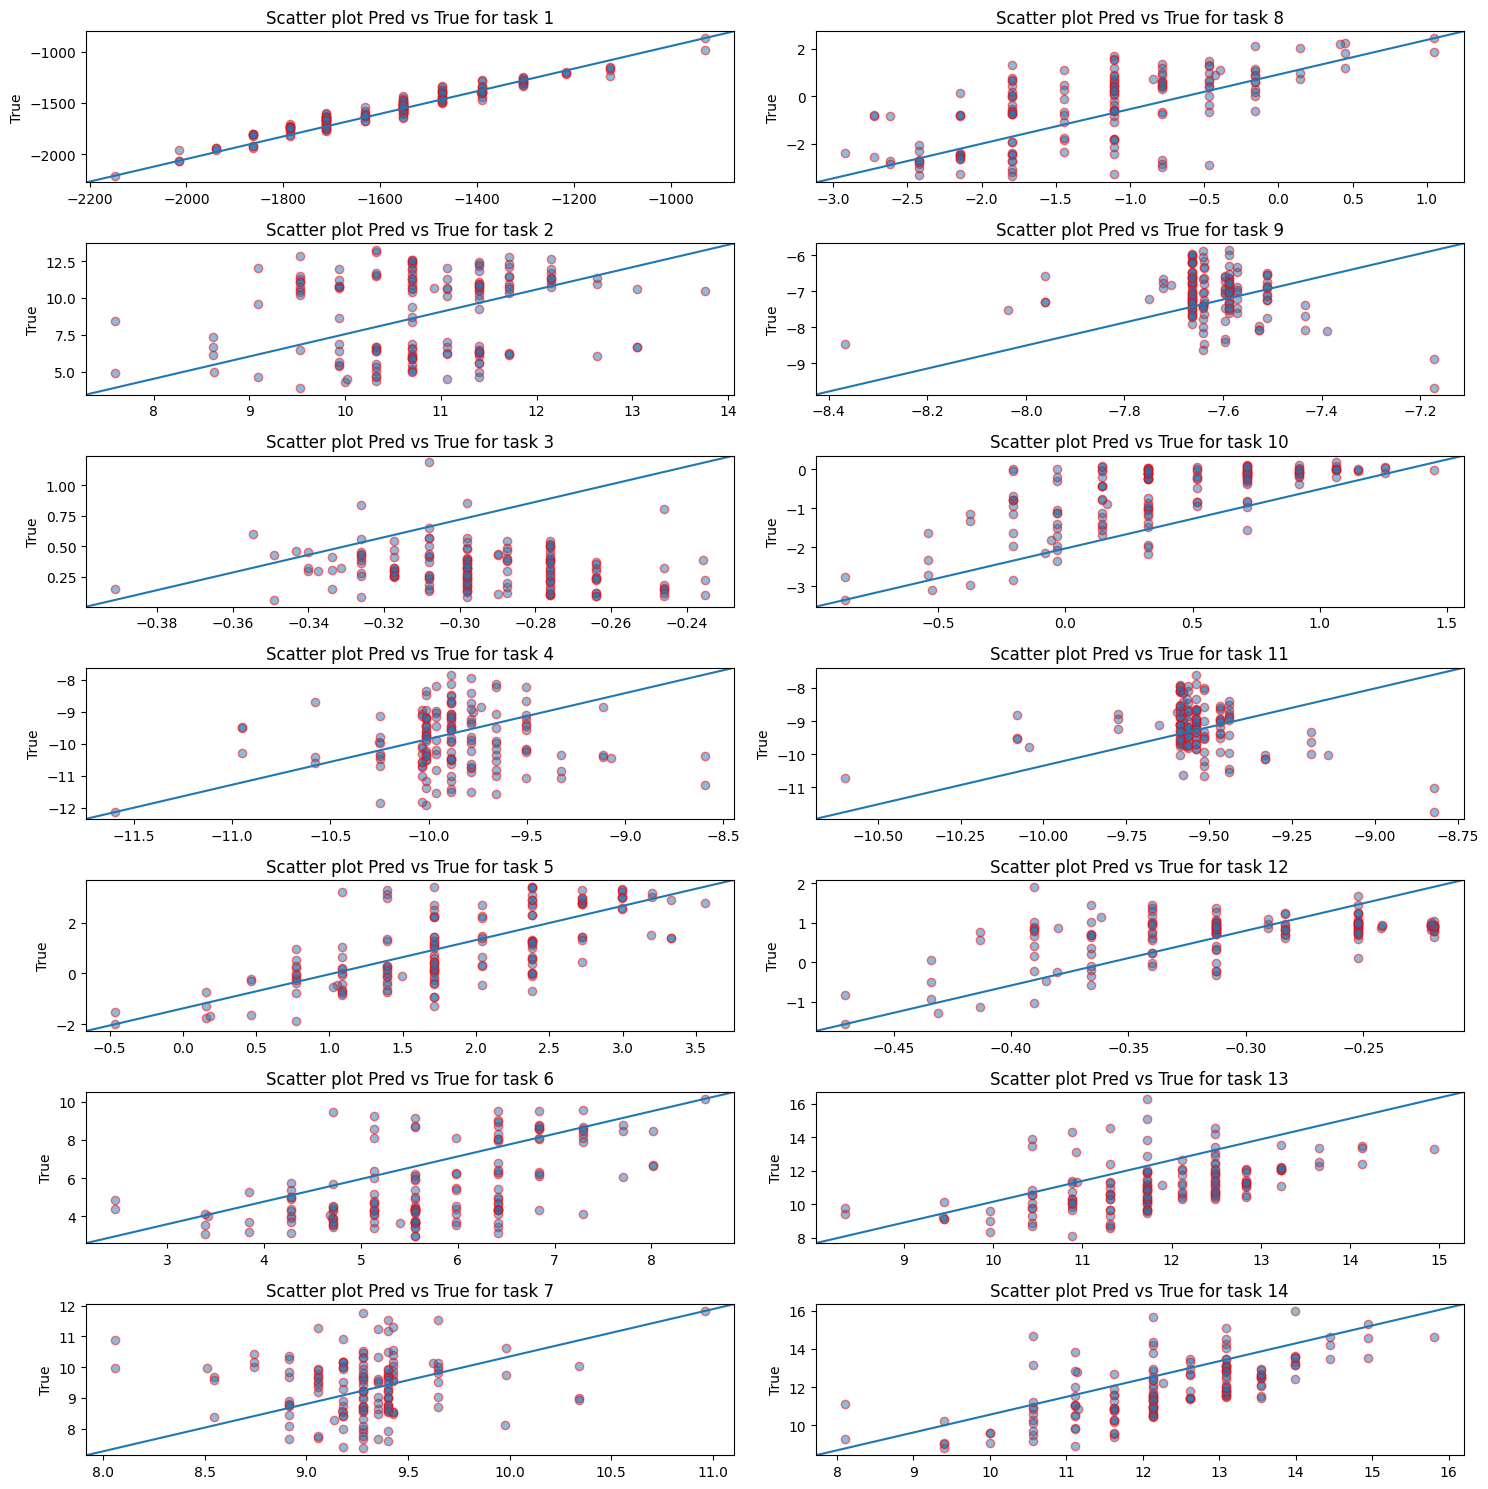

Scatterplot of model 6


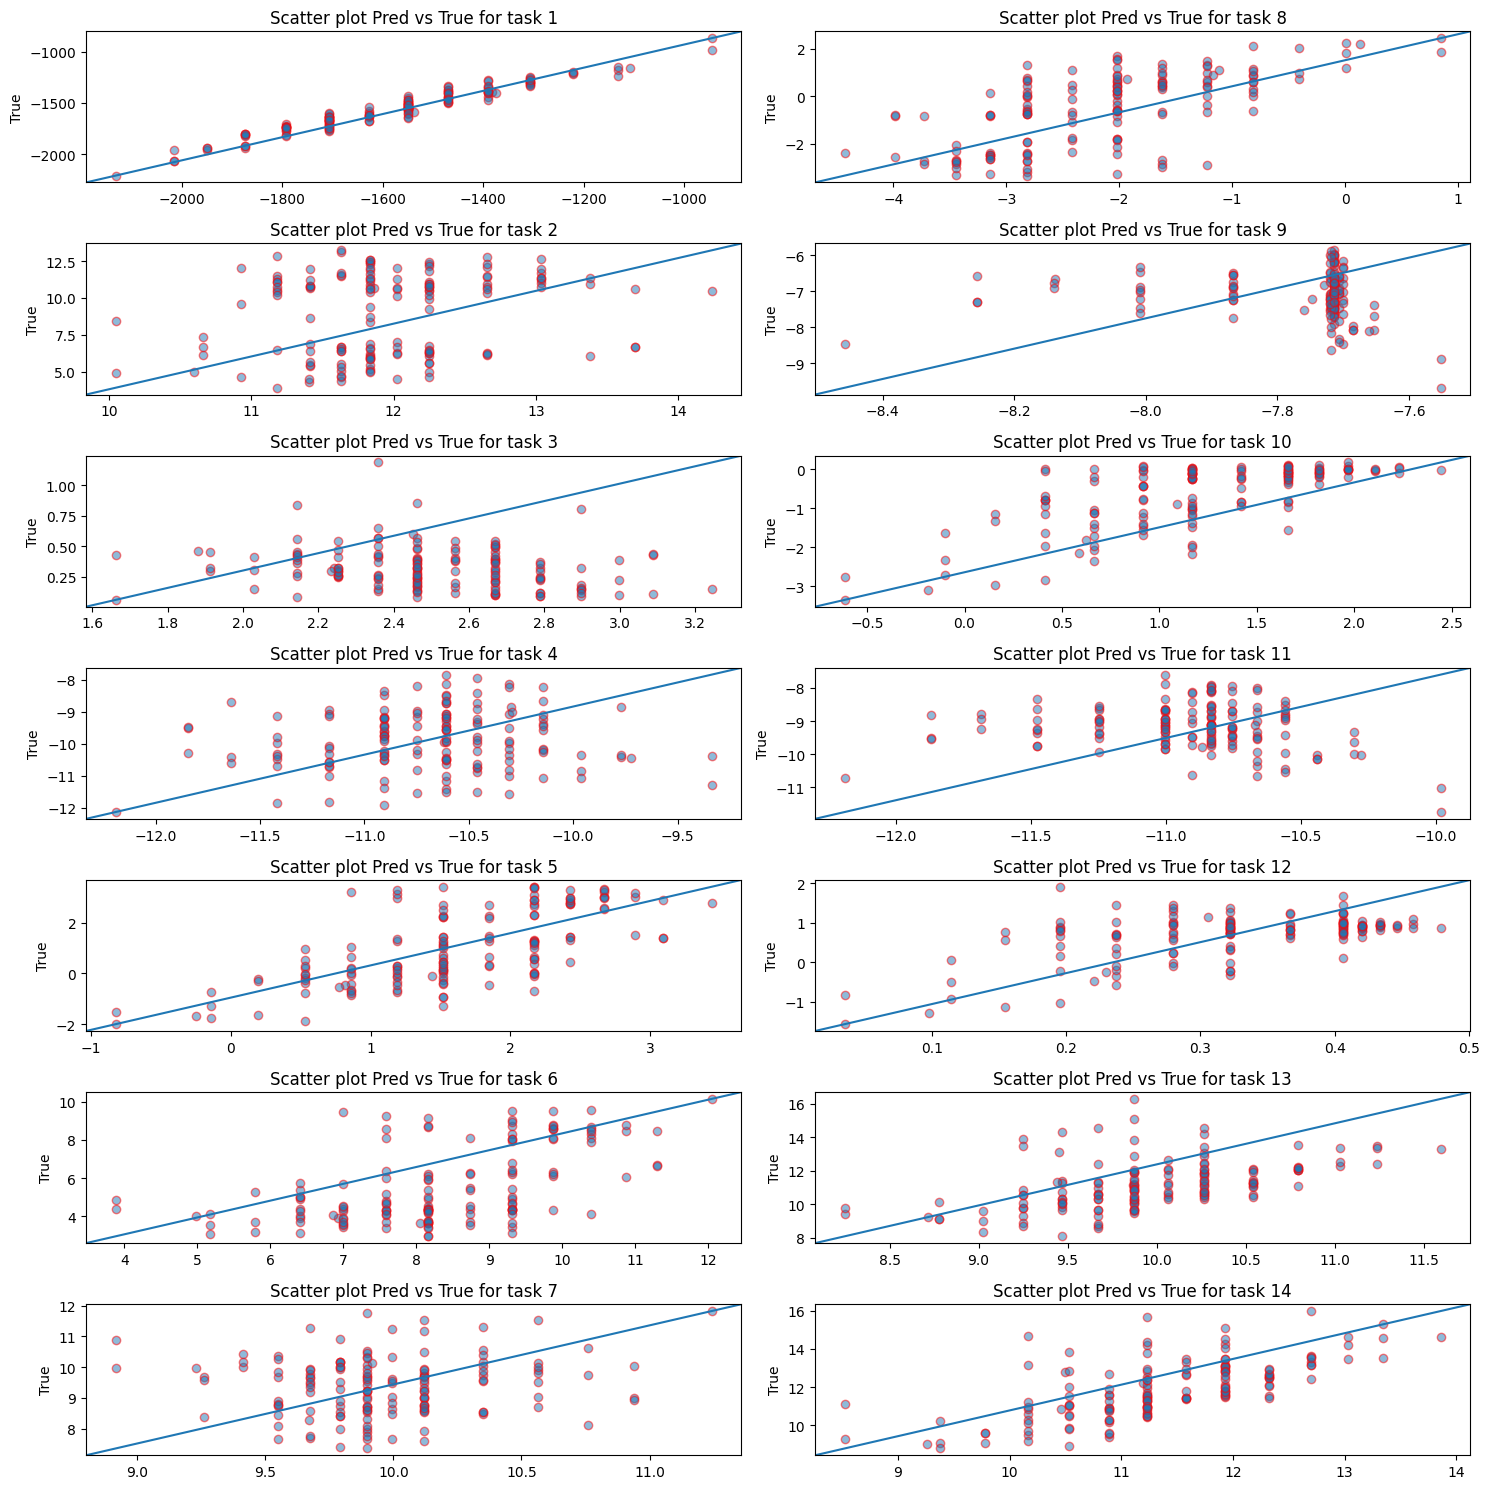

In [ ]:
for i, (p, y) in enumerate(res_2):
    t = 5
    print(f"Scatterplot of model {i+t}")
    print_scatterplot(p, y)


Error distribution of model 5


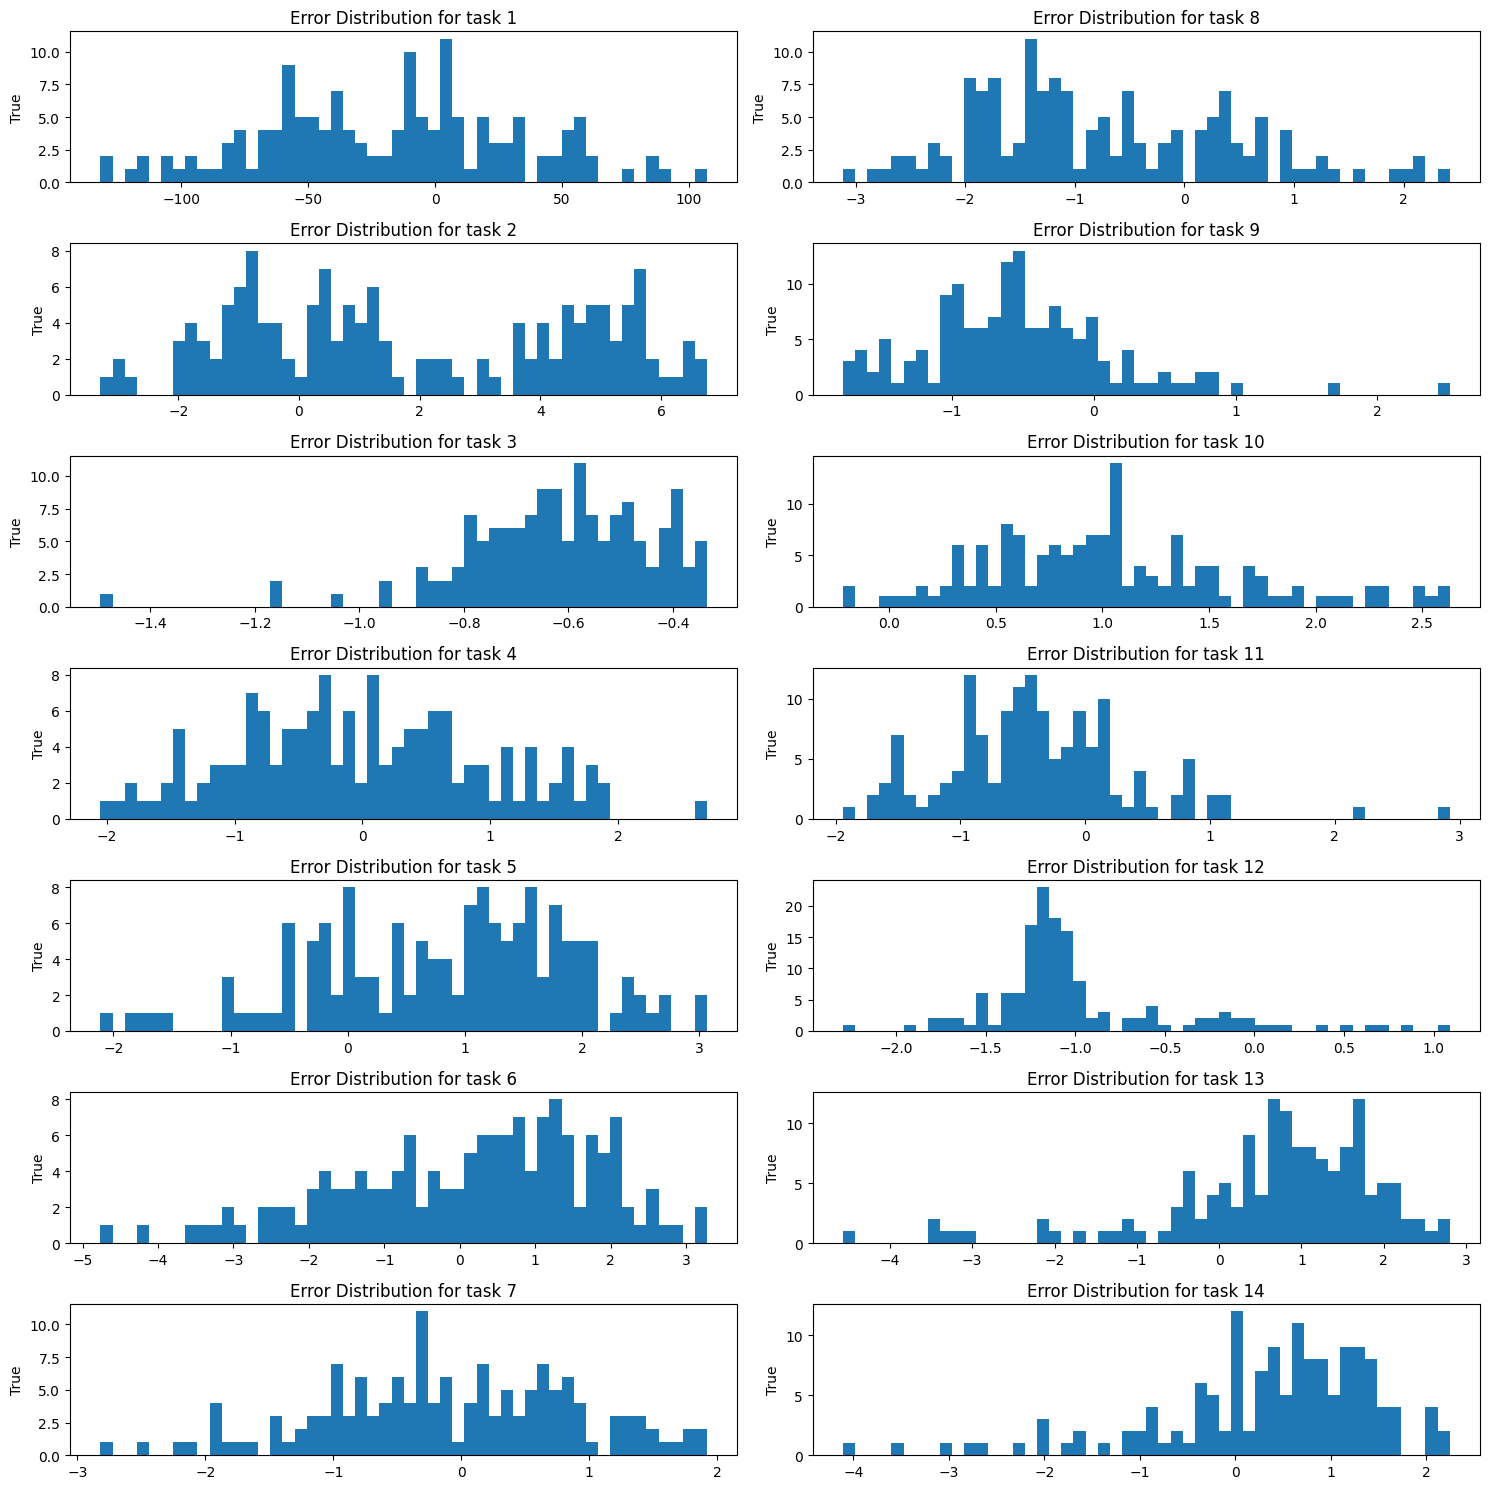

Error distribution of model 6


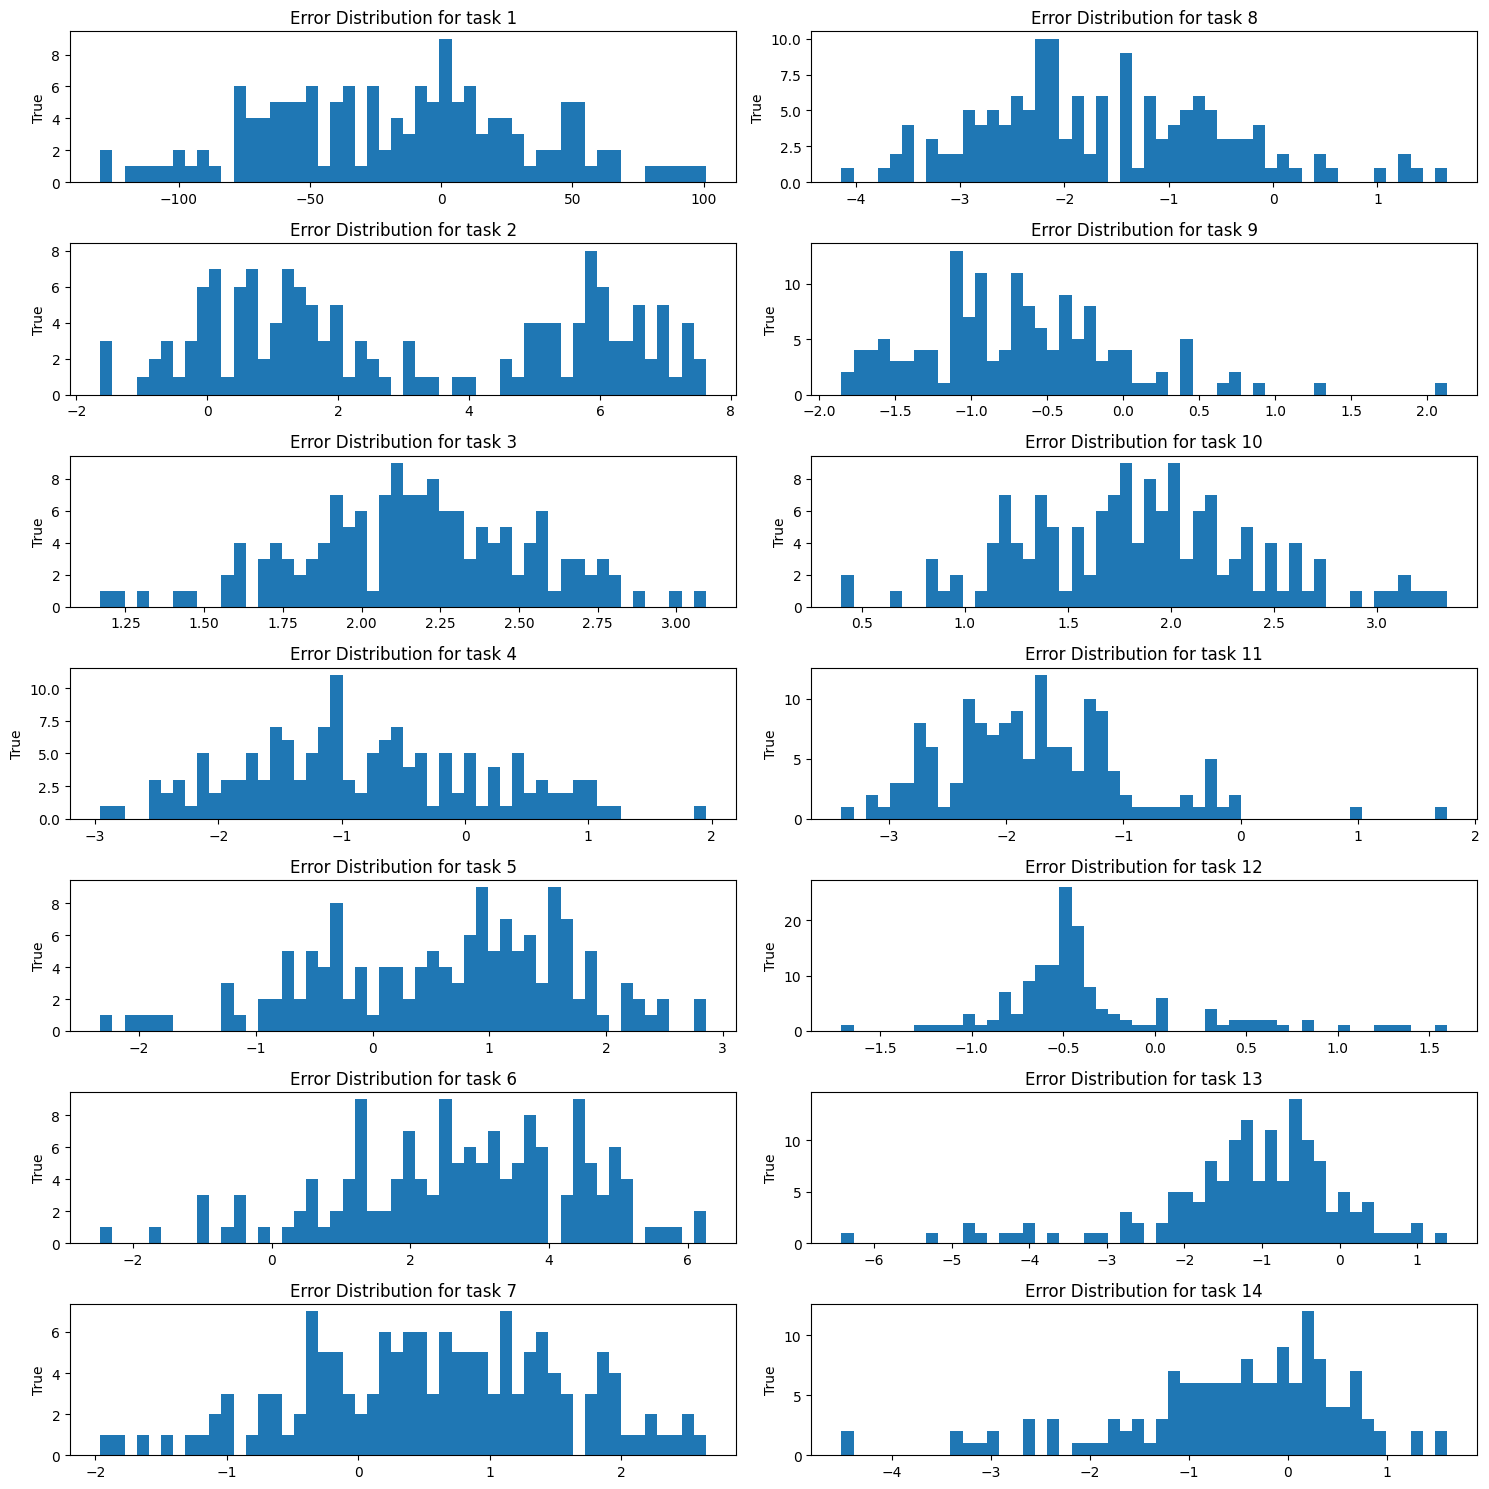

In [ ]:
for i, (p, y) in enumerate(res_2):
    t = 5
    print(f"Error distribution of model {i+t}")
    print_error_dist(p, y)


Margin distribution of model 5


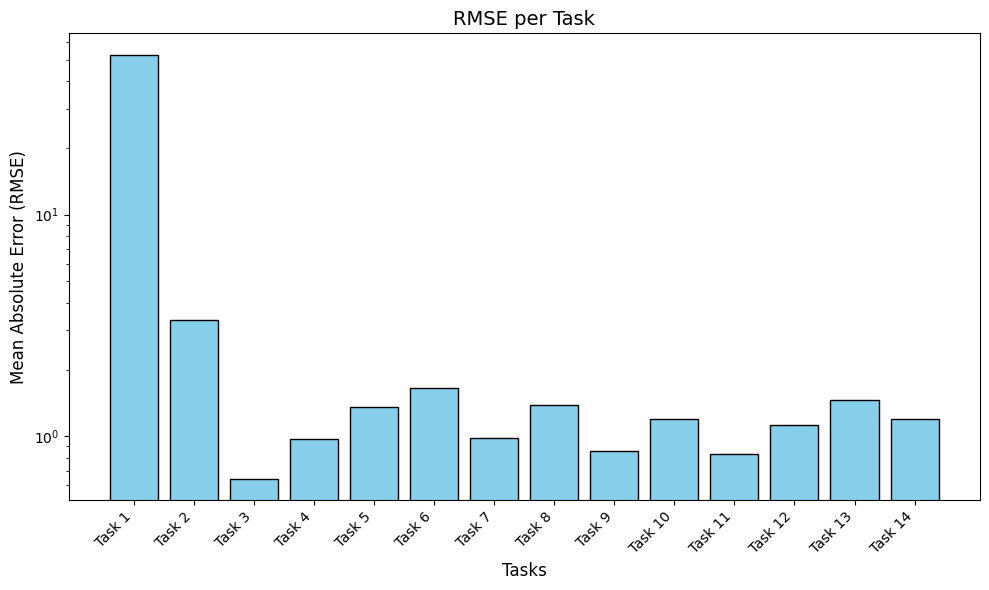

Margin distribution of model 6


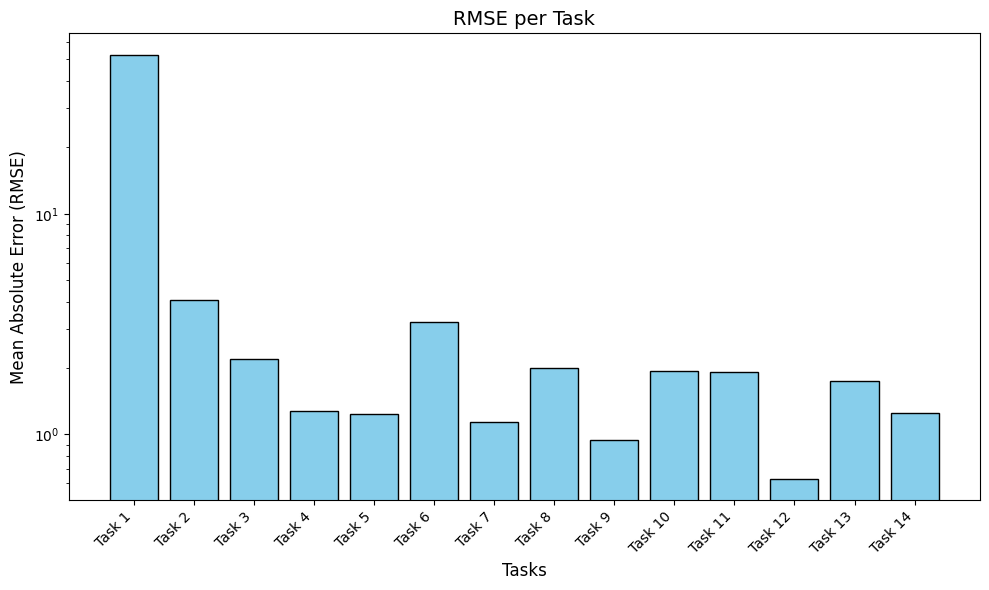

In [ ]:
for i, (p, y) in enumerate(res_2):
    t=5
    print(f"Margin distribution of model {i+t}")
    print_margin_dist(p, y)
